In [265]:
import pandas as pd
import random
from time import sleep
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np
import nltk
import os
from sklearn import datasets
import pickle
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import NearestNeighbors
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, fbeta_score
from sklearn.model_selection import learning_curve, KFold, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize

import matplotlib.style as style
%matplotlib inline
plt.style.use('ggplot')

In [2]:
with open('data/cleaned_df.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [224]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [3]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [4]:
df.head()

song_owner       song_title  \
0  Childish Gambino  This Is America   
1  Childish Gambino  This Is America   
2  Childish Gambino  This Is America   
3  Childish Gambino  This Is America   
4  Childish Gambino  This Is America   

                                        song_element  \
0            [Bridge: Childish Gambino & Young Thug]   
1                         [Chorus: Childish Gambino]   
2  [Verse 1: Childish Gambino, Blocboy JB, Slim J...   
3                [Refrain: Choir & Childish Gambino]   
4  [Chorus: Childish Gambino, Slim Jxmmi & Young ...   

                                               verse            artist  
0  We just wanna party, Party just for you, We ju...  Childish Gambino  
1  This is America, Don't catch you slippin' now,...  Childish Gambino  
2  This is America (skrrt, skrrt, woo), Don't cat...  Childish Gambino  
3  Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...  Childish Gambino  
4  This is America (woo, ayy), Don't catch you sl...  Childish Gambino

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6304 entries, 0 to 6303
Data columns (total 5 columns):
song_owner      6304 non-null object
song_title      6304 non-null object
song_element    6304 non-null object
verse           6304 non-null object
artist          6304 non-null object
dtypes: object(5)
memory usage: 246.3+ KB


In [6]:
model_df = df.copy()

In [7]:
model_df = model_df[model_df['artist'] != "Kanye West"]
model_df = model_df[model_df['artist'] != "Kendrick Lamar"]
model_df = model_df[model_df['artist'] != "Drake"]

In [8]:
model_df.artist.value_counts()

Childish Gambino     824
Chance the Rapper    468
Name: artist, dtype: int64

In [9]:
from nltk.tokenize import word_tokenize
model_df['verse_words'] = model_df['verse'].apply(lambda x: word_tokenize(x))

In [10]:
model_df.reset_index(drop=True, inplace=True)

In [11]:
stemmer = nltk.stem.porter.PorterStemmer()

model_df['verse_stem'] = model_df["verse_words"].apply(lambda x: [stemmer.stem(y) for y in x])

In [12]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

model_df['verse_lem'] = model_df["verse_words"].apply(lambda x: [wordnet_lemmatizer.lemmatize(y, pos='v') for y in x])

In [13]:
model_df['verse_stem'] = model_df['verse_stem'].apply(', '.join)
model_df['verse_stem'] = model_df['verse_stem'].apply(lambda x: x.replace(", ", " "))

In [14]:
model_df['verse_lem'] = model_df['verse_lem'].apply(', '.join)
model_df['verse_lem'] = model_df['verse_lem'].apply(lambda x: x.replace(", ", " "))

In [15]:
model_df['rapper'] = 0

In [16]:
model_df.head()

song_owner       song_title  \
0  Childish Gambino  This Is America   
1  Childish Gambino  This Is America   
2  Childish Gambino  This Is America   
3  Childish Gambino  This Is America   
4  Childish Gambino  This Is America   

                                        song_element  \
0            [Bridge: Childish Gambino & Young Thug]   
1                         [Chorus: Childish Gambino]   
2  [Verse 1: Childish Gambino, Blocboy JB, Slim J...   
3                [Refrain: Choir & Childish Gambino]   
4  [Chorus: Childish Gambino, Slim Jxmmi & Young ...   

                                               verse            artist  \
0  We just wanna party, Party just for you, We ju...  Childish Gambino   
1  This is America, Don't catch you slippin' now,...  Childish Gambino   
2  This is America (skrrt, skrrt, woo), Don't cat...  Childish Gambino   
3  Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...  Childish Gambino   
4  This is America (woo, ayy), Don't catch you sl...  Childish Gambino   

                                         verse_words  \
0  [We, just, wan, na, party, ,, Party, just, for...   
1  [This, is, America, ,, Do, n't, catch, you, sl...   
2  [This, is, America, (, skrrt, ,, skrrt, ,, woo...   
3  [Ooh-ooh-ooh-ooh-ooh, ,, tell, somebody, ,, Yo...   
4  [This, is, America, (, woo, ,, ayy, ), ,, Do, ...   

                                          verse_stem  \
0  We just wan na parti , parti just for you , We...   
1  thi is america , Do n't catch you slippin ' no...   
2  thi is america ( skrrt , skrrt , woo ) , Do n'...   
3  ooh-ooh-ooh-ooh-ooh , tell somebodi , you go t...   
4  thi is america ( woo , ayi ) , Do n't catch yo...   

                                           verse_lem  rapper  
0  We just wan na party , Party just for you , We...       0  
1  This be America , Do n't catch you slippin ' n...       0  
2  This be America ( skrrt , skrrt , woo ) , Do n...       0  
3  Ooh-ooh-ooh-ooh-ooh , tell somebody , You go t...       0  
4  This be America ( woo , ayy ) , Do n't catch y...       0

In [17]:
model_df.loc[model_df["artist"] == 'Childish Gambino', "rapper"] = 1
model_df.loc[model_df["artist"] == 'Chance the Rapper', "rapper"] = 2
model_df.loc[model_df["artist"] == 'Drake', "rapper"] = 3
model_df.loc[model_df["artist"] == 'Kendrick Lamar', "rapper"] = 4
model_df.loc[model_df["artist"] == 'Kanye West', "rapper"] = 5

In [18]:
model_df.head()

song_owner       song_title  \
0  Childish Gambino  This Is America   
1  Childish Gambino  This Is America   
2  Childish Gambino  This Is America   
3  Childish Gambino  This Is America   
4  Childish Gambino  This Is America   

                                        song_element  \
0            [Bridge: Childish Gambino & Young Thug]   
1                         [Chorus: Childish Gambino]   
2  [Verse 1: Childish Gambino, Blocboy JB, Slim J...   
3                [Refrain: Choir & Childish Gambino]   
4  [Chorus: Childish Gambino, Slim Jxmmi & Young ...   

                                               verse            artist  \
0  We just wanna party, Party just for you, We ju...  Childish Gambino   
1  This is America, Don't catch you slippin' now,...  Childish Gambino   
2  This is America (skrrt, skrrt, woo), Don't cat...  Childish Gambino   
3  Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...  Childish Gambino   
4  This is America (woo, ayy), Don't catch you sl...  Childish Gambino   

                                         verse_words  \
0  [We, just, wan, na, party, ,, Party, just, for...   
1  [This, is, America, ,, Do, n't, catch, you, sl...   
2  [This, is, America, (, skrrt, ,, skrrt, ,, woo...   
3  [Ooh-ooh-ooh-ooh-ooh, ,, tell, somebody, ,, Yo...   
4  [This, is, America, (, woo, ,, ayy, ), ,, Do, ...   

                                          verse_stem  \
0  We just wan na parti , parti just for you , We...   
1  thi is america , Do n't catch you slippin ' no...   
2  thi is america ( skrrt , skrrt , woo ) , Do n'...   
3  ooh-ooh-ooh-ooh-ooh , tell somebodi , you go t...   
4  thi is america ( woo , ayi ) , Do n't catch yo...   

                                           verse_lem  rapper  
0  We just wan na party , Party just for you , We...       1  
1  This be America , Do n't catch you slippin ' n...       1  
2  This be America ( skrrt , skrrt , woo ) , Do n...       1  
3  Ooh-ooh-ooh-ooh-ooh , tell somebody , You go t...       1  
4  This be America ( woo , ayy ) , Do n't catch y...       1

In [19]:
artist_name = ['Childish Gambino', 'Chance the Rapper', 'Drake', 'Kendrick Lamar', 'Kanye West']

In [20]:
verses = list(model_df.verse.values)

In [21]:
print(verses[:10])

["We just wanna party, Party just for you, We just want the money, Money just for you (yeah), I know you wanna party, Party just for free, Girl, you got me dancin' (girl, you got me dancin'), Dance and shake the frame (yeah), We just wanna party (yeah), Party just for you (yeah), We just want the money (yeah), Money just for you (you), I know you wanna party (yeah), Party just for free (yeah), Girl, you got me dancin' (girl, you got me dancin', yeah), Dance and shake the frame (ooh)", "This is America, Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now, This is America (woo), Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now", "This is America (skrrt, skrrt, woo), Don't catch you slippin' now (ayy), Look how I'm livin' now, Police be trippin' now (woo), Yeah, this is America (woo, ayy), Guns in my area (word, my area), I got the strap (ayy, ayy), I gotta carry 'em, Yeah, yeah, I'ma go into this (ugh), Yeah, yeah, 

In [22]:
model_df.index

RangeIndex(start=0, stop=1292, step=1)

In [131]:
def get_recommendations(first_verse, model, vectorizer, training_vectors):
    '''
    first_article: (string) An article that we want to use to find similar articles
    model: (a fit dimensionality reducer) Projects vectorized words onto a subspace 
           (uses NMF or SVD/LSA typically)
    training_vectors: (numpy array shape) a (num_docs in training) x (NMF/SVD/LSA) dimensional array.
                      Used to train NearestNeighbors model
    '''
    new_vec = model.transform(
        vectorizer.transform([first_verse]))
    nn = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='brute')
    nn.fit(training_vectors)
    results = nn.kneighbors(new_vec)
    return results[1][0][1:]

print(get_recommendations(model_df.verse_lem[163], lda_tfidf, tfidf_vectorizer, lda_tfidf_data))

[201  54 579 225 334 271 449  17 101 330]


In [132]:
def print_recommendations(first_verse,recommend_list):
    artist = model_df.artist.iloc[first_verse]
    verse = model_df.verse.iloc[first_verse]
    print(artist)
    print(verse)
    print('\n------\n')
    for resp in recommend_list:
        print('\n --- Result --- \n')
        print(model_df.artist.iloc[resp])
        print(model_df.verse.iloc[resp])
        
rec_list = get_recommendations(model_df.verse_lem[900], lda_tfidf, tfidf_vectorizer, lda_tfidf_data)
print_recommendations(900,rec_list)

Chance the Rapper
We never rolled at the Rink, we would just go to the Rink, You ain't buy tokens no more, you just hip roll at the Rink, You had a nigga, I couldn't stand him, But when they play "Take You Down", Chris Brown, I am his stand-in, I mean it's just dancing, it's harmless as fuck, Then I put my waist through your hips and your legs in my arms just to harness you up, Then we hit the floor, all the kiddies stop skating, To see grown folks do, what grown folks do when they grown and they dating

------


 --- Result --- 

Chance the Rapper
We never rolled at the Rink, We would just go to the Rink, You ain't buy tokens no more, You just hip roll at the Rink, You had a nigga, I couldn't stand him, But when they play "Take You Down", Chris Brown, I am his stand-in, I mean it's just dancing, It's harmless as fuck, Then I put my waist through your hips, And your legs and my arms just to harness you up, Then we hit the floor, All the kiddies stop skating, To see grown folks do, what

In [176]:
def recommendations_correct(first_verse,recommend_list):
    artist_total_correct = 0
    artist_total_wrong = 0
    artist = model_df.artist.iloc[first_verse]
    verse = model_df.verse.iloc[first_verse]
    for resp in recommend_list:
        if model_df.artist.iloc[resp] == artist:
            artist_total_correct += 1
        else:
            artist_total_wrong += 1
    percent_correct = (artist_total_correct / (artist_total_correct + artist_total_wrong))*100
    return percent_correct
    # return (f' Percent correct: {percent_correct}')

In [23]:
print(list(model_df.verse.values)[0:10])

["We just wanna party, Party just for you, We just want the money, Money just for you (yeah), I know you wanna party, Party just for free, Girl, you got me dancin' (girl, you got me dancin'), Dance and shake the frame (yeah), We just wanna party (yeah), Party just for you (yeah), We just want the money (yeah), Money just for you (you), I know you wanna party (yeah), Party just for free (yeah), Girl, you got me dancin' (girl, you got me dancin', yeah), Dance and shake the frame (ooh)", "This is America, Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now, This is America (woo), Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now", "This is America (skrrt, skrrt, woo), Don't catch you slippin' now (ayy), Look how I'm livin' now, Police be trippin' now (woo), Yeah, this is America (woo, ayy), Guns in my area (word, my area), I got the strap (ayy, ayy), I gotta carry 'em, Yeah, yeah, I'ma go into this (ugh), Yeah, yeah, 

In [24]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(["yeah", "like", "uh", "huh", "aw", "oh", "la", "ayy", "okay",
                                               "na", "hey", "nigga", "niggas", "don", "wanna", "shit", "fuck",
                                               "fuckin", "fucking", "want", "know", "ha", "just", "ay", "nah",
                                               "em", "bla", "woo", "wu", "ya", "wala", "woop", "wrarrr", "ooh",
                                               "ba", "duh", "du"])

vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=my_stop_words)

count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words=my_stop_words, 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words=my_stop_words, 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)

cv_data = count_vectorizer.fit_transform(list(model_df.verse_lem.values))
tfidf_data = tfidf_vectorizer.fit_transform(list(model_df.verse_lem.values))

In [25]:
print(cv_data.shape[1])
print(cv_data)

37738
  (0, 11901)	1
  (0, 28921)	2
  (0, 7975)	2
  (0, 7984)	2
  (0, 7986)	2
  (0, 12720)	4
  (0, 11949)	2
  (0, 24056)	2
  (0, 22094)	2
  (0, 22049)	2
  (0, 24062)	2
  (0, 24064)	4
  (0, 35849)	4
  (0, 11897)	2
  (0, 28912)	2
  (0, 7947)	2
  (0, 7981)	4
  (0, 12679)	4
  (0, 11937)	2
  (0, 21990)	4
  (0, 24049)	8
  (0, 35755)	4
  (1, 36468)	1
  (1, 19547)	2
  (1, 29867)	2
  :	:
  (1291, 17688)	1
  (1291, 3696)	1
  (1291, 34929)	1
  (1291, 3619)	1
  (1291, 35729)	2
  (1291, 1301)	1
  (1291, 17407)	1
  (1291, 36110)	1
  (1291, 2887)	1
  (1291, 19794)	1
  (1291, 15136)	1
  (1291, 36494)	1
  (1291, 9312)	1
  (1291, 6556)	1
  (1291, 17468)	1
  (1291, 19339)	1
  (1291, 18145)	1
  (1291, 13124)	2
  (1291, 13513)	1
  (1291, 5228)	1
  (1291, 13350)	1
  (1291, 28121)	4
  (1291, 3078)	1
  (1291, 20111)	1
  (1291, 11937)	2


In [181]:
# lsa_tfidf DIMENSIONALITY REDUCTION ON TFIDF
# Make the other two

n_comp = 100
lsa_tfidf = TruncatedSVD(n_components=n_comp)

lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)
rapper = model_df.rapper

var = lsa_tfidf.explained_variance_ratio_

var1 = np.cumsum(np.round(lsa_tfidf.explained_variance_ratio_, decimals=4)*100)

display_topics(lsa_tfidf,tfidf_vectorizer.get_feature_names(),15)


Topic  0
love, wan, make, say, baby, ai, girl, need, cause, let, man, really, feel, love love, come

Topic  1
cells, brain cells, brain, burn brain, burn, cells burn, bout brain, cells worry, worry bout, bout, worry, jam, igh, talm, jam bout

Topic  2
love, love love, love baby, baby love, baby, cells, brain cells, alright good, problems love, good homies, homies problems, brain, problems, homies, burn brain

Topic  3
igh, igh igh, better, better better, nanana, good, yep igh, nanananana, yep, gon, nana, good good, ai, nanana nanana, nanana nana

Topic  4
need need, need, matter, waves die, waves, hold, let crash, crash, crash moment, shine need, matter ve, ve shine, moment, die, need make

Topic  5
wan, wan wan, igh, igh igh, need need, mo, wan spend, really wan, baby, baby wan, everybody, money baby, need, feelin, outside

Topic  6
jam, jam bout, bout jam, jam jam, bout, talm, talm bout, bout talm, need need, need, pop cap, cap jack, word ai, ladies bob, zan ladies

Topic  7
better,

Text(0,0.5,'Explained Variance (Percent)')

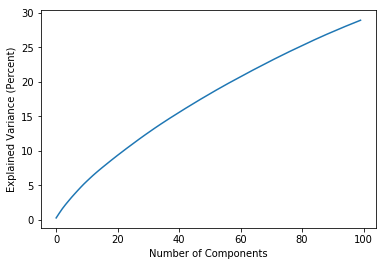

In [173]:
## FIGURE OUT HOW MANY COMPONENTS TO USE

plt.plot(var1)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance (Percent)")

In [165]:
print(lsa_tfidf_data.shape)
print(lsa_tfidf_data)

(1292, 40)
[[ 0.10472225 -0.0048978  -0.04909307 ... -0.03128691  0.03129711
  -0.03847326]
 [ 0.03100661  0.00069225 -0.01259824 ...  0.14086049 -0.00767591
   0.03544233]
 [ 0.05477166  0.00047335 -0.01447873 ...  0.01659444 -0.00397455
   0.04450769]
 ...
 [ 0.15169387 -0.00789031  0.00357425 ...  0.11163026  0.00725039
   0.05154662]
 [ 0.00827038 -0.00018834 -0.00380438 ... -0.00551161  0.00232353
  -0.01601252]
 [ 0.150318    0.00128687  0.00731659 ...  0.11047017  0.00395726
   0.05070968]]


In [166]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, verbose=1, perplexity=50).fit_transform(lsa_tfidf_data)
X_embedded.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1292 samples in 0.002s...
[t-SNE] Computed neighbors for 1292 samples in 0.186s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1292
[t-SNE] Computed conditional probabilities for sample 1292 / 1292
[t-SNE] Mean sigma: 0.043600
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.757507
[t-SNE] Error after 1000 iterations: 1.191831


(1292, 2)

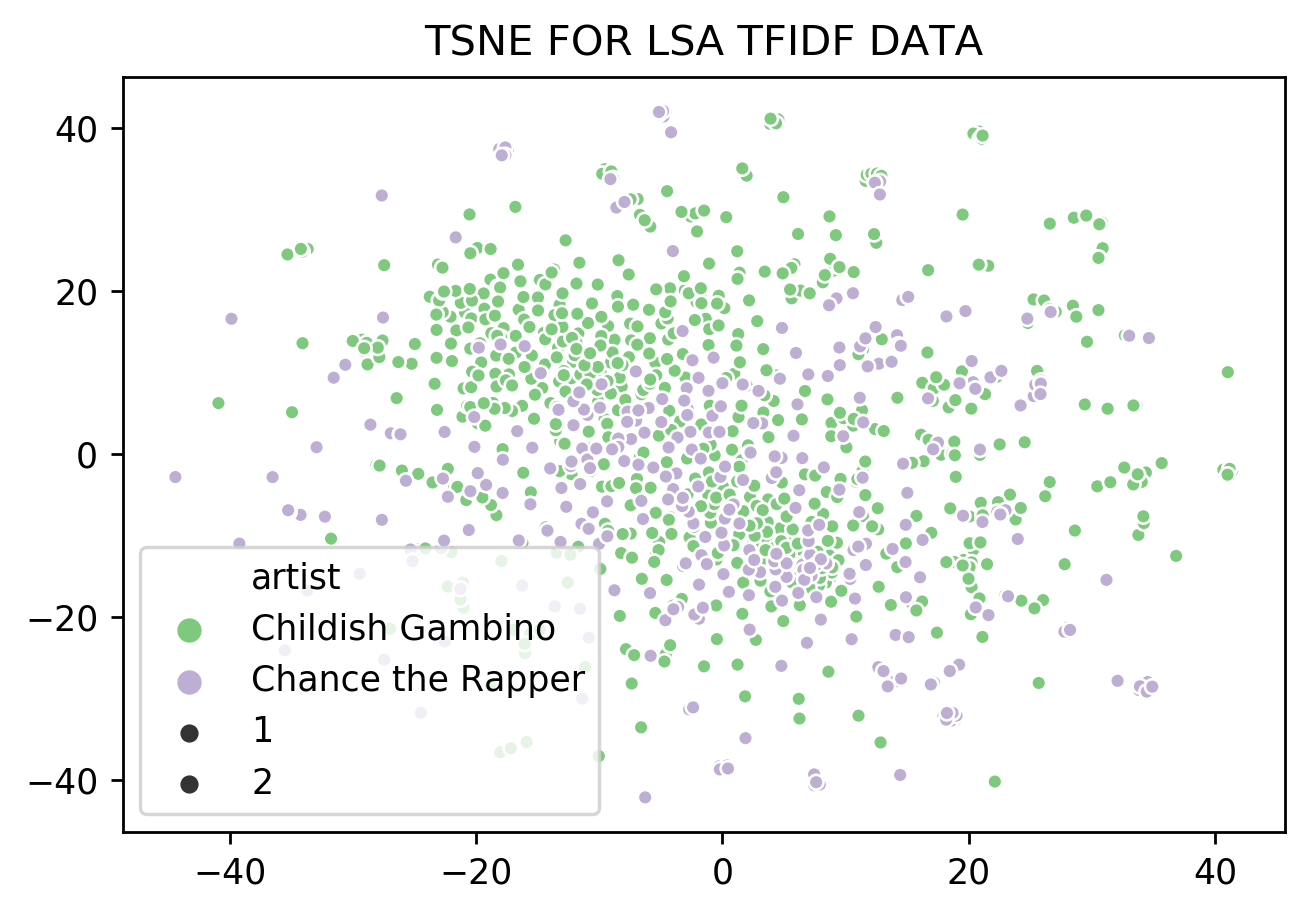

In [167]:
artists = model_df.artist
plt.figure(dpi=250)
plt.title("TSNE FOR LSA TFIDF DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], artists,
               size = 2, palette = 'Accent', alpha = 'auto',
              markers = '.');

In [31]:
artists.value_counts()

Childish Gambino     824
Chance the Rapper    468
Name: artist, dtype: int64

In [105]:
# nmf_cv DIMENSIONALITY REDUCTION ON CV
# Make the other two

n_comp = 40
nmf_cv = NMF(n_components=n_comp)

nmf_cv_data = nmf_cv.fit_transform(cv_data)
rapper = model_df.rapper

display_topics(nmf_cv,count_vectorizer.get_feature_names(),15)


Topic  0
ring, ring ring, hugh, buzzer, ring buzzer, buzzer hugh, hugh ring, hugh hugh, buzzer ring, chance, ring chance, chance ring, bink, ll, bink bink

Topic  1
cam, cam cam, ta cam, ta, cam ta, cam lotta, lotta, lotta ta, got, mamma, got ta, animal, mamma mamma, story, dash

Topic  2
wan, wan wan, mo, mo mo, mo wan, wan mo, everybody, wan wa, wa, wa wan, mama, outside, thank, wan thank, everybody wan

Topic  3
juke, juke juke, break, town, chi, chi town, town break, break chi, break break, juke break, break juke, angel, mami, live power, gci

Topic  4
love, love love, ove love, ove, lo ove, love lo, lo, say love, love say, love baby, ohh, ohh love, love ohh, baby love, eye

Topic  5
man, man let, let, let man, man man, old, halloween man, tick treat, treat man, let tick, tick, treat, old man, corner, flow

Topic  6
need, need need, ve shine, shine need, matter ve, wan right, really wan, old, shine, old man, seat, need really, ve, song, corner

Topic  7
cause, time, make, kid, gir

In [106]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=30).fit_transform(nmf_cv_data)
X_embedded.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1292 samples in 0.003s...
[t-SNE] Computed neighbors for 1292 samples in 0.155s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1292
[t-SNE] Computed conditional probabilities for sample 1292 / 1292
[t-SNE] Mean sigma: 0.000786
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.183388
[t-SNE] Error after 1000 iterations: 1.052457


(1292, 2)

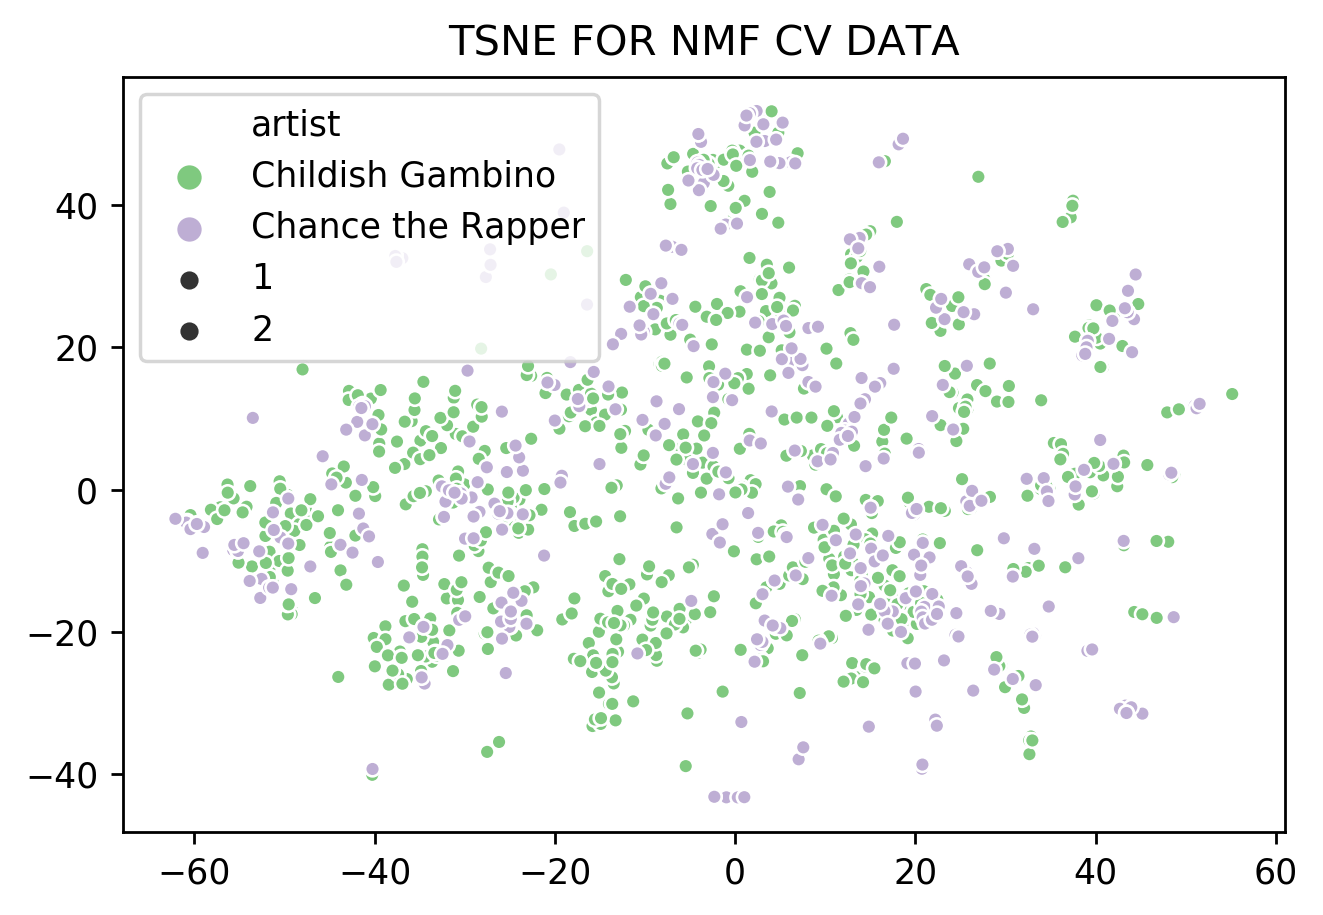

In [107]:
artists = model_df.artist
plt.figure(dpi=250)
plt.title("TSNE FOR NMF CV DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], artists,
               size = 2, palette = 'Accent', alpha = 'auto',
              markers = '.');

In [101]:
# lsa_cv DIMENSIONALITY REDUCTION ON CV

n_comp = 40
lsa_cv = TruncatedSVD(n_components=n_comp)

lsa_cv_data = lsa_cv.fit_transform(cv_data)

var_cv = lsa_cv.explained_variance_ratio_

var_cv1 = np.cumsum(np.round(lsa_cv.explained_variance_ratio_, decimals=4)*100)

display_topics(lsa_cv,count_vectorizer.get_feature_names(),15)


Topic  0
ring, ring ring, hugh, buzzer, ring buzzer, hugh ring, buzzer hugh, hugh hugh, buzzer ring, chance, ring chance, chance ring, ai, man, love

Topic  1
cam, cam cam, ta, ta cam, cam ta, lotta ta, lotta, cam lotta, love, man, wan, ai, make, let, say

Topic  2
juke, wan, juke juke, love, wan wan, love love, break, mo, man, need, say, town, chi, chi town, town break

Topic  3
juke, juke juke, break, chi town, town break, break chi, chi, town, break break, juke break, break juke, ring ring, angel, mami, power angel

Topic  4
love, love love, need, say, man, let, ove, ove love, lo, lo ove, love lo, ai, need need, cause, say love

Topic  5
need, man, need need, let, ai, black, make, cause, money, say, black man, tell, man let, let man, girl

Topic  6
need, need need, love love, wan wan, love, wan, mo, mo mo, mo wan, wan mo, juke juke, juke, shine need, matter ve, ve shine

Topic  7
man, let, man let, let man, need need, man man, black man, love love, wan wan, halloween, let halloween

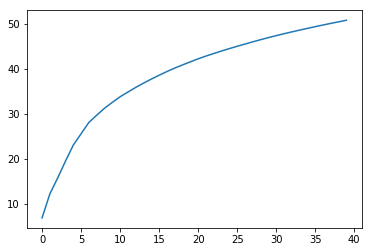

In [102]:
## FIGURE OUT HOW MANY COMPONENTS TO USE

plt.plot(var_cv1)

In [103]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=50).fit_transform(lsa_cv_data)
X_embedded.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1292 samples in 0.001s...
[t-SNE] Computed neighbors for 1292 samples in 0.180s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1292
[t-SNE] Computed conditional probabilities for sample 1292 / 1292
[t-SNE] Mean sigma: 0.160024
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.722137
[t-SNE] Error after 1000 iterations: 1.077227


(1292, 2)

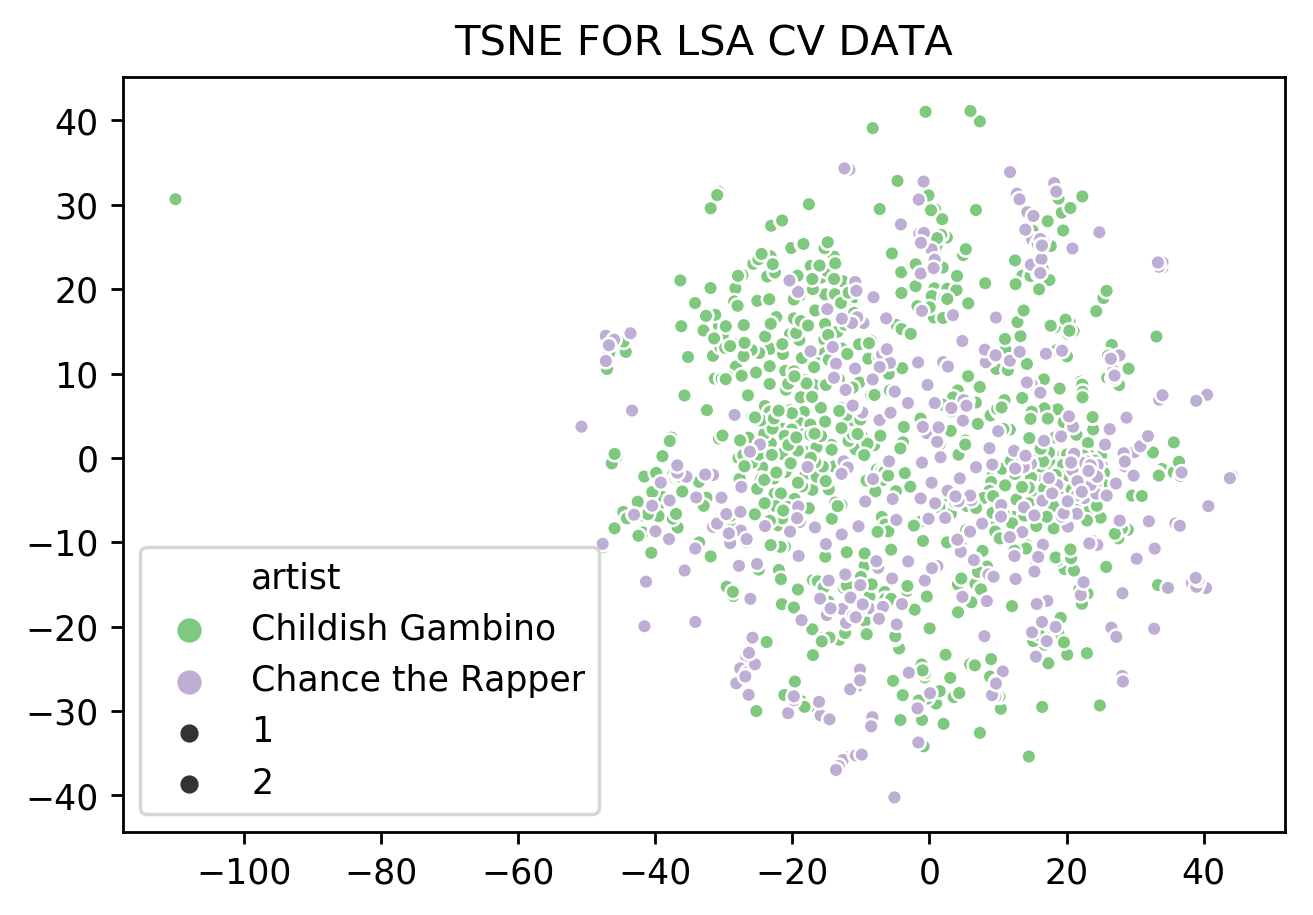

In [104]:
artists = model_df.artist
plt.figure(dpi=250)
plt.title("TSNE FOR LSA CV DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], artists,
               size = 2, palette = 'Accent', alpha = 'auto',
              markers = '.');

In [108]:
## LDA WITH TFIDF

n_comp = 15
lda_tfidf = LatentDirichletAllocation(n_components=n_comp)

lda_tfidf_data = lda_tfidf.fit_transform(tfidf_data)

# var = lda_tfidf.explained_variance_ratio_

# var1 = np.cumsum(np.round(lda_tfidf.explained_variance_ratio_, decimals=4)*100)

display_topics(lda_tfidf,tfidf_vectorizer.get_feature_names(),15)


Topic  0
hide terrify, terrify, hide, spin spin, spin, terrify hide, god need, type, auernheimer, andrew, andrew auernheimer, black renaissance, renaissance wack, wack type, type type

Topic  1
black man, internet explorer, explorer, internet, yes, grindin, yes hard, hard wo, black, explorer internet, man, wo, wo stop, man black, outside

Topic  2
igh, need need, igh igh, need, come, come come, feel good, make feel, stay wake, gon, creepin, wake creepin, wake, stay, good make

Topic  3
fly, girl fly, fly girl, wee, fly fly, hold hold, wee wee, worldstar, yay, yay thirsty, girl, thirsty, save christmas, save friends, christmas save

Topic  4
nanananana, angels, let lose, lose, nanananana nanananana, ahhh, really love, bam, light turn, time really, word brother, brother time, love hard, let, yah

Topic  5
strong, tall strong, strong fall, dream stand, stand tall, red alert, alert, tall, red, calling haters, alert red, world red, haters world, calling, stand

Topic  6
love love, love, in

In [109]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=50).fit_transform(lda_tfidf_data)
X_embedded.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1292 samples in 0.001s...
[t-SNE] Computed neighbors for 1292 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1292
[t-SNE] Computed conditional probabilities for sample 1292 / 1292
[t-SNE] Mean sigma: 0.005675
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.574226
[t-SNE] Error after 1000 iterations: 0.154342


(1292, 2)

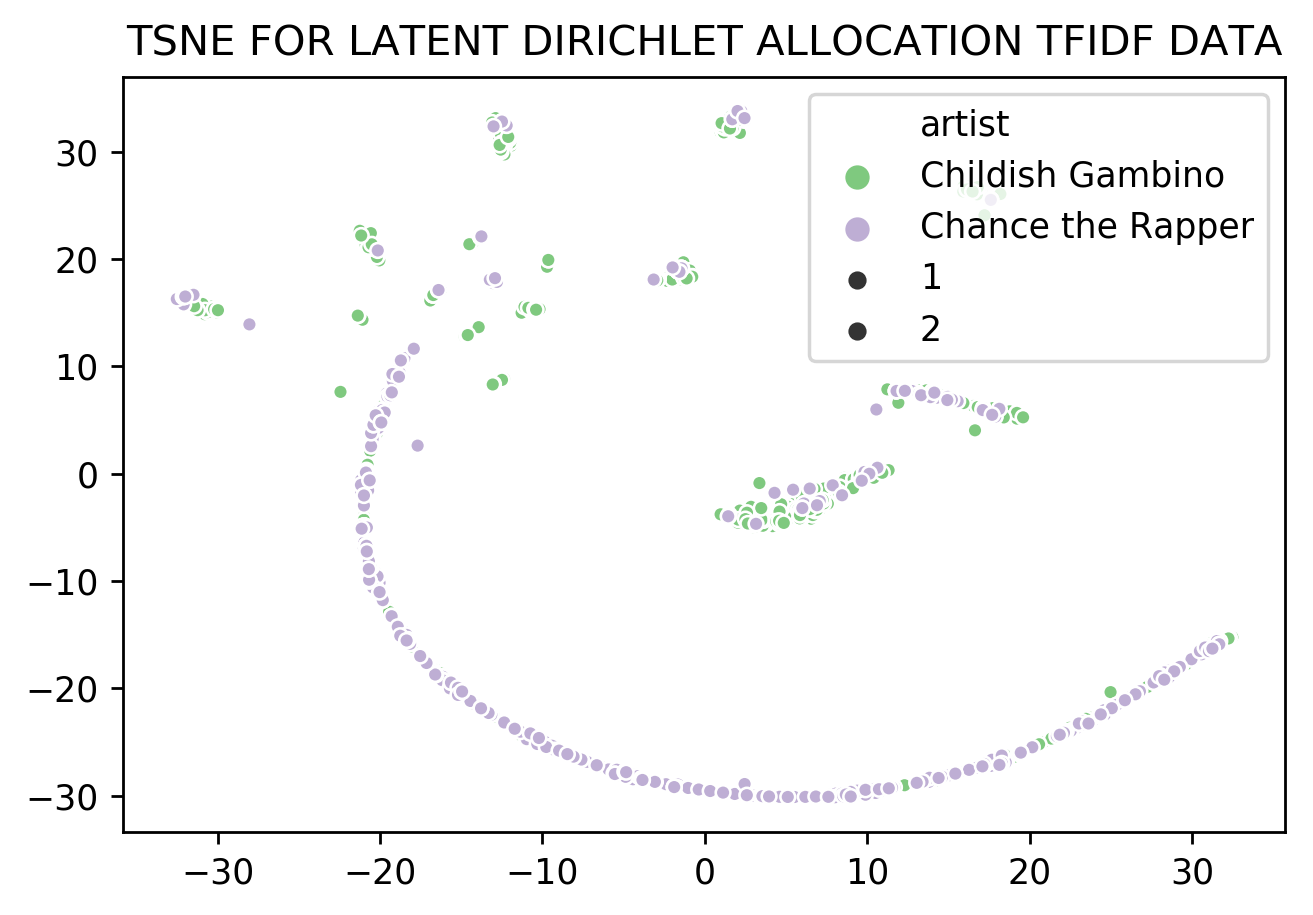

In [110]:
artists = model_df.artist
plt.figure(dpi=250)
plt.title("TSNE FOR LATENT DIRICHLET ALLOCATION TFIDF DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], artists,
               size = 2, palette = 'Accent', alpha = 'auto',
              markers = '.');

In [111]:
## LDA WITH CV

n_comp = 15
lda_cv = LatentDirichletAllocation(n_components=n_comp)

lda_cv_data = lda_cv.fit_transform(cv_data)

# var = lda_tfidf.explained_variance_ratio_

# var1 = np.cumsum(np.round(lda_tfidf.explained_variance_ratio_, decimals=4)*100)

display_topics(lda_cv,count_vectorizer.get_feature_names(),15)


Topic  0
ring, ring ring, bom, bom bom, sunshine, hugh, music, body, ring buzzer, buzzer, hugh ring, buzzer hugh, perfect, thottie, perfect thottie

Topic  1
cam, cam cam, ca, hoodie, summer, speak, ca speak, heartbeat, callin, hope work, winter, glow, summer summer, spring, fore

Topic  2
money, man, black, black man, money baby, baby money, man black, tell, man let, money black, let man, grandma, money money, til, worldstar

Topic  3
talm, talm bout, bout talm, everyday, wonderful, look, deserve, night, better, maybe, deserve deserve, tight sweater, people people, maybe night, break

Topic  4
need, juke, juke juke, need need, smoke, hold, break, outside, halloween, road, town, chi town, chi, halloween let, town break

Topic  5
let, gon, city bitch, sleep hat, hennessy, daughters, bitch sleep, moses, polos, love city, laugh say, agent, underground tubman, sal wall, shirt polos

Topic  6
igh, better, fu, igh igh, fu fu, citywide, citywide citywide, got grind, catch, say, slippin, catc

In [112]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=50).fit_transform(lda_cv_data)
X_embedded.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1292 samples in 0.001s...
[t-SNE] Computed neighbors for 1292 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1292
[t-SNE] Computed conditional probabilities for sample 1292 / 1292
[t-SNE] Mean sigma: 0.007953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.259289
[t-SNE] Error after 1000 iterations: 0.116348


(1292, 2)

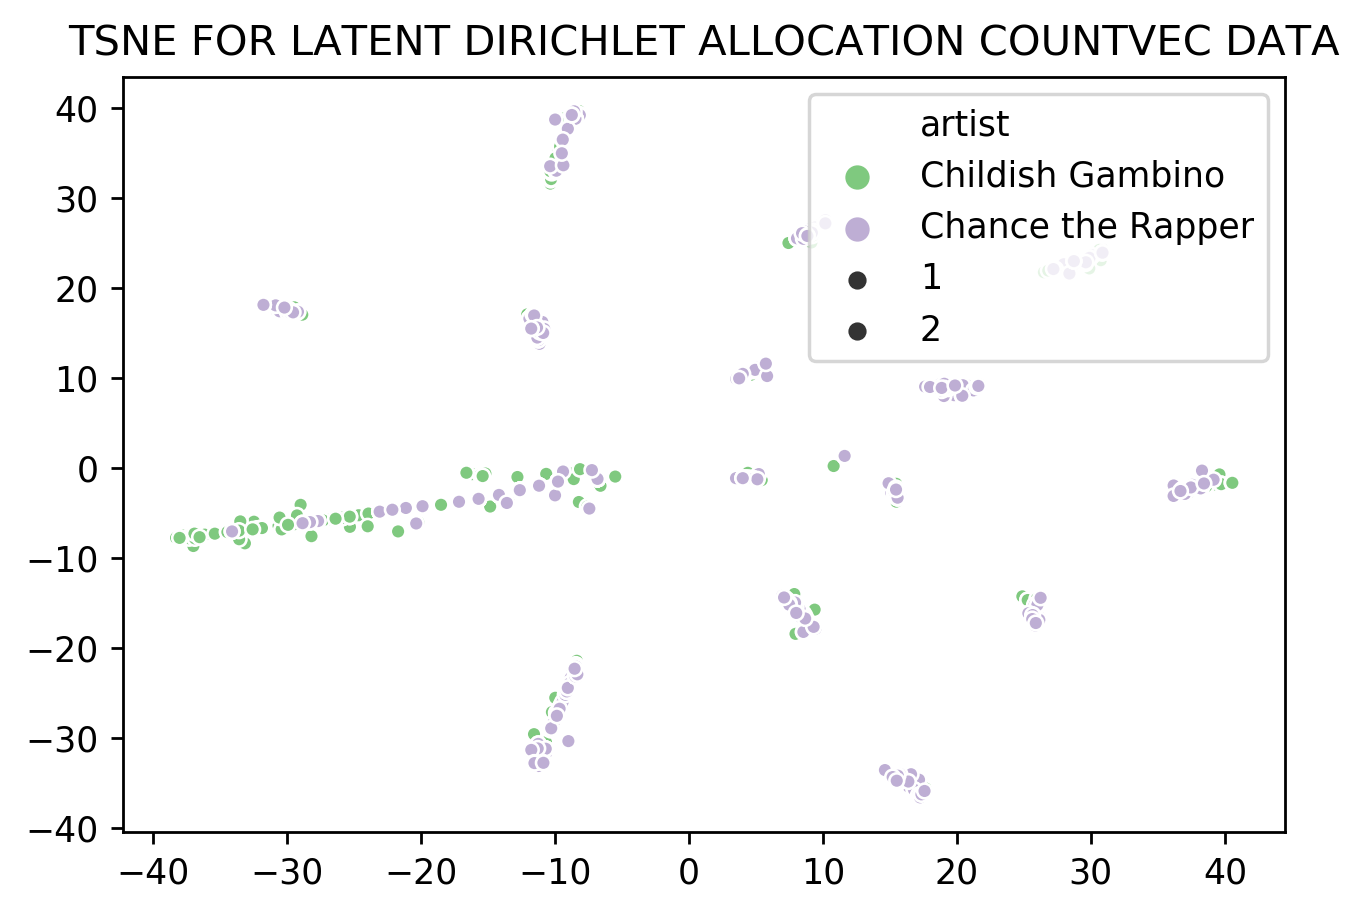

In [113]:
artists = model_df.artist
plt.figure(dpi=250)
plt.title("TSNE FOR LATENT DIRICHLET ALLOCATION COUNTVEC DATA")
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], artists,
               size = 2, palette = 'Accent', alpha = 'auto',
              markers = '.');

In [ ]:
model_df[model_df]

In [90]:
## PICKLE TRUNCATED SVD ON TFIDF_DATA SO YOU DON'T HAVE TO REFIT IT EACH TIME

# with open('models/lsa_tfidf.pkl', 'wb') as picklefile:
#     pickle.dump(lsa_tfidf, picklefile)

In [136]:
rec_list = get_recommendations(model_df.verse_lem[900], lda_tfidf, tfidf_vectorizer, lda_tfidf_data)
recommendations_correct(900,rec_list)

Chance the Rapper
We never rolled at the Rink, we would just go to the Rink, You ain't buy tokens no more, you just hip roll at the Rink, You had a nigga, I couldn't stand him, But when they play "Take You Down", Chris Brown, I am his stand-in, I mean it's just dancing, it's harmless as fuck, Then I put my waist through your hips and your legs in my arms just to harness you up, Then we hit the floor, all the kiddies stop skating, To see grown folks do, what grown folks do when they grown and they dating

------



60.0

In [151]:
percent_corr = []

for i in range(len(model_df)):
    rec_list = get_recommendations(model_df.verse_lem[i], lda_tfidf, tfidf_vectorizer, lda_tfidf_data)
    percent_corr.append(recommendations_correct(i,rec_list))

Childish Gambino
We just wanna party, Party just for you, We just want the money, Money just for you (yeah), I know you wanna party, Party just for free, Girl, you got me dancin' (girl, you got me dancin'), Dance and shake the frame (yeah), We just wanna party (yeah), Party just for you (yeah), We just want the money (yeah), Money just for you (you), I know you wanna party (yeah), Party just for free (yeah), Girl, you got me dancin' (girl, you got me dancin', yeah), Dance and shake the frame (ooh)

------

Childish Gambino
This is America, Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now, This is America (woo), Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now

------

Childish Gambino
This is America (skrrt, skrrt, woo), Don't catch you slippin' now (ayy), Look how I'm livin' now, Police be trippin' now (woo), Yeah, this is America (woo, ayy), Guns in my area (word, my area), I got the strap (ayy, ayy), I gotta

Childish Gambino
I'm in love when we are smoking that la-la-la-la-la, I'm in love when we are smoking that la-la-la-la-la, I'm in love when we are smoking that la-la-la-la-la, I'm in love when we are smoking that la-la-la-la-la, I'm in love when we are smoking that la-la-la-la-la, I'm in love when we are smoking that la-la-la-la-la, I'm in love when we are smoking that la-la-la-la-la, I'm in love when we are smoking that la-la-la-la-la

------

Childish Gambino
Do what you want, I'm telling you, Let me into your heart

------

Childish Gambino
Can't stand it, backhanded, They wanna see us falling apart, You know that I love you, So let me into you

------

Childish Gambino
Let me into your heart, (Do you really love me?, I'ma get you, girl, ahhh!)

------

Childish Gambino
This is the end of us, Sleeping with the moon and the stars, I know where you've been, You can see the sun

------

Childish Gambino
Let me into your heart, Oh, this ain't no bullshit, I really love you, girl, Oh, oh

Childish Gambino
Let 'em speak, I know I'm meek but the mills louder, Watch the throne, kings kill when the prince feels power, It's the real deal, Holyfield, holy shit, holy grail, Silver spoon coon, young buffoon, yeah, they know me well, I'm makin' moves, couldn't lose, doin' Parker Lewis, Hot on my own, self-immolate, I could be a Buddhist, Hot on my own, check your tone, check your stance homie, You don't even like me, you just trynna get my fans homie, So nerdy but the flow wordy, Brain-freezin' with the flow slurpie, Ice cold but you know I burn cash like I had herpes, Not true, but I'm that dirty, Niggas quit bein' hot man, cold turkey, While I'm out in Kauai, man, soul searchin', And these niggas be afraid and I'm so certain, Cause they don't know what to do when the world's broken, A lot of people try and go and talk shit but your girl stops me on the street, Like it's stop and frisk and a bunch of DDots wanna talk a lot of shit, But that's cool cause in the real world they r

Childish Gambino
Baby girl, you know what I want, Let me do it to ya, do it to ya, Let me do ya like, Uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, Uh, uh, uh, uh, uh, uh, uh, uh, Baby girl, you know what I want, Let me do it to ya, do it to ya, Let me do ya like, Uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, Uh, uh, uh, uh, uh, uh, uh, uh

------

Childish Gambino
"It ain't tricking if ya" you know, "baby, I" you know, Mama, you are with the right man, Juno, Tell me what you wanna do, I will make it happen, I just wanna get you home and uh, uh, uh, uh, oh, Yes, I'm drinking whiskey, baby I am gone tonight, NBC is not the only thing I'm coming on tonight, Gross, why the fuck I say these things?, It isn't over, haven't heard the chubby lady sing, Everybody love me, call a nigga Raymond, These weak niggas always in your face like Raybans, Yes, I bring the heat, girl, fire for fireman, Baby, I'm your hero, Donald for Spiderman, I'm in love with you, but this is not tennis, And baby stay stacked like 

Childish Gambino
I'm spinning, I'm spinning, I'm spinning you up, I'm spinning, I'm spinning, I'm spinning you up, I'm spinning, I'm spinning, I'm spinning you up, I'm spinning, I'm spinning, I'm spinning you up, I'm spinning, I'm spinning, I'm spinning you up, I'm spinning, I'm spinning, I'm spinning you up, I'm spinning, I'm spinning, I'm spinning you up, I'm spinning, I'm spinning, I'm spinning you up

------

Childish Gambino
Just hide, ooh!, You know that you're the one that's terrified, ooh, Just hide, ooh!, You know that you're the one, that's terrified, ooh

------

Childish Gambino
She want to move to California, She must've fucking lost her mind, She want to move to California, That's how they get you every time

------

Childish Gambino
She make a movie with her friends, Put it up in a minute, Everybody say it now, Ain't no loop at the minute, Everybody saying, "How, how you do it, you did it?", I'ma show you what it done, But enough for a finish, Pay attention, you listen, 

Childish Gambino
I ain't no snitch, cops, I don't trust 'em, I ain't no bitch, all I do is run 'em, I ain't—I ain't no snitch, cops, I don't trust 'em, I ain't no bitch, all I do is run 'em, Nigga, I was stuntin', keep that shit a hundred, If it ain't about the money, then it's not up for discussion, If it ain't about—

------

Childish Gambino
After selling out the Georgia Dome 3 nights in a row, After selling 10 million copies of his newest album, Roscoe's Wetsuit in one week!, After successfully petitioning to recarve his own face into Stone Mountain (yeah, yeah) (Stone Mountain), He's still givin' you niggas a free mixtape?, Why, Gambino? Why young guy? Why so generous?

------

Childish Gambino
I ain't no snitch, cops I don't trust 'em, I ain't no bitch, all I do is run 'em (It's Royalty!), Nigga, I was stuntin', keep that shit a hunnid, If it ain't about the money then it's not up for discussion, If it ain't about progress, ain't about success, Why this nigga suspect? You ain't s

Childish Gambino
Slide baby, I'm gonna let it go, No one has to know so let it..., Slide baby, I'm gonna let it go, No has to (no one—no one), Slide baby... WOW

------

Childish Gambino
You feel like summertime, You took this heart of mine, You'll be my valentine in the summer, in the summer, You are my only one, Just dancin'; having fun, Out in the shinin' sun of the summer, of the summer

------

Childish Gambino
Do love me, do love me, do, Do love me, do love me, do (yeah), I love you, Do love me, do love me, do, Do love me, do love me, do (ohh), Put no one else above you, Do love me, do love me, do, Do love me, do love me, do (yeah), I need you, Do love me, do love me, do, Do love me, do love me, do (ohh), Oh!, Do love me, do love me, do, Do love me, do love me, do, I love you, Do love me, do love me, do, Do love me, do love me, do, Put no one else above you, Do love me, do love me, do (ohh), Do love me, do love me, do, I need you, Do love me, do love me, do, Do love me, do love m

Childish Gambino
Welcome to the culdesac, this is where the street ends, I am just a rapper, I ain't got the time for speakin', Nigga stay weak like tornado and a tree branch, I never have a weak day, my life's a long weekend, Fuckin' with ya raw, bitch. My mouth should get tested, Sleepin' on a nigga, hope you feel well rested, Gambino stay on, can't nobody pull the cord out, A nigga fucked up, like a hang gliding whore house, Sick boy, yeah, the clique on deck, Yes, I rap absurd. Got the game upset, And they rap about the jewelry, the weed they smoke, And I rap about my life, and niggas think it's a joke, nah, I only put real on a nigga, Bitches see the money, try and steal on a nigga, Yes, I'm on fire, you can feel it on a nigga, Step away from the heat; they Shaquillin' on a nigga, Treat niggas like pussy, go hard on 'em, Watch the swagga get swiped like a card, bottom, The swag's unique, I don't even worry 'bout 'em, I got the tortoise shell frames and the argyle, You wouldn't thi

Childish Gambino
This... is Blake Griffin. This... is royalty

------

Childish Gambino
(It's royalty! It's Royalty...)

------

Childish Gambino
This is exactly what I wanted, All my fans love me, dad is proud of me, Momma cries for me, Cause she know there ain't sleep in my schedule, Having nightmares that I'm the black Heath Ledger, Sleep when I'm dead, These voices in my head, Got me waking up at 4 just so I can write instead, And my friends come and ask me if it's worth it, I tell them that "It better be, I did this shit on purpose!", The worst is being worthless, Now a nigga priceless, Bloomingdale's coat, I don't have to check the prices, But I only go to feel a sense of control, Cause I get this shit for free if I wear promotional, And I'm not emotional when I do my work, I get emotional when I order that dessert, Cause she always ate dessert, And I deserted her, But I refuse to compromise career for a girl, Cause this music and this writing and this acting is my soul, And if I

Childish Gambino
You make me feel, feel so shiny and new, Like I'll never be blue again, And the magic moment feels so right, I wanna spend the rest of my life with you oooh!

------

Childish Gambino
Why you always mad at me, I was gon come right back, Fucking with them fly girls, that was only chit chat, It's part of my job, yes I'm young and charming, And I smell like money so these girls are all up on me, Let's have bygones be bygones, they don't know what they're doing like a cylon, Trying to get my python, you can check my iPhone, Rolodex Gchat, When you come over all I ask is "Where my V at?", Like I work at ABC, look at me rambling, You can be a pimp, these girls making money but they'll never make sense, Half of yall crazy, the other half trying to get their paper having babies, Naw I ain't down with that "Hooohh!" like a thundercat, Try to poke holes in the base where I keep soldiers at, Sneaky like a Cheshire cat, sneaky like a baby sneaker, One of these girls got my number 

Childish Gambino
Whatever I did, girl, forget about it, Whatever I said, girl, just forget about it, Whatever I do, girl, just forget about it all night long, Yeah, oh

------

Childish Gambino
Everybody put your hands up, Clap them together, Clap them together for me, All night long

------

Childish Gambino
You know what I did, It doesn't matter, You know that I'll always be better, Times are crazy, And you know it, That's how I show you that I care

------

Childish Gambino
Whatever I did, girl, forget about it, Whatever I said, girl, just forget about it, Whatever I do, girl, just forget about it all night long, Yeah, oh

------

Childish Gambino
Everybody put their hands up

------

Childish Gambino
You know what I did, it doesn't matter, You know that I'll always be better, Sometimes I'm crazy, and you know it, That's how I show you that I care

------

Childish Gambino
Whatever I did, girl, forget about it, Whatever I said, girl, just forget about it, Whatever I do, girl, just f

Childish Gambino
If we're together, Can do whatever, I'll make sure that you're close to me, Cause baby girl it's a fantasy, As long as you are here with me tonight

------

Childish Gambino
Cause I want ya, Cause I need ya girl, Cause I want ya, Cause I need ya girl, yeah

------

Childish Gambino
I bless the rains down in Africa X3

------

Childish Gambino
I'm so drunk tonight and I, I don't got nowhere to go, I'm so drunk tonight and I, I don't got nowhere to go, I'm so drunk tonight and I, I don't got nowhere to go, I'm so drunk tonight and I, I don't got nowhere to go

------

Childish Gambino
I'm so drunk tonight and I, I don't got nowhere to go, I'm so drunk tonight and I, I don't got nowhere to go, I'm so drunk tonight and I, I don't got nowhere to go, I'm so drunk tonight and I, I don't got nowhere to go

------

Childish Gambino
He stood in front of me, Everything that I was and what I wanna be, Shots fired, over a hundred G's, And if it wasn't be you, then who's it gonna be

Childish Gambino
What the fuck do y'all niggas really want?, I went with realness instead, But all the real niggas I know either crazy or dead, Yeah, I dropped the free EP for these other kids to feel a lot, And niggas keep asking on whether this dude's for real or not, I'm not trying to come hard, I'm trying to come me, That's why these older songs that I used to make I'd release free, What's the point of rap if you can't be yourself, huh?, That's why I come first like my cell phone, I'm a role model, I am not these other guys, I rap about my dick and talk about what girls is fly, I know it's dumb, that's the fucking reason I'm doing it, So why does everyone have a problem with talking stupid shit?, Or is it real shit?, 'Cause sometimes that stupid shit is real shit, Like when you make out with your best friend's baby sis, You know the one with short hair you used to babysit?, (See, that's not even right), You with a different girl like each and every fucking night, And kiss her while

Chance the Rapper
My druggy, Love me, When I'm ugly, Hug me, When I'm bummy, scummy, I'm your hubby, Let's get lost, let's get lost

------

Chance the Rapper
Damn, I'm in so deep, girl, Probably 'cause you're empty, You can't even speak (IGH!), Damn, your mouth so minty, Ooh your mama hate me, Daddy wouldn't let you, if he ever met me, If he ever met you, Put that shit behind us, And put this in your sinus, Mine is all up in my gums, Minus all that shit it's lined with, I say oh oh oh ohh, You been scratchin', you been fiendin', I'mma fix you, I'mma fuck you, I'mma get rid of them demons, It's my

------

Chance the Rapper
My druggy, When I'm ugly, Hug me, When I'm bummy, scummy, I'm your hubby, Let's get lost, let's get lost

------

Chance the Rapper
Damn, I need a minute... aight, lehgo, She fell in love, it fell apart... aight, let go, She met her match, I let her match, She lit her match, she let me smoke, Yeah me mad petty, yeah me bogus, Yeah yeah yeah yeah yeah me know, Yeah s

Chance the Rapper
All I can hear is the third, ayy, All I can hear is the third, ayy, We don't know none of your words, ayy, We don't know none of your words, ayy, I love my women real tall, ayy, Type that can really play ball, ayy, You buy my hat at the park, ayy, Think I might really play ball, ayy, I got a link in my bio, My bitch do the salsa like pico de gallo, They gotta ask if they may, Cinco de Mayo, How can they call themselves bosses, When they got so many bosses, You gotta see what your boss say, I get it straight out the faucet, I ain't felt like this since the third Drought, third Carter drop, Told my momma third grade I'd be in the third Barbershop, And yeah, my momma got real worried when she heard college drop, But now I call the shots

------

Chance the Rapper
I'm the only nigga still care about mixtapes, Bad little bitch wanna know how lips taste, I swear I'm the only nigga still cares about mixtapes, Bad little bitch wanna know how lips taste

------

Chance the Rap

Chance the Rapper
This is six blunt rotation music, This is just got off six month probation music, This is steppin' on the beach, When you're too drunk to feel a beat, This that laughing in a condo, Throwin' shit down in the street, This that shouts to the Ave, shouts to the lab, Shouts to the clucks, shouts to the strags, This for every math class that I ever had, So fuck you if I failed, and fuck you if I passed!, For shitty summaries and bummers in the past, Cause some of our teachers act as if summer was for class, Some of us is seeing summer, some of us have passed, Some of us ain't seeing summer, some of us have passed, So I'm just glad to say I'm sippin' rum up out a glass, Cause some of us is only sippin' some up off the grav, And heaven's gates look a lot like prison from the Ave, We on the ground yelling, "Give my nigga back!"

------

Chance the Rapper
And I just want to roll with my windows down, And I just want to roll with my windows down

------

Chance the Rapper
This 

Chance the Rapper
I count my blessings too often, My best friends on one hand, My sheep when I’m done here, Gotta get up, get up, I count my blessings too often, My best friends on one hand, My sheep when I’m done here, Gotta get up, get up

------

Chance the Rapper
Knock knock said the fist to the world, Shine sun through the mist and debris, Bang bang said the fist to the young, Silence from the lips of the free, Say something important, say something important, Make money the end of the week, But that shit coming soon, I’m getting hungry, Might sell out in a couple of weeks, But my crib they buckin’, And they just called Buddy, that’s lil bro, Even though last time we spoke, We was arguing, but we still stay close, Ask God to watch the squad, On God, battle niggas to the death, alright, Fuck your squad and the whole facade, I ain’t never scared of where a nigga reside, Extra mild sauce on the side, extra mileage on the ride, Express, I'mma grab my chain, Cause it’s extra violence a

Chance the Rapper
I'm just a soul that borrowed the bod, I have no quarrel with God, Keep my eye on the sparrow until I'm sparrin' with Rod, I will not spoil when I'm hot, I'm just gon' boil this pot, Moistenin' soil and plant sequoias that's tall enough, That they foil your plot, I am not royalty or giant, just a boy with a rock, Employer of lawyers, boy oh boy, it ain't no boy in me, ma, The work is over, you should sit back and enjoy your seat, ma, I'm buyin' groceries and toys and baby toilet seats, ma, I'm s'posed to teach 'em and feed 'em and give 'em help when they're readin', And give 'em hugs after beatings and give 'em love after love, I'm Hallmark and Walmart just for you, And if it fall apart or it's all dark, I'm a wall charger or a call card, Or a cab co, or a golf cart just for you, We a ballpark, just the two, You're a Gamestop, I'm a Paul Blart, just not two, Thinkin' back on my rap shit, my mini afro black shit, That na-na-na-na bo squad got my back shit, Nathan, Pete

Chance the Rapper
We never rolled at the Rink, We would just go to the Rink, You ain't buy tokens no more, You just hip roll at the Rink, You had a nigga, I couldn't stand him, But when they play "Take You Down", Chris Brown, I am his stand-in, I mean it's just dancing, It's harmless as fuck, Then I put my waist through your hips, And your legs and my arms just to harness you up, Then we hit the floor, All the kiddies stop skating, To see grown folks do, what grown folks do, When they grown and they dating

------

Chance the Rapper
Yeah, Oh, yeah y'all gon' let [?], Swear y'all gon' [?], Sing it, uh

------

Chance the Rapper
I burned too many brain cells down, To be worried 'bout my brain cells now, oh no, I burned too many brain cells down, To be worried 'bout my brain cells now, oh no, I burned too many brain cells down, To be worried 'bout my brain cells now, I burned too many brain cells down, Down, down, down-down, uh

------

Chance the Rapper
Uh, here’s a tab of acid for your 

In [152]:
percent_corr

[100.0,
 20.0,
 30.0,
 100.0,
 70.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 60.0,
 100.0,
 100.0,
 40.0,
 100.0,
 100.0,
 100.0,
 40.0,
 100.0,
 100.0,
 90.0,
 70.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 60.0,
 100.0,
 100.0,
 100.0,
 70.0,
 100.0,
 50.0,
 100.0,
 100.0,
 50.0,
 100.0,
 100.0,
 100.0,
 90.0,
 60.0,
 100.0,
 60.0,
 100.0,
 60.0,
 100.0,
 90.0,
 100.0,
 90.0,
 100.0,
 90.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 90.0,
 80.0,
 100.0,
 80.0,
 100.0,
 80.0,
 80.0,
 40.0,
 100.0,
 100.0,
 90.0,
 100.0,
 90.0,
 30.0,
 100.0,
 100.0,
 100.0,
 40.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 60.0,
 80.0,
 100.0,
 70.0,
 100.0,
 60.0,
 60.0,
 60.0,
 100.0,
 60.0,
 20.0,
 60.0,
 100.0,
 100.0,
 90.0,
 100.0,
 100.0,
 100.0,
 90.0,
 70.0,
 100.0,
 100.0,
 70.0,
 100.0,
 100.0,
 70.0,
 60.0,
 100.0,
 30.0,
 40.0,
 80.0,
 100.0,
 100.0,
 20.0,
 70.0,
 70.0,
 80.0,
 100.0,
 60.0,
 70.0,
 100.0,
 90.0,
 90.0,
 100.0,

In [153]:
sum(percent_corr)/len(percent_corr)

66.64860681114551

In [168]:
percent_corr = []

for i in range(len(model_df)):
    rec_list = get_recommendations(model_df.verse_lem[i], lsa_tfidf, tfidf_vectorizer, lsa_tfidf_data)
    percent_corr.append(recommendations_correct(i,rec_list))

Childish Gambino
We just wanna party, Party just for you, We just want the money, Money just for you (yeah), I know you wanna party, Party just for free, Girl, you got me dancin' (girl, you got me dancin'), Dance and shake the frame (yeah), We just wanna party (yeah), Party just for you (yeah), We just want the money (yeah), Money just for you (you), I know you wanna party (yeah), Party just for free (yeah), Girl, you got me dancin' (girl, you got me dancin', yeah), Dance and shake the frame (ooh)

------

Childish Gambino
This is America, Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now, This is America (woo), Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now

------

Childish Gambino
This is America (skrrt, skrrt, woo), Don't catch you slippin' now (ayy), Look how I'm livin' now, Police be trippin' now (woo), Yeah, this is America (woo, ayy), Guns in my area (word, my area), I got the strap (ayy, ayy), I gotta

Childish Gambino
Different color, my passport; Instagram my stack load, Hashtag my day wear, and your girl drank my day care, And I'm born rich, life ain't fair – It's silver spoon coon, ho, Ain't nobody sicker in my Fisker, "vroom-vroom," ho, Ain't nobody—, (Fiskers don't make noise when they start up, just so you know), Top of the holy totem, R-r-r-rich forever, a million was not the quota, My father owned half the MoMA and did it with no diploma, Year off, got no rules, tripping off of them toadstools, More green than my Whole Foods and I'm too fly, Jeff Goldblum, Got a glass house in the Palisades, that AKA, White hood, white hood; O-KKK, Furniture custom, you shop at IKEA, Show Maserati, you whipping a Kia, Spending this money, it's longer than Nia, Live like a Coppola, me and Sofia, Waking up broke, man, wouldn't wanna be ya, Friends with the dopeman, help a nigga re-up, Bring a girlfriend, man, trouble when I see her, "Err-eh-err-eh", onomatopoeia, Oh, I got my cool on! (tailor-

Childish Gambino
"Power 106!, LA, it's ya girl, Yesi Ortiz, Got some brand-new music, I need y'all to turn it up and let me know what you think, It's Lloyd, called "Oakland", on Power 106."

------

Childish Gambino
Foot on the gas, I'm just trying to pass, All the red lights, And the stop signs, I'm ready to go, Before I get to The Bay, Babe, that's a problem, Because I'm way too scared to call, And you might get me to stay, and oh

------

Childish Gambino
I don't really mind the drive, But I think I'd rather die, In Oakland, in Oakland, With my hands on two and ten, So I guess it all depends, On Oakland, on Oakland, And I'm nervous, truth be told, I never saw me growing old, In Oakland, in Oakland, And if I married you tonight, It would probably start a riot, In Oakland, in Oakland

------

Childish Gambino
Everything, that I needed, Now that I got you in your feelings, Everything you won't say, you tweet it, And a nigga don’t like that shit at all, So treated, Can we just roll with

Childish Gambino
Can't stand it, backhanded, They wanna see us falling apart, You know that I love you, So let me into you

------

Childish Gambino
Let me into your heart, (Do you really love me?, I'ma get you, girl, ahhh!)

------

Childish Gambino
This is the end of us, Sleeping with the moon and the stars, I know where you've been, You can see the sun

------

Childish Gambino
Let me into your heart, Oh, this ain't no bullshit, I really love you, girl, Oh, oh God

------

Childish Gambino
Girl you really got a hold on me, So this isn't just puppy love, Girl you really got a hold on me, So this isn't just puppy love

------

Childish Gambino
I'm in love when we are smokin' that, Oh my God, I, Let me in, Girl you really got a hold, woo!

------

Childish Gambino
And now that's it's over, I'll never be sober, I couldn't believe, but now I'm so high, And now that's it's over, I'll never be sober, I couldn't believe, but now I'm so high, Now I'm so high, Now I'm so high, Now I'm so high

Childish Gambino
We are the dreams of our parents lost in the future, Who hide the deepest desires and wear a mask like a lucha—, Door, open, we were smoking in the hotel, The vapors went through the hallway, the manager pissed as hell, I mean, where's the line between Donnie G and Gambino?, He hang with girls like he Lena but needed some time to re-up, Tequila in the cantina, 30 dollars I swallowed, The Sauza so malo, then she said, "You need to grow up, You been doing this for too long, That Camp was a million years ago, sing me a different song", Whether you're trolling or controlling, just a reminder, You think you get it, you don't, it's that Andrew Auernheimer, I'm gone—Now I'm back, Give a fuck or give 'em hell, just not a chance to react, Tyler Durden, this burden hurting, they said there was curtains, Certain demise, look in his eyes, the pain inadvertent, I could've stayed where I was and have a life you'd be proud of, But I'd rather chase things never thought of, It was all 

Childish Gambino
Runnin this thang, money insane, Busy getting brain like Krang, What, what's my name?, In the woods, got these niggas usin' Mapquest, Man, fuck these backpackers, Fuck these backpackers, Fuck these backpackers, Fuck these backpackers

------

Childish Gambino
"I had a dream, I had a dream I was flying over all of us, There were so many pretty people, so many pretty faces, I talked to some birds, I fell in love again, And none of this ever ended, Everything just kept going, and going, and going, And even when you laughed, you cried, And even when you were sad, you were really happy, Cause you were here, and I got to meet every star, Every planet, everything that made me, And we all kissed, and became the same, We became the same, we became the same."

------

Childish Gambino
Who would have thought this? We almost lost it, When you lie inside darkness, it's hard to see, And we sleep in tradition, keep 'em off in the distance, To tell you that I haven't been

------

Chi

Childish Gambino
What the fuck do y’all niggas really want?, I went with realness instead, But all the real niggas I know either crazy or dead, Yeah, I dropped the free EP for these other kids to feel a lot, Niggas keep asking on whether this dude’s for real or not, I’m not trying to come hard, I’m trying to come me, That’s why these older songs that I used to make I’d release free, What’s the point of rap if you can’t be yourself, huh?, That’s why I come first like my cell phone, I’m a role model, I am not these other guys, I rap about my dick and talk about what girls is fly, I know it’s dumb, that’s the fucking reason I’m doing it, So why does everyone have a problem with talking stupid shit?, Or is it real shit?, ‘Cause sometimes that stupid shit is real shit, Like when you make out with your best friend’s baby sis, You know the one with short hair you used to babysit?, (See, that’s not even right), You with a different girl like each and every fucking night, And kiss her while she

Childish Gambino
We can go together, It doesn't really matter, (Cough), Oh, Yeah, 'Kay, one, two, three, go!, Oh, hey, Oh, hey, ah, One more time

------

Childish Gambino
Yeah nigga, it's me again, I'm still around, I guess I win, You hear me in your sister's room like all the time, "Gambino Girl forever!" on that bracelet that she bought online, To dudes who couldn't take it, might I say, "hasta luego", Cause I'm taking all your city like I'm Carmen San Diego, I'm smoking, I'm on fire, I am blazing, don't get hurt, To my white dudes, it's a concert, To my black nerds, this is church, From that NYU dorm to the Emory, Everyone hated me, I'm more hip hop than you'll ever be, Im busting, busting busting, I'm busting on these niggas, man, And nothing, nothing nothing, n-nothing is the same again, You looking dumb as hell man for ever sleeping on him, Your girl is not around, she busy sleepin on him, Will he fail? Now that's the wrong conversation, Terry Gross on the mic, I'm the talk of t

Childish Gambino
Turn on the lights in here, baby, Extra bright, I want y’all to see this, Turn on the lights in here, baby, Know what I mean, want you to see everything, Want you to see all of the—

------

Childish Gambino
Now when they see us on the streets, All they wanna do is take pics, And I'm like, okay (yeah, okay), And when they hear us on the beat, All they wanna do is make hits, And I'm like, okay (yeah, okay), And if you're feelin' how I'm feelin', How the world should be: perfectly, Fire like I’m third degree, and suddenly, Shawty, we got so high, Firefly

------

Childish Gambino
Skateboardin' down at Washington Square, Lookin' for quarters, Maybe afford a falafel for dinner, ugh, I’m so broke man, scholarship apologin', Facebook messages from college kids who hollerin', Girls like, "we love you, we go to LSU, You gotta do a show so we can come and molest you", This rap stuff is magic, I used to get called "Oreo" and "Faggot", I used to get more laughs when I got laughed

We the baddest nigga, We the baddest nigga, you hear me?, We the baddest nigga, we the baddest nigga, We the baddest nigga, we the baddest, We the baddest nigga, we the baddest

------

Childish Gambino
The reason that they say I'm nothin' what they seen or heard's, The same reason Will Smith always opposite Latino girls, They only see you how they wanna see you, 'Til you make them see you in some other way, I'm trippin' off the other day, 'Cause God knows what these white kids say and do, You're not not racist 'cause The Wire's in your Netflix queue, Subtle racism, it's hard to pin it, 'Cause you'd only understand if you were me for just a minute, This one kid said somethin' that was really bad, He said I wasn't really black because I had a dad, I think that's kinda sad, Mostly 'cause a lot of black kids think they should agree with that, If you're a father, you should stick around if you could, 'Cause even if you're bad at it, you could Tiger Woods or MJ, We warriors, we all need sen

Childish Gambino
Buddha stance in a forest on the ayahuasca, I'm as high as copters, binoculars, Looking down on my confidence, Truly honest man, I wish there was more of us freaking out, I wet the bed the first night on my tour bus, God damn, what're you doing man?, I can't name a lot of rappers that you better than, He hates women and himself, I won't give him the chance, Tear myself down first to make 'em pay in advance, Heard a lot of y'all talking behind his back, When he walking out, Me and Fam in the corner, what are they talking 'bout?, The same dudes who laughing after you go, Be the same dudes emailing asking you 'bout your show, It's on FX? Tight nigga, Me and my homies making flicks, Me and my homies making beats, Me and my homies making hits, Me and my homies hit the spot, roll with us, gold diggers, I don't really like those niggas, Childish like goldfishes, We saw this kid get shot up by the cops in Atlanta, They shot through his Phantom, And tandem cannons were blamming

Childish Gambino
The canning of meat is quite a sweet treat, So thanks for comparing us so, Your words are inspiring, ideas so concrete, You really put on quite a show!

------

Childish Gambino
Okay, hold up, you wanna talk words and verbs?, But your face is distracting, so ugly it bugs me, Take care of that mess and sweep it under the rug please, So trust me, you're only taking matters from bad to worse, Only solution is to turn around and reverse

------

Childish Gambino
A gift to us, new perspective on things, Life looking different from where you stand true, So much to discover, so spread your wings, And take flight for a birds-eye view

------

Childish Gambino
Okay, this be gettin' serious, You guys are delirious, are you hearin' this?, Talkin' 'bout positive things, but you ain't got no game, And it's plain to see, your strange to me, cause we be, Shining like diamonds, y'all be petty cash, Nice mustache, conquistadors be wanting it back, In fact, what are you?, A rat, a squir

Childish Gambino
Yeah, Dad lost his job, mama worked at Mrs. Winner's, Gun pulled in her face, she still made dinner, “Donald watch the meter so they don’t turn the lights off", Workin' two jobs so I can get into that white school, And I hate it there, They all make fun of my clothes and wanna touch my hair, And my uncle on that stuff that got my grandma shook, Drug dealers roughed him up and stole his address book, He’s supposed to pay ‘em back, He owe 'em money but his bank account is zero, So my momma made us sleep with Phillips heads, Under the pillow, like that would do somethin', But she’s got six kids, she’s gotta do somethin', She don’t want me in a lifestyle like my cousin, And he mad cause his father ain’t around, He lookin’ at me now, like, "Why you so fuckin lucky? I had a father too, But he ain’t around so I'mma take it out on you", We used to say "I love you," now we only think that shit, It feels weird that you’re the person I took sink baths with, Street took you over, 

Childish Gambino
One love, You can let it out, You can let it out, You can let it out, cause, I shoulda known, shoulda known, I shoulda known, shoulda known, One love, You can let it out, You can let it out, You can let it out, cause, I shoulda known, shoulda known, I shoulda known, shoulda known, One love, You can let it out, You can let it out, You can let it out, cause, I shoulda known, shoulda known, I shoulda known, shoulda known, One love, You can let it out, You can let it out, You can let it out, cause, I shoulda known, shoulda known, I shoulda known, shoulda known

------

Childish Gambino
One love, the thing that hasn't changed, My parents lost their job, it's so cold in the A, Now that I'm 1%, I send most of it home, I want to stunt but she need to pay off her student loans, And everybody saying, "Get it while you hitting man, We want them harder beats, that 808 you slipping man", Dude is so stupid popping anything they hand me, On that parking lot pimping and politicking in

Childish Gambino
All I see is zombies, Hear them screaming at her, They can smell your money, And they want your soul, Here they come behind you, Try to stay alive

------

Childish Gambino
We're coming out to get you, We're all so glad we met you, We're eating you for profit, There is no way to stop it, You will find there is no safe place to hide, hide, (That's right, that's right), (That's right, that's right)

------

Childish Gambino
All I see is zombies, Feeding all around us, All they eat are people, (And you won't survive), They don't know what happened, They just stay alive

------

Childish Gambino
We're coming out to get you, We're all so glad we met you, We're eating you for profit, There is no way to stop it, There is no way to stop it, You will find there is no safe place to hide, (That's right, that's right)

------

Childish Gambino
Do you feel alive, yeah?, Do you feel alive, yeah?, Doo-doo, doo-doo-doo, Do you feel alive?

------

Childish Gambino
When the sun is risi

Childish Gambino
What kind of love don't hurt so bad?, What kind of love don't feel this way?, What kind of love would make me fold?, Little lies, little lies, Little lies, little lies, Little lies, little lies, Na, na-na, na, na-na, na-na, Little lies

------

Childish Gambino
Don't mess your head up, still run with these young bucks, Still runnin' on jet fuel, still pimpin' on what-what, What was I thinkin'? I wasn't; What am I drinkin'? I'm buzzin', Speakin' of weekends I used to fuck with your cousin, I used to rap about nothin', now I rap about nothin', But that nothin' was somethin' that ain't nobody was bumpin', See I still got it boo-boo, just a dad'll do you, Wonders if you don't wanna be under some gross dude, But most girls will do it just for a corner seat at Nobu, I bet your daughter's perfect, he say it like he know you, My daughter isn't living yet, Atwater Village idiot, Their flow's dumb, but that royalty's the silliest, now

------

Childish Gambino
Someone tell these

Childish Gambino
There's a big wide world out there, I need to get in, We have got to really stay together (we gotta stay together), And I hope and I pray, we will find it someday, We have got to really stay together (are we staying?), so—

------

Childish Gambino
Have a word for your brother, Have some time for one another, Really love one another, It's so hard to find, Have a word for your brother, Have some time for one another, Really love one another, It's so hard to find

------

Childish Gambino
This is for that real shit, this is for that East side, This is for my bad girls, this is for them good guys, This is for my grandma, this is for that West side, This is for them niggas talkin' shit on a website, Damn I feel good, you ain't feelin' nothin', This is for my niggas who be livin' dime a dozen, Bino got that good shit, Nipsey got them aces, On some young rich shit, Kennedys with black faces

------

Childish Gambino
Yeah, black faces, My Rollie so racist, all black faces, Ob

Childish Gambino
If you point a gun at my rising sun, Though we're not the one, But in the bounds of your mind, We have done the crime

------

Childish Gambino
Boogieman, you've got to help us, can you?, (Yes I can), Boogieman, you've got to help us, can you?, (Yes I can)

------

Childish Gambino
With a gun in your hand, I'm the boogieman, I'm gonna come and get you

------

Childish Gambino
Every boy and girl all around the world, Knows my nigga's words, But if he's scared of me, How can we be free? Yeah

------

Childish Gambino
Boogieman, you've got to help us, can you?, (Yes I can, oh), Boogieman, you've got to help us, can you?, (Yes I can, oh)

------

Childish Gambino
Yea, we party ‘til the sun up, You ain’t liking what we doing – shut up, You ain’t liking what we doing – shut up, We got that extra life, nigga one up

------

Childish Gambino
Yea, we party ‘til the sun up, You ain’t liking what we doing – shut up, You ain’t liking what we doing – shut up, We got that extra lif

Childish Gambino
Slide baby, I'm gonna let it go, No one has to know so let it..., Slide baby, I'm gonna let it go, No has to (no one—no one), Slide baby... WOW

------

Childish Gambino
You feel like summertime, You took this heart of mine, You'll be my valentine in the summer, in the summer, You are my only one, Just dancin'; having fun, Out in the shinin' sun of the summer, of the summer

------

Childish Gambino
Do love me, do love me, do, Do love me, do love me, do (yeah), I love you, Do love me, do love me, do, Do love me, do love me, do (ohh), Put no one else above you, Do love me, do love me, do, Do love me, do love me, do (yeah), I need you, Do love me, do love me, do, Do love me, do love me, do (ohh), Oh!, Do love me, do love me, do, Do love me, do love me, do, I love you, Do love me, do love me, do, Do love me, do love me, do, Put no one else above you, Do love me, do love me, do (ohh), Do love me, do love me, do, I need you, Do love me, do love me, do, Do love me, do love m

Childish Gambino
Young Bino, we be mobbin', You don't see me, I'm on an island, These haters left us no choice, Leave the trap like so moist, Little rock like dope boys, Oh my God, I'm out of fucks, Colombian but she ain't a plug, That's racist, In '96 I had K-swiss, You 96 with some fake bitch, And I 69'd with a bunch of dimes and that money talk my language, Head game so Cambridge, God damn, you dirty..., You were lettin' me bust in it, But if they ask I plead the fifth

------

Childish Gambino
I'm the last of a dying breed, Meaning that I’m not afraid to try a new thing, Can't see me, best to get yourself some Visine, Toe tag a motherfucker, no jokes while these other niggas "wakka wakka", Other rappers try and go and get over, You want that hood shit? Best to go and call Hova, I was a good kid, backpack on my shoulder, 98 test score in my ThunderCat folder, My cousin was older, My momma used to wake up, Drive me to his school cause his school was much safer, But I slipped up and a

Childish Gambino
Money baby, money baby, money baby, Money baby, money baby, money baby, Money baby, money baby, money baby, Money baby, money baby, money baby

------

Childish Gambino
Fly girl, she named Beatle, Clothes off, she don't need 'em, Animals, she don't eat 'em, Hungry for it, I feed her, uh, I feed her, You already know that I feed her, I don't mess with them fuck boys, she said I don't either, She said I'm gone eat her, attitude so diva, Got a big place like Scarface, treat her ass like Elvira, Skin tone godiva, smokin' on that cheeba, Girl you got me so hypnotized that thang be givin' me fever, Let me get it, Take her to Kauai, fucked on the beach, Fucked on the floor, we ain't gotta speak, Beach, getting high like a motherfuck, Royalty the team so you know what's up, Kitty so good, let me beat it up, kitty so good I could sleep in it, Hollow tip flow sending shots to my enemies, Niggas who tried to Nick Cannon me, Thoughts were so bad that I pleaded insanity, Bottles, I

Childish Gambino
I know, Oh, I know you know my pain, I'm hopin' that this world will change, But it just seems the same, I know, Oh, I hope we change, I really thought this world would change, But it seems like the same

------

Childish Gambino
I know, Oh, my mind is still the same, I'm hoping that this world will change, But it just seems the same, I know, Oh, I hope we change

------

Childish Gambino
(Bitch, you know me), If you don't like this shit I'm puttin' out, then you can blow me, These dollars in my pocket getting big, I gotta fold it, It's Cheezy in the building, more cheese than macaroni, What the fuck is going on?, I'm in her bush, before I eat, I make her mow the lawn, My career is like award shows, it's going long, I make it look real easy, like I'm showing thong, huh, (Bitch, you know me), I do a shot, and then I'll sip a Sobe, I'm walking weird cause it's Walker that I'm wasted on, People just realizing that I'm awesome, why they take so long?, Skip around the album

Childish Gambino
I'm a genius, I ain't gotta fake shit, My cup runeth over, you can take sips, I'm in a spa, white robe like a racist, Niggas can't see me, I will pay for your LASIK, Buck what ya heard, bitch. I'm flyer than you ever seen, My wallet make paper, call it Evergreen, Ashy to classy, finally got some Vaseline, Live inside a sauna cause I always got my self-esteem, Name in your mouth, and it seems as though I struck a nerve, I never fit in like my penis in these tiny girls, I figured I was different from these other guys, When I wrote for 30 Rock, I was under 25, These other rappers wanna fade into the background, Ima stand out when these niggas done sat down, I always pack heat. Yeah, my mouth need a pat down, Money, girls, clothes. I don't worry about that now

------

Childish Gambino
Hey player, what's good?, (Let me dope you!), Hey hater, what's hood?, (Let me dope you!), I'm on fire like wood, (Let me dope you!), And you don't wanna fuck with dude, (Let me dope you!)



Childish Gambino
Yeah, I'm so on to you, I'm so on to you, I'm on to you

------

Childish Gambino
Is it too much to ask for lyrics?, (Alright, alright), (Royalty has never done a track together), I mean it's 2014 man, c'mon really, (Well I thought we would get everybody on the same track), You niggas could learn a lot by now, Watch this, (I'll go first), Stone Mountain

------

Childish Gambino
Give a fuck about these haters man, I'm the flyest that there's ever been, I'm always reppin' Stone Mountain, You know my show is sold out, You know my smoke is so loud, And still about his business, Stay up out my business, Flow so vicious, When niggas talkin' shit, shut they mouth, that's what this is, I walk up in the party, we took all the bitches, They love how I move, we might need a minute, God damn, Summer looking like son of Sam, I'm killin' niggas, Hang with models and a couple strippers, She love my music so I nutted in her, Damn I'm decent, Liam Neeson, I'm takin' over, you playing 

Childish Gambino
Ring the alarm, Comme des Garçons, Lunch with a bunch of my niggas at the pond, Bowflex like a dummy, instrumental hungry, Places that I'm stayin' got more whites than all my laundry, Life of a Kennedy, James Dean roll out, Summer spent in places most my people never know about, Gettin' mama new house, for now I'm fuckin' wearin' it, Fourth of July, bitch, my shit be so American, Bless the chick I'm marryin', keep the whole estate intact, Bless the son I didn't have, sprayed 'em on her lower back, Focus on them roaches, I ain't never goin' back, Wine is so precocious, sippin' on somebody's yacht, Real money's never seen, whole thing classic, Think about in 10 years, change your whole mindset, Back when I would still sweat five Gs, Back when I was hookin' up with Ali Brie—stunt!, Yeah, it's East Side forever, bitch, Hate mail comin' from these niggas who was never rich, Or never poor, or never fly, Or seen somebody get wet up outside of Golden Glide, Hot 107, nine dream

Childish Gambino
Someone gave you all my love, baby, All my love, all my love, Someone gave you all my love, baby, All the love, all my love, Someone gave you all the love, All my love, all my love, Someone gave you all the love, baby, All the love, all the love, Someone gave you all the love, baby, All the love, all my love

------

Childish Gambino
Wee-ooh, wee-ooh, oh, no, no, No, no, no, no, no, no, yeah, again, Wee-ooh, wee-ooh, oh, no, no, no, No, no, no, again, Wee-ooh, wee-ooh, oh, no, no, no

------

Childish Gambino
Someone gave you all my love, baby, All my love, all my love, Someone gave you all my love, baby, All my love, all my love

------

Childish Gambino
You mean like a spy, investigating?, Making it seem like I'm celebrating?, When actually I'm infiltrating Santa's operation (Yoip!)

------

Childish Gambino
Going deep cover past enemy lines, Making everybody think I'm on the Christmas side, Rockin' warm sweaters, hangin' big ass lights, If the fat man could see me y

Childish Gambino
Okay, one for the money, two for the money, I used to write jokes, ain't this shit funny?, Models on me, yes these girls crazy, Gotta take advantage that is what the fans made me, Shine on these niggas, how these niggas stay shady?, And if you don't see me, you are not star gazing, Play my cards right, I may never meet the dealer, And yes I'm in the building like a horror movie killer, I gotta stay sick, I'd be dead if I was iller, Is it weird going hard when these niggas goin pillow?, Yep, my life is great, I changed my stars, I re-arrange fate when I rap on bars, Cheezy in the building, hope you niggas missed me, Chilling with these bitches, got my nigga feeling tipsy, Haters mean mugging, face is sour like my whiskey, I don't need a chaser, tell that liquor come and get me, Who'd have thought this rapping make sense, no 50?, And if you're doing great like I am, Say it with me

------

Childish Gambino
Yes, I'm on it, I'm so on it, Yes, I'm on it, I'm so on it, Yes, 

Childish Gambino
Ay, ay, Childish Gambino, Here we go, Harry Fraud, Yo we got a shout out for him, Yo

------

Childish Gambino
Jesus, he's still around? That makes two of us, Rappers who fuckin' hate me still wanna stop my tour bus, Rappers who call me gimmick still post me and troll the comments, 20 shots of that honesty, I'm tryin' to control the vomit, Ugh, nauseum, eat a dick, all of 'em, 'Bino does it feel good? Is East Side still hood?, Haters never mutual, boy that's for your man's sake, I don't see it like a Pusha-T and Wayne handshake, Pop or flop mobsters, we ain't do neither, Why these dudes want a mixtape, Shaq Diesel?, The truth is what you make it and lately, it's hard to find, Will they remember "Heartbeat" like it was "Party All the Time"?, I know, I know, I know, it's that run it back, I just rocked 10K, where my hundred at?, My homie reppin' K.Flay at the Summer Jam, And they show me love somethin' serious, And I was just a kid, man, I ain't think they hearin' us, An

Childish Gambino
Listen to my mouth, nigga I meant it, Don’t fuck with me unless you want your swag pregnant, A nigga bad grammar, I run on sentence, I am just a rapper, so I don’t need practice, I am just different, I eat/sleep genius, Forever I love Atlanta, I stunt these Filas, Swag celibate, I don’t fuck with these bitches, Smoke these niggas, turn ‘em all swishers, Can’t make up my mind I gotta fuck both sisters, And my flow is retarded, I spit autism, Got that shit to make ya bounce like Tigger, ‘Cause I am more childish than “good job” stickers

------

Childish Gambino
Is it my turn, to wish you were lying here?, I tend to dream you when I'm not sleeping, Is it my turn to fictionalize my world?, Even imagine your emotions, tell myself anything

------

Childish Gambino
If I have to give away the feeling that I feel, If I have to sacrifice, whatever baby, whatever baby, If I have to take apart all that I am, Is there anything that I would not do, ‘Cause inside i’d die without yo

Childish Gambino
Why you always mad at me, I was gon come right back, Fucking with them fly girls, that was only chit chat, It's part of my job, yes I'm young and charming, And I smell like money so these girls are all up on me, Let's have bygones be bygones, they don't know what they're doing like a cylon, Trying to get my python, you can check my iPhone, Rolodex Gchat, When you come over all I ask is "Where my V at?", Like I work at ABC, look at me rambling, You can be a pimp, these girls making money but they'll never make sense, Half of yall crazy, the other half trying to get their paper having babies, Naw I ain't down with that "Hooohh!" like a thundercat, Try to poke holes in the base where I keep soldiers at, Sneaky like a Cheshire cat, sneaky like a baby sneaker, One of these girls got my number I ain't trying to meet her, Yes you are fine Anita, but I ain't trying to be the, Father of five you need to find a new guy or either, Step it up 2, but you are not Cassie, Cause you h

Childish Gambino
I know you want my head to roll, my body on that dirty curb, My rap music's dead and gone, niggas want me in the dirt, I bust your little bubble, shatter your dreams, And push you over in my bottomless pit of sixteens, Alchemist rapper transform on your shape-shift, Cause if it never dawned on you, I'm a snake bitch, The great serpent is tatted on my fist, Kundalini Key on the pyramid, This is meditated murder, my aura that over-lifer, He escaped out the belly like it's been a long time, son, Surprise son, I'm back for you motherfuckas' soul you owe me, We made a blood pact when you stole my style, Nigga straight bit my swag, But I'm a demon, I get even when I take mine's back, I'm a god in the flesh, all this power I possess, I crush you little pussies like sex, who's next?

------

Childish Gambino
I'm sittin' on a bunch of green faces, So my wallet is an alien invasion, Or a spaceship, my crew's the illest, So we Aaahh!!! real monsters, Nicktoons Ickis, That line's 

Childish Gambino
Swag it out, swag it out

------

Childish Gambino
Let's get one thing straight, I'm no average rapper, Born in SoCal, then I hit Atlanta, Then to New York, I'm an army brat, And I learn new things all across the map, In Cali I was small taught need to be strong, And Atlanta had the hawk so I learned how to ball, New York had Starks on the New York Knicks, So when they came around I had my first round pick, And now I'm so sick that they call me Ebola, Sick girls all on my pole like totem, Life is a gamble, your boy done told 'em, Play your cards right like it's Texas hold 'em, Bounce dem shoulders, go ahead Bankhead, I can do it better even though I'm stone mountain, Georgia's on my mind, but I live in New York, So I got Southern Drawl and I limp when I walk, They used to say a nigga lame when I started to rap, No them fake fuck niggas askin' me for a track, Pokin' me on facebook tryin' to be my friend, Nigga you get your face took you ask me one more 'gain, I'm a geni

Childish Gambino
Whatever I did, girl, forget about it, Whatever I said, girl, just forget about it, Whatever I do, girl, just forget about it all night long, Yeah, oh

------

Childish Gambino
Everybody put your hands up, Clap them together, Clap them together for me, All night long

------

Childish Gambino
You know what I did, It doesn't matter, You know that I'll always be better, Times are crazy, And you know it, That's how I show you that I care

------

Childish Gambino
Whatever I did, girl, forget about it, Whatever I said, girl, just forget about it, Whatever I do, girl, just forget about it all night long, Yeah, oh

------

Childish Gambino
Everybody put their hands up

------

Childish Gambino
You know what I did, it doesn't matter, You know that I'll always be better, Sometimes I'm crazy, and you know it, That's how I show you that I care

------

Childish Gambino
Whatever I did, girl, forget about it, Whatever I said, girl, just forget about it, Whatever I do, girl, just f

Childish Gambino
Good morning, I gotta take a stand, Nigga this who I be, nigga this who I am, Good morning, I gotta take a stand, Nigga this who I be and I hope that you understand, I be ridin' forever, I be ridin' forever, I be ridin' forever, I be ridin' forever, I be ridin' forever, I be ridin' forever, I be ridin' forever, I be ridin' forever

------

Childish Gambino
Good morning, I gotta take a stand, Nigga this who I be, nigga this who I am, Good morning, I gotta take a stand, Nigga this who I be and I hope that you understand, I be ridin' forever, I be ridin' forever, I be ridin' forever, I be ridin' forever, I be ridin' forever, I be ridin' forever, I be ridin' forever, I be ridin' forever

------

Childish Gambino
This comedy movie was not fun to make, At all, So when you're sitting in your living room and you're yucking it up, Or in the theater, Or, you know, and you're saying oh with your little friends, Oh this is so funny, It's not funny, We started making this five year

Childish Gambino
I'm sick like a hospital, whether you're in pain or not, I'm crazy like a swastika inside of a bagel shop, I'm the Juggernaut, bitch! Unstoppable, Think of me as hurricanes cause rappers are incomparable, Most of y'all insufferable, soundin' like a board scratch, Rappers are like ants to me, I stab 'em in the thorax, Lyrically a metaphor, Atlanta's only troubadour, Face it; only seen by a few like a unicorn, I'mma try to get my swagger right, like I'm Dolemite, Spread it all around to the kids like it's Vegemite, Get the proper etiquette, bitch you from Connecticut!, I'mma try to modify the subject like a predicate, I'm not the best rapper but I'm better than you, You with a big pickle like your name was Stu, I'm a Sick Boi, that's just how we do, Even your name's a game like you DJ Clue

------

Childish Gambino
Sick Boi 'til I die (16x)

------

Childish Gambino
Gin in my cup, so I ain't so sober, Girl on my dick, call me Cassanova, Ribs are broken, My name is Oprah,

Childish Gambino
Fandango my mandingo, We should do a movie, Groupies looking like the yakuza in my Jacuzzi, Excuze me I'm on the ooie, My pockets on life with louie, Euros is different colours my wallet look like a coogi, He who speaking the least is chief keepin the peace, Leaving seeds in your niece, Praying that she ain't late, Spraying like that AK, Now that shit my namesake, Bino you so nasty, Ass like an ash tray, I'm smoking Larry Lotus, Used to be Jehovahs, I'm in your girl and now she feeling polish like perogies, They hoping that they smoke us, Nah dude never that, Tripping off that earwax, Danny Brown and D-Stacks, Ill pandemic, man that shit be everywhere, Midas is your hienus and you haribo like gummy bears, Why I'm fly like cockpit you no fly like ostrich, Stupid shit like a moshpit, Can't believe this is toxic

------

Childish Gambino
I got skinny jeans on, so I got my swagger, I got new kicks and embarrass my niggas, A skinny tattoo with a paintball space, So a nigga 

Childish Gambino
Tell me what the faith is, flow is on a wait list, Someone keep that shit shut, all white, no cut, I fucked up but I still came and I still reign like thunder, Everything's been done some, screamin' like we love them, But I still get what I deserve, You live, you learn, you wait your turn and you crush 'em, Fall back, all that, freshmen you're welcome, Still flip with these young hoes, still stunt with these fly clothes, Still rep for that East side where they bang toys like Tyco, I'm busy one percentin', I'm rapper Armageddon, Introducin' all that bullshit all these other niggas spittin', Yo it's Childish, I'm wild, bitch, all white coke like scientist, Stupid busy, fuckin' with your main like a lioness, Nigga scrunch your face up, all we get it queso, All we watch is cartoons, hatin' man, that's all you, Fuckboy, that's all you, say shit when I saw you, Say shit on that online but that's fake beef like dog food, Panic room blue, too soon to be into it, These Silver L

Childish Gambino
If you want it, oh, You can have it, you can have it, If you need it, You better believe in something, We can make it, If you want it, You can have it, aaaaah!, But stay woke

------

Childish Gambino
But stay woke, Niggas creepin', They gon' find you, Gon' catch you sleepin', Put your hands up on me, Ooh, now stay woke, Niggas creepin', Now, don't you close your eyes, But stay woke, ooh, Niggas creepin', They gon' find you, Gon' catch you sleepin', ooh, Now stay woke, Niggas creepin', Now, don't you close your eyes, But stay woke, Niggas creepin', They gon' find you, Gon' catch you sleepin', Put your hands up on me, Ooh, now stay woke, Niggas creepin', Now, don't you close your eyes

------

Childish Gambino
Uh, girls text me after shows, I wanna call 'em all, Got some goons to hold my money, must be ballin' hard, Had a tour, I broke my foot, I had to brawl it off, "I ain't heard nothin' yet, man, Gambino must've fallen off.", Nah, never that, dawg, run it back, Back 

Childish Gambino
This is America, Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now, This is America (woo), Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now

------

Childish Gambino
This is America (skrrt, skrrt, woo), Don't catch you slippin' now (ayy), Look how I'm livin' now, Police be trippin' now (woo), Yeah, this is America (woo, ayy), Guns in my area (word, my area), I got the strap (ayy, ayy), I gotta carry 'em, Yeah, yeah, I'ma go into this (ugh), Yeah, yeah, this is guerilla (woo), Yeah, yeah, I'ma go get the bag, Yeah, yeah, or I'ma get the pad, Yeah, yeah, I'm so cold like, yeah (yeah), I'm so dope like, yeah (woo), We gon' blow like yeah (straight up, uh)

------

Childish Gambino
Ooh-ooh-ooh-ooh-ooh, tell somebody, You gon' tell somebody, Grandma told me, Get your money, Black man (get your money), Get your money, Black man (get your money), Get your money, Black man (get your—Black man), Get your

Chance the Rapper
This shit my favorite song, you just don't know the words, But I still fuck with you, you just ain't never heard, It go like: count that stack, pop that cap then down that Jack, All my niggas hit that zan, and all my ladies bob that back, This my jam, this my jam, this my jam, this my jam, I'm 'bout that jam, I'm 'bout that jam, I'm 'bout that jam, I'm 'bout that jam, This my jam, this my jam, this my jam, this my jam, I'm 'bout that jam, I'm 'bout that jam, I'm 'bout that jam, I'm bout that jam

------

Chance the Rapper
Young Rascal Flatts - young ass kid ass could rap, Fuck all the faculty, tobacco-packing acrobat, Back-to-back packin' bags back and forth with fifths of Jack and, Fourths of weed, I'm back to pack on hands, With young Cletus to pat my back, Real nigga with a nose ring, that's right, Just here to rap them songs, Rag on my hair, wrap weed in Vegas, rockin' Vagabonds, Sang a song, oh you don't know? What?, Well, I still bang with you, Hang with you, si

Chance the Rapper
This shit my favorite song, you just don't know the words, But I still fuck with you, you just ain't never heard, It go like: count that stack, pop that cap then down that Jack, All my niggas hit that zan, and all my ladies bob that back, This my jam, this my jam, this my jam, this my jam, I'm 'bout that jam, I'm 'bout that jam, I'm 'bout that jam, I'm 'bout that jam, This my jam, this my jam, this my jam, this my jam, I'm 'bout that jam, I'm 'bout that jam, I'm 'bout that jam, I'm bout that jam

------

Chance the Rapper
Young Rascal Flatts - young ass kid ass could rap, Fuck all the faculty, tobacco-packing acrobat, Back-to-back packin' bags back and forth with fifths of Jack and, Fourths of weed, I'm back to pack on hands, With young Cletus to pat my back, Real nigga with a nose ring, that's right, Just here to rap them songs, Rag on my hair, wrap weed in Vegas, rockin' Vagabonds, Sang a song, oh you don't know? What?, Well, I still bang with you, Hang with you, si

Chance the Rapper
I know you scared, You should ask us if we scared too, If you was there, Then we'd just knew you cared too

------

Chance the Rapper
We don't do the same drugs no more, We don't do the, we don't do the same drugs, do the same drugs no more, 'Cause she don't do the same drugs no more, We don't do the, we don't do the same drugs, do the same drugs no more

------

Chance the Rapper
When did you change?, Wendy, you've aged, I thought you'd never grow up, I thought you'd never, Window closed, Wendy got old, I was too late, I was too late, A shadow of what I once was

------

Chance the Rapper
'Cause we don't do the same drugs no more, We don't do the, we don't do the same drugs, do the same drugs no more, She don't laugh the same way no more, We don't do the, we don't do the same drugs, do the same drugs no more

------

Chance the Rapper
Where did you go?, Why did you stay?, You must have lost your marbles, You always were so forgetful, In a hurry, don't wait up, I was 

Chance the Rapper
I got my city doing front flips, When every father, mayor, rapper jump ship, I guess that's why they call it where I stay, Clean up the streets, so my daughter can have somewhere to play, I'm the blueprint to a real man, Some of these niggas toss they tassel for a deal man, I ain't goin' to hell or to Hillman, Igh, Igh, Igh, Igh, for my real fans, I got caught up with a little Xan, Can't stop me but it slow me though, Yeah a nigga famous, you don't know me though, But every DJ still play me though, Damn man, I don't even need a radio, And my new shit sound like a rodeo, Got the old folks dancing the Do-si-do, 'Til they fuck around and sign me to OVO, Oooh, I just might share my next one with Keef, Got the industry in disbelief, they be asking for beef, This what it sound like when God split an atom with me, I even had Steve giving out apples for free

------

Chance the Rapper
Who is you, and who the fuck is you, and who is him?, All of a sudden, woo wap da bam, You c

Chance the Rapper
Nice to see you Father New Year, Middle finger Uncle Samuel, Shooting death with weighted dice, And hitting stains on birthday candles, I know somebody, somebody loves my ass, 'Cause they help me beat my demon's ass

------

Chance the Rapper
Everybody's somebody's everything, I know you right, Nobody's nothing, That's right, Everybody's somebody's everything, I know you right, Nobody's nothing, That's right, Everybody's somebody's everything, I know you right, Nobody's nothing, That's right

------

Chance the Rapper
Right? IGH, I used to tell hoes I was dark light or off white, But I'd fight if a nigga said that I talk white, And both my parents was black, But they saw it fit that I talk right, With my drawers hid but, My hard head stayed in the clouds like a lost kite, But gravity had me up in a submission hold, Like I'm dancing with the Devil with two left feet and I'm pigeon toed, In two small point ballet shoes with a missing sole, And two missing toes, But it's

Chance the Rapper
I made it through, made it through, made it through, And everything I gave to you, I gave to you, I gave to you, You got it, you got it, you got it, it's coming (Coming, coming, coming), So are you ready?, Are you ready?

------

Chance the Rapper
Are you ready for your blessings?, Are you ready for your miracle?, Are you ready for your blessings?, Are you ready for your miracle?, Are you ready for your blessings?, Are you ready for your miracle?, Are you ready for your blessings?, Are you ready for your miracle?, Are you ready for your blessings?, Are you ready for your miracle?, Are you ready for your blessings?, Are you ready for your miracle?, Are you ready for your blessings?, Are you ready for your miracle?, Are you ready, are you ready?, Are you ready for your blessings?, Are you ready for your miracle?, Are you ready for your blessings?, Are you ready for your miracle?, Are you ready for your blessings?, Are you ready for your miracle?, Are you ready for your 

Chance the Rapper
Here’s a tab of acid for your ear, You’re the plastic, I’m the passion and the magic in the air, The flabbergasted avalanche of ambulances near, The labyrinth of Pan’s Lab is adamantly here, No assignments, book of rhyming and I’m drawing doodles, I should rhyme rhyme with Ramen Noodles, Ramadan, I’m the don of the diamond jewels, Fond of finding a way to kindly tell these toddlers toodles, I’m a kamikaze and I’m a kinda cuckoo, I could write a fucking book, non kamasutral, You niggas goofies, it's a conflict that is kinda crucial, Caught you on the 9 in all blue yelling I’m a neutral, But I’ma let the bull pass like matadors, Versus a Minotaur, verse is a metaphor, Metamorphoses and I’ma fuckin animorph, I used to go to school with Anna Fedele & Danny Whorf, Remember I used to bang with the bad ones, 'Til my grandmama told on her grandson, Mama said that I was way too handsome, To be throwing the hand’s son, breaking walls like Samson, But I’ma throw a tantrum 'til I

Chance the Rapper
Look at, look at your business tux, all night airplane, Go and get your racist on, all white everything, I'm on my paper now, put that on my heading, I ain't even write this down I don't write errthing, I know y'all don't like everything, She want a night she can call her wedding, Giving Eskimo kisses, with some Eskimo bitches, Nose diving, going all night sledding, Coked out like "Don't change when you grow up, I hope you get some change when you blow up", Cause honestly I've always loved the way that you could throw up, Rest up on my shoulder, float up flying lotus, "You deserve a warm towel, you deserve a soda, You deserve a quiet room, you deserve a sofa, You deserve a Ferrari and a matching tiara, And a hand to wipe away all that running mascara", But I, I want to thank you for this prom night, Thank you for this prom night, Thank you for this prom night, I really enjoyed my prom night

------

Chance the Rapper
And it's alright, and it's okay, And we're all good

Chance the Rapper
We gon' get this paper (Put that on my mama), You gon' see us laid up (Put that on my mama), Monica and Ava, thanks for all the favors, Got my money saved up (Put that on my mama), We gon' get this paper (Put that on my mama), You gon' see us laid up (Put that on my mama), Monica and Ava, thanks for all the favors, Got my money saved up (Put that on my mama)

------

Chance the Rapper
Hey Ma, hey Ma I know I never did behave a lot, Never got good grades a lot, And turned your hairs to grays a lot, And go in stores and take a lot, And never shopped but saved a lot, So you ain't gotta shop at Save A Lot, And you ain't gotta worry about Chase a lot, They playing with your checks, your shit, Cause they gonna take your pay or not, Que Sera gotta dance, fuck them niggas you smarter than, We just gonna beg your pardon them, Save Money, my patna dem, I'm part of them, It's part of me, This Save Mula, Bo squad III, I'm riding around my side of town, Hot boxing no cops around, 

Chance the Rapper
Happy Holidays

------

Chance the Rapper
She could say in her voice, in her way that she love me, With her eyes, with her smile, with her belt, with her hands, with her money, I am the thesis of her prayers, Her nieces and her nephews are just pieces of the layers, Only ones she love as much as me is Jesus Christ and Taylor, I got a future so I'm singing for my grandma, You singing too, but your grandma ain't my grandma, Mine's is hand made, pan fried, sun dried, Southside, and beat the devil by a landslide, Praying with her hands tied, president of my fan club, saying to her, Something told me I should bring my butt to church

------

Chance the Rapper
I come to church for the candy, your peppermints is the truth, I'm pessimistic on Monday if I had tweaked and missed you, You look so good with that hat on, had to match with the shoes, Came and dressed in the satin, I came and sat in your pew, I come to Christmas for dinner, fifty rolls on my plate, Hella holes in my

Chance the Rapper
This ain't no game, ain't shit here funny, You got me fucked up fucking with my money, Said this ain't no game, ain't shit here funny, You got me fucked up fucking with my money, This ain't no game, ain't shit here funny, You got me fucked up fucking with my money, Said this ain't no game, ain't shit here funny, You got me fucked up fucking with my money

------

Chance the Rapper
Wavy so wavy, trendin' I'm trendy, Bending these pennies mommy done gave me, Business so savvy, savey no spendy, Drifty so empty, city so windy, Master champ Chancelor, TrapMan the Chance or, Vance the bag handler, Bagger Vance, Pants is baggy, Vans rancid, band of bad bandits, Abandoned bandanas banned from band practice, Sentence so gavel, wordplay so scrabble, Chance to split atoms slit Adams apples, Adamant Chano rat a tat vandals, Had to have at em' as an example

------

Chance the Rapper
This ain't no game, ain't shit here funny, You got me fucked up fucking with my money, Said this a

Chance the Rapper
Nigga you're a weakling, why you talking dealing?, Like, "All my niggas flip birds!" Nigga, you're a wing-zing, You ain't nothing but my seedling, I'll hang you from the ceiling, And leave yo' little ass leaking, and leave yo' body stinking, Dude yo' ass been drinking? Or you just wasn't thinking?, I'll hit you with that 6-piece: bink, bink, bink, bink, bink, bink!, I hear you're pockets jingling, It's calling me like "ring, ring!", I'll choke you with your bling bling, Then run faster than Tink Tink, And all these goofies mad though, Like, "Why he such a asshole?", And I ain't even mad yo, I'll stab you with a screwdriver, That shit ain't even rhyme nigga, I'm fucked up out my mind nigga, I stay right off the '9 nigga, That's where they try an' find a nigga, Feeling froggy? Better timid up, Harsh feelings gone, put 'em in a blunt, Cause niggas don't wanna get bended up, Stay talking but don’t send it up, Used to send it up for my skinner lunch, Save money niggas real

Chance the Rapper
But it's gonna work out, it's gonna work out, it's gonna work out, That shit might hurt now, but I'm with her now, Don't need closure now, just keep the shirt now, Sorry you were led to believe, Bunch of different stories that was never to be, No you isn't ugly I just said it to be, Funny we both know that you look better than me, Sorry I started runnin' when you ran into me, I'm just tryna be the kinda man I'ma be, And I'm getting better gotta hand it to me, Seem to always work out when you hand it to Jesus

------

Chance the Rapper
Today I missed my workout, but it worked out, Now I'm missing work now, but it worked out, Had to buy a crib, 'fore I bought my first house, Had my first kid, I love how she turned out, I love how she turned up, even if I'm burned out, I'ma have so many seeds, I could have a birdhouse, I'ma my love on they mama, I hope it work out, I hope it work out

------

Chance the Rapper
I believe in long distance love, God that's above, Bond that'

Chance the Rapper
Big ol' booty gotta jump, gotta juke me, Gotta plan, got a duty, Gotta dance, gotta boogie, I'm a fan, gotta stan, Gotta cam, it's a movie, Make my 'Gram look like Cannes, like in France, Mamma, mamma, mamma mia, Tell me what your momma feeds ya, You getting that cornbread and choreo, Let me throw you on the story though, Trying to beat it like story mode, You belong at the war zone on, Wala, Wala

------

Chance the Rapper
Nigga, you can't dance, My feet like my hands (eeh), Your feet like quicksand (yeah), Something I can't stand (yeah), Something I just hate (eeh), I'm not on no date (yeah), Car don't got no roof (yeah), Works, don't got no brake (eeh), Girl don't got no waist (yeah), Watch don't got no face (eeh), Jet don't got no plates, God don't got no cape (uh), Shoes don't got no J's, Don't got no style, don't got no taste (eeh, eeh), Bank don't got no card, don't got quickpay, don't got no Chase (yeah)

------

Chance the Rapper
Wala Cam, Wala Cam, Wala Cam,

Chance the Rapper
In this part of my life, I'm growing up and I- and I wanna, I wanna do this the right way, go, go out of it, grow out of it, in the best way possible, so thank you guys who's been there thus far, and it's only gonna get better...

------

Chance the Rapper
I don't care bout, they don't mean a thing, All these fancy things, I'll tell you that all, my weight in gold (All that glitters, glitters), All I know, I know (Is not gold, Igh!), All these things (All that matters), All these things (All, all that matters), All these things (You are all that matters)

------

Chance the Rapper
Thanks for filming this, I wrote this for you today, Chano A.K.A. Mr. Windy City, Remix!

------

Chance the Rapper
I got the baddest chick on the planet, She ain't mixed but folks be askin' if she half Hispanic, She complain about the baby weight but I ain't panicked, Since she got pregnant she been showin' crack like bad mechanics, I rub her feet, I put in work like I was Robyn Fenty, The 

Chance the Rapper
Feel a way, feel a way, feel a way, I've stopped listenin' to things you say, Cause you don't mean them anyway, Feel a way, feel a way, feel a way, Maybe we just should have did things my way, Instead of the other way

------

Chance the Rapper
We need to breathe, There's more to life than hearing stuff and being mean to me, We had to let go of us to show ourselves what we can be, But that just didn't sit well with me, Tryna make me feel a way, on purpose, Throwing dirt on my name, in public, You don't feel no way, on purpose, I'm messing up all of Drake's words, on purpose.. careful, Careful, Be careful, Be careful, You could never be too careful

------

Chance the Rapper
Keep ya head away from windows, Keep your arms inside the ride, Trust me with ya body, trust me with ya life, Banging on the windows, baby come inside, Certainly in trouble, maybe you should hide, I'mma tell you like, Don't you look up to me, don't trust a word I say, Don't you end up like me, if y

Chance the Rapper
I say I love you, And I've said more, My one and only, I can't lose no, no

------

Chance the Rapper
Hey Ma, Hey Ma I know I never did behave a lot, Never got good grades a lot, And turned your hairs to grays a lot, And go in stores and take a lot, And never shopped but saved a lot, So you ain't gotta shop at Save A Lot, And you ain't gotta worry about Chase a lot, They playing with your checks, your shit, Cause they gonna take your pay or not, Que Sera, gotta then, fuck them niggas you smarter than, We just gonna beg your pardon them, Save Money, my partner and them, I'm part of them, It's part of me, This Save Mula, Bo Squad at three, I'm riding around my side of town, Hot boxing no cops around, I had the tux I had the gown, Just had a show, just had to bounce, It's Chance ho, #10Day, Chano no hable englais, That language be that chanish but ooh! Muy caliente, So she just gonna throw her steps on, And haters gonna throw that epsom, And we just gonna throw a party, 

Chance the Rapper
And they say, Nanananana nananananana (Huh!), Nanana nanana na na na, Na nana na nanana nana (Igh! Igh!), Nanana nanana na na na (Huh!)

------

Chance the Rapper
I know the words (Igh! Igh! Igh!), I know the words, haven't you heard?, New album alert, shit's loud as the purp, I'm out in the burghs, Out in the streets, we was out on the curb, From out of the dirt a mountain of merch, I woke up with [?], It's alright, I wept, I prayed on it, I slept on it, wait on it, Just flame up the Tunechi and know that you Gucci, Just something to say on it, Smoke like a sailor, curse like a chimney, My pops in the mirror, Mufasa is in me, I ain't no goofy (I ain't no goofy!) I ain't no goofy, I am the re-up, I am the plug, you can introduce me, This ain't no movie, I don't need jewelry, I don't need groupies, I need my money, I need my money, I am the movement

------

Chance the Rapper
And they say, Nanananana nananananana (Huh! Huh!), Nanana nanana na na na, Na nana na nanana n

Chance the Rapper
Hey man, let's go, It's Halloween, let's go, Hey man, let's go, Hey man hey man, let's go, Hey man hey man, let's go, It's Halloween, let's go, Hey man, let's go, Hey man hey man, let's go, Hey man hey man, let's go, Hey man, let's go, Tick or Treat, Hey man, let's go, Hey man hey man, let's go, Hey man hey man, let's go, Hey man, let's go, It's Halloween, let's go, It's Halloween, let's go, It's Halloween, let's go, Hey man, let's go, Hey man hey man, let's go, Hey man hey man, let's go, Hey man hey man, let's go, Hey man hey man, let's go, Hey man hey man, let's go, Hey man hey man, let's go, It's Halloween, Hey man hey man, let's go, Hey man hey man, let's go, Hey man hey man, let's go, Hey man hey man, let's go

------

Chance the Rapper
Let's have a safe Halloween

------

Chance the Rapper
It's Halloween, let's go, It's Halloween, let's go, It's Halloween, let's go, It's Halloween, let's go, It's Halloween, let's go, It's Halloween, let's go, It's Halloween, let

Chance the Rapper
I'm a writer, probably as good as Elton John, But whats writing good for if it ain't helping moms?, I'm tryna feed Japan while seeing sights of Lebanon, And wiping away tears of girls that's getting felted on, I'm tryna get my felt pen on but the block is hot, My hands is questioning if I'm bach or not, If I'm 2Pac or nonexistent to these juggernauts, But I'm a architect an astronaut an argonaut, So hey, you, get off my couch, You don't know me sta out my mouth, But I'm a writer you can quote it out loud, A false poet get my dough and I'm out, But here's an eighth of shrooms for your earlobe, A little rap, A little bit of Wu-Tang, mixed with some Henry David Thoreau, A little ponder theory you can ponder on your pillow, But this is for the day that your dad dies, But for some reason all you hearing is sad sighs, You searchin' for nostalgia but sad and you can't cry, So you check your iPod in search for some bad vibes, From that rap guy, who raps over sad vibes, I wrot

In [169]:
sum(percent_corr)/len(percent_corr)

68.80804953560371

In [174]:
percent_corr = []

for i in range(len(model_df)):
    rec_list = get_recommendations(model_df.verse_lem[i], lsa_cv, count_vectorizer, lsa_cv_data)
    percent_corr.append(recommendations_correct(i,rec_list))

Childish Gambino
We just wanna party, Party just for you, We just want the money, Money just for you (yeah), I know you wanna party, Party just for free, Girl, you got me dancin' (girl, you got me dancin'), Dance and shake the frame (yeah), We just wanna party (yeah), Party just for you (yeah), We just want the money (yeah), Money just for you (you), I know you wanna party (yeah), Party just for free (yeah), Girl, you got me dancin' (girl, you got me dancin', yeah), Dance and shake the frame (ooh)

------

Childish Gambino
This is America, Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now, This is America (woo), Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now

------

Childish Gambino
This is America (skrrt, skrrt, woo), Don't catch you slippin' now (ayy), Look how I'm livin' now, Police be trippin' now (woo), Yeah, this is America (woo, ayy), Guns in my area (word, my area), I got the strap (ayy, ayy), I gotta

Childish Gambino
I wanted you to know, That I am ready to go, heartbeat, My heartbeat, I wanted you to know, Whenever you are around, can't speak, I can't speak, I wanted you to know, That I am ready to go, heartbeat, My heartbeat, I wanted you to know, Whenever you are around, can't speak, I can't speak

------

Childish Gambino
So we're done? This the real shit?, We used to hold hands like field trips, I'm a jerk, but your dude is a real dick, I read his post on your wall and I feel sick, He ain't cool, he ball and all that, But he just a fake nigga who blog in all caps, You couldn't wait to date, I'm going straight for your thighs like the cake you ate, I give a fuck about the niggas that you say you ate, You know that I’m the best when I’m a-fake-tionate, I'm the best that you had, face it, J and Keyshia are related: racist, I give you money, then you burn me, then you made off, She ain't a killer, but she'd fucking blow your head off, I know he wondering, "What the fuck you hiding

Childish Gambino
Can't stand it, backhanded, They wanna see us falling apart, You know that I love you, So let me into you

------

Childish Gambino
Let me into your heart, (Do you really love me?, I'ma get you, girl, ahhh!)

------

Childish Gambino
This is the end of us, Sleeping with the moon and the stars, I know where you've been, You can see the sun

------

Childish Gambino
Let me into your heart, Oh, this ain't no bullshit, I really love you, girl, Oh, oh God

------

Childish Gambino
Girl you really got a hold on me, So this isn't just puppy love, Girl you really got a hold on me, So this isn't just puppy love

------

Childish Gambino
I'm in love when we are smokin' that, Oh my God, I, Let me in, Girl you really got a hold, woo!

------

Childish Gambino
And now that's it's over, I'll never be sober, I couldn't believe, but now I'm so high, And now that's it's over, I'll never be sober, I couldn't believe, but now I'm so high, Now I'm so high, Now I'm so high, Now I'm so high

Childish Gambino
Holla, holla, holla, holla at your boy, Like your dad when he's pissed off, Got flow, I could make a crippled crip walk, Niggas' breath stank, all they do is shit talk, People want a real man, I made 'em wait this long, Maybe if he bombs, he'll quit and keep actin', And save paper like your aunt does with McDonald napkins, How'd it happen? Honesty did it, See all of my competition at the bodies exhibit, Yeah, I bodied the limits and I deaded them fakers, Motherfuck if you hate it, cremated them haters, So, my studio be a funeral, Yeah, this is our year, oh you didn't know?, Uh, yeah I'm killin' you, step inside the lion's den, Man I'm hov if the 'O' was an 'I' instead, On stage with my family in front of me, I am what I am: everything I wanna be

------

Childish Gambino
All these haters, see you later, All that I could do, but you dont even feel me though, I know you know I know you got that power, That power, Oh, oh oh

------

Childish Gambino
This is on a bus back 

Childish Gambino
Who would have dreamed this? You couldn't mean this, It would be some type of meanness to where you are, Cause I don't know where to go, And no one else seems to know

------

Childish Gambino
We are all night's fallen, Why try at all? Dark calling, So we're left alone, no one left to call upon, Be still now, broken bones, as I travel on

------

Childish Gambino
Just hold me close, my darling, Just hold me close, my darling, Just hold me close, my darling, Just hold me close, my darling

------

Childish Gambino
So we're left alone, no one left to call upon, Be still my broken bones, as I travel on, Just hold me close, my darling

------

Childish Gambino
Oh, we gon' have a party, All my friends will be there, We drink all the vodka, There's music everywhere, Now wait a minute (wait a minute!), Do you like to party?, Cause if you don't (oooohh-wah!), Don't come over here, We got smoking (Blue Dream), Drinking (cocaine) fucking, I wanna show you what it is, ohh

------

Childish Gambino
I really wanna do her right and it doesn’t matter, We’ve got all the shine we need to find, I really wanna do her right and it doesn’t matter, We’ve got all the shine we need to find, I really wanna do her right and it doesn’t matter, We’ve got all the shine we need to find, I really wanna do her right and it doesn’t matter, We’ve got all the shine we need to find, We need to find, We need to find

------

Childish Gambino
I've been grindin' my whole life, nigga, I've been grindin' my whole life, Rosenberg, I've been grindin' my whole life, Fam, Yo, let me see, yo, uh

------

Childish Gambino
Stuntin' on the low so they feel better, Damn, why they hatin' on a real nigga?, East side Atlanta where they kill niggas, I was in a coma but I stayed with you, I'll be right by your side, radio play me that new 3005, Bino won't die, illest rapper alive, See what's up with Fredo when I'm out in the Chi, Murder everything I touch, but I don't know why, And he can get the business

Childish Gambino
Now when they see us on the streets, All they wanna do is take pics, And I'm like, okay (yeah, okay), And when they hear us on the beat, All they wanna do is make hits, And I'm like, okay (yeah, okay), And if you're feelin' how I'm feelin', How the world should be: perfectly, Fire like I’m third degree, and suddenly, Shawty, we got so high

------

Childish Gambino
If we were kids, I'd want to give you everything that you would want, Those other boys, They give you toys, but all they wanna do is, Keep up, Keep up, keep up, keep up, That's all I want, keep up, Keep up with me, keep up, Keep up, Keep up, keep up, keep up, That's all I want, keep up, Keep up with me, keep up

------

Childish Gambino
I guess I'm fucking now, I'm getting used to it, It's cause I shine, and I ain't gotta use a crucifix, Fuck the fussing and fighting and arguing to this and that, And "Why you bein' mean to me Donald?" I never text her back, I know it's comin' quick, wishin' I could fast forw

Childish Gambino
Mm mm mm, Doo doo doo da da da dum dum beh, Oh, eh, oh, Lost all of our woe, We lost all of our whoa-oh, sad love songs, Hey centipede, centipede, centipede, centipede, centipede...

------

Childish Gambino
Oh, eh, oh, Lost all of our woe, We lost all of our whoa-oh, sad love songs, Hey centipede, centipede, centipede...

------

Childish Gambino
'Bino, will you be my baby daddy, yup, I'm too fresh, man, the world ain't never had me, yup, I'm too fresh, man, y'all ain't never gave me that, Stone Mountain, ain't no doubting, and these niggas won't hold me back, They wasn't hating him anyway, My roommate exercise, man, he moving that heavyweight, My girl ain't down to ride, couldn't deal with my day to day, I'm at my Grandma's house, man, like I don't know what to say, Maybe "I'm sorry" but sorry don't pay the rent, I promise to pay you back and I don't know where he at, But tell him he missing out, his grandson is cool as fuck, And tell me who be standing when them oth

Childish Gambino
Let's do this!, Beauty is in the center of all that you see, Simple, yet complex and fully textured, And beauty be a part of all that you be, For you are the best rhymers that I've ever heard!

------

Childish Gambino
Why you talkin' 'bout beauty man, Don't understand what that's got to do with you, fool, You guys are like spoiled hams in a can, Super bland, expiration date's overdue

------

Childish Gambino
The canning of meat is quite a sweet treat, So thanks for comparing us so, Your words are inspiring, ideas so concrete, You really put on quite a show!

------

Childish Gambino
Okay, hold up, you wanna talk words and verbs?, But your face is distracting, so ugly it bugs me, Take care of that mess and sweep it under the rug please, So trust me, you're only taking matters from bad to worse, Only solution is to turn around and reverse

------

Childish Gambino
A gift to us, new perspective on things, Life looking different from where you stand true, So much to disc

Childish Gambino
Small chick with a fat ass, Did I say that out loud? Let me back track, I know my game ain’t that bad, Have you ever made out with a Gap ad?, And girls want what they can’t have, So I don’t text back when the screen flash, You love me? You mean cash, Need a friend you can fuck, I can be that, Crush girls now, couldn’t last year, Oh, you like me now? Well that’s weird, Last year you were chillin’ with Lil Wayne, Now you wanna pretend like my feelings is still the same?, My work is my playtime, I need you to understand and to stay fine, Do this and I just might wife you, Let me poke you, ma, Raichu, Fuck your life, I don’t really think I drank enough tonight, Looking at you, make me wanna fuck for life, Lame ass dudes gon’ suck tonight, But so are these girls, am I wrong or right?, Girl, do somethin’ to me, “Nah, baby, you way too hood for me”, Y’all girls have never been good for me, Watch a nigga take over, mutiny, I wanna fuck with the lights on, Hey, girl, let a pyth

Childish Gambino
(Don't you ever go away), We are very rare, (Please don't leave me girl), 10% of a foster home trying to Cinderella this shit, This melanin pit they placed us in and said get out, (I always knew baby), No blueprint, hell's cruise ship, (You don't have to call, just text me), Took him and her, who made him and her, Who made him and her who made her, Who ran away from the south at 14 pregnant, Who made her who came back to the south, Atlanta, Georgia who made me, Funny hairline, white name, Blonde dreads, African name , both of our parents, Original black hippies, so what?, (Deep inside, I'm deep inside your heart), (Please don't call me girl), Little 5 points to Avondale to Stone Crest, You out in Lithonia though, But fuck that, I'm a high class nigga, I catch you out at Lenox, Nah fuck that, I'm looking for hoes at Atlantic Station, Nah fuck that, I'm at South DeKalb Mall, Really in the parking lot, leaning on some broke niggas Camry, The pic you sent last night says y

Childish Gambino
Fuck y'all, I come hard, Like Spongebob, my friends stars, Like Friendster, nobody going to remember you, Whack dudes, they like you, But only for a day or two, They hated you, From now on, like D-Money, Like Faison, I hate on that, Lame song they play on, that play on, I can't take, royalty, On my shit, on my dick, I can't wait, Toe to toe, I bang shit, Homophobes on gay shit, You don't know the hoes I hang with, My bungalow's like Vegas, Had a couple million but I put them in her stomach, She like, "Oh my God, I'm coming", I kiss her neck and she love it, Yeah we got a safe word, but we never use it, Man, I'm hiding all these bruises in a shirt I got from Houston, Got her using the acoustics, In my cruiser's new Isuzu, And who knew I'd be on Hulu with two dudes I used to Google, I'm frugal with time, every girl's a dime, When your bank account's mine

------

Childish Gambino
D-Money, get em, get em, get em, D-Money, get em, get em, get em, D-Money, get em, get em, g

Childish Gambino
If you point a gun at my rising sun, Though we're not the one, But in the bounds of your mind, We have done the crime

------

Childish Gambino
Boogieman, you've got to help us, can you?, (Yes I can), Boogieman, you've got to help us, can you?, (Yes I can)

------

Childish Gambino
With a gun in your hand, I'm the boogieman, I'm gonna come and get you

------

Childish Gambino
Every boy and girl all around the world, Knows my nigga's words, But if he's scared of me, How can we be free? Yeah

------

Childish Gambino
Boogieman, you've got to help us, can you?, (Yes I can, oh), Boogieman, you've got to help us, can you?, (Yes I can, oh)

------

Childish Gambino
Yea, we party ‘til the sun up, You ain’t liking what we doing – shut up, You ain’t liking what we doing – shut up, We got that extra life, nigga one up

------

Childish Gambino
Yea, we party ‘til the sun up, You ain’t liking what we doing – shut up, You ain’t liking what we doing – shut up, We got that extra lif

Childish Gambino
I ain't gonna be around for ever, so fuck it all, Seeing all this pussy, I'mma fuck it all, Fly around the world, eating good, drinking alcohol, You ain't nothing like me, nigga, not at all, I ain't gonna be around for ever, so fuck it all, Seeing all this pussy, I'mma fuck it all, Fly around the world, eating good, drinking alcohol, You ain't nothing like me, nigga, not at all

------

Childish Gambino
Tell em what it is, I'm takin great strides, Hood niggas, hipsters, I ain't trying to take sides, Ex-Girlfriend on my mind, she really fucked me up, Doing shots of whiskey 'till my friends are saying thats enough, I really really miss her, sometimes I wanna fuck it all, Mix some warm Guinness with 20 tablets of tylenol, Call 'em while I'm drifting off, tell her that I love her so, Parents crying harder cause I didn't even leave a note, Saying that I'm selfish and I'm sorry that I left, But it hurts so much to wake up and I left you guys a check, Cause I ain't fucking ha

Childish Gambino
Fiji water and a box of old Raisinets, I got a real taste for dyin' but I ain't do it yet, I tried to watch The Artist with my girlfriend, But instead I lost the battle with some Nyquil, Playing Double Dribble with my older cousin, Now I'm ballin' everyday so dude that's gotta stand for something, But it doesn't change the subject, Man, I'm hustlin', sandals cuttin' up, My ankles, please and thank you, Demons hate you when you angel, Never been to prison, but I serve a sentence, Grind—grind, when you—, I'm sharin' experiments with Seventh Day Adventists, And on the seventh day, I'mma show y'all what the event is, Dollar signs, bottom line, Speak the truth and everybody gon' hate you, Unless it's funny, That's how I used to make money, I don't roll with the old, yeah they want something from me, Why the flow so dummy, why do hoes still love me?, I don't know, don't bug me, On patron or bubbly or power, old culture, Ain't nobody sober, My mama don't drink but she kill me

Childish Gambino
Hey player, what's good?, (Let me dope you!), Hey hater, what's hood?, (Let me dope you!), I'm on fire like wood, (Let me dope you!), And you don't wanna fuck with dude, (Let me dope you!)

------

Childish Gambino
Don't start no shit, there won't be no shit, Don't start no shit, there won't be no shit, Don't start no shit, there won't be no shit, Don't start no shit, there won't be no shit

------

Childish Gambino
I'm a genius, I ain't gotta fake shit, My cup runeth over, you can take sips, I'm in a spa, white robe like a racist, Niggas can't see me, I will pay for your LASIK, Buck what ya heard, bitch. I'm flyer than you ever seen, My wallet make paper, call it Evergreen, Ashy to classy, finally got some Vaseline, Live inside a sauna cause I always got my self-esteem, Name in your mouth, and it seems as though I struck a nerve, I never fit in like my penis in these tiny girls, I figured I was different from these other guys, When I wrote for 30 Rock, I was under 25,

Childish Gambino
Is it too much to ask for lyrics?, (Alright, alright), (Royalty has never done a track together), I mean it's 2014 man, c'mon really, (Well I thought we would get everybody on the same track), You niggas could learn a lot by now, Watch this, (I'll go first), Stone Mountain

------

Childish Gambino
Give a fuck about these haters man, I'm the flyest that there's ever been, I'm always reppin' Stone Mountain, You know my show is sold out, You know my smoke is so loud, And still about his business, Stay up out my business, Flow so vicious, When niggas talkin' shit, shut they mouth, that's what this is, I walk up in the party, we took all the bitches, They love how I move, we might need a minute, God damn, Summer looking like son of Sam, I'm killin' niggas, Hang with models and a couple strippers, She love my music so I nutted in her, Damn I'm decent, Liam Neeson, I'm takin' over, you playing sober, Gassed up and you finished last, I'm crying nigga, that's tear gas, Woooh, 

Childish Gambino
They said me rappin' was like MJ and baseball, But that would make me MJ, so motherfuck all of y'all, Trippin' on this fame shit, drinking like a fuckin fish, Listen to the next track, "I be on that other shit", Yes I sound weird, nigga, take it as a compliment, Guess who's in the house and representing like a congressman, Anything I put my mind to I accomplish it, From writing scripts with Tina Fey to laying down the hardest shit, Who else is doing what I'm doing? No one, And I mean girls too, intended no pun, I'm on the road son, busy like I'm Bone Thug, Comment left anonymous cause ain't nobody want none, She laying in my bed she gotta be bi-curious, Barf on the track, be amazing and rap-furious, Damn bloggers argue whether or not I'm serious, It's Nas' Illmatic not Eddie Murphy's Delirious, Got the limelight, you stupid you think I'm sharing this, Showing up late, promoters wondering where he is, Got some nightmares, but failing's gotta be scariest, But I would nev

Childish Gambino
I'm the nerdiest rapper ever, I'm wearing a Cosby sweater, And reading Oscar Wilde, Ripping my foreskin to make a washable condom, A bunch of assassins tried to jump me, They couldn't touch me, I rolled off in a yellow Humvee with a bunch of monkeys, My taste buds hate fudge, man, Plus I'm allergic, I'mma dress up like a surgeon so I could hurt Curtis on purpose, And girls see my dick size and they realize, That they can't handle it, I get more sodomy than Tommy Lee and Pam... Anderson?, With my du-rag in my left hand, And my iPod and my diskman, I get more kicks out of it than Jean Claude Van Damm, And I'm still spittin', I'm still hittin', Big pimpin' like Hova, Yo, let me be the rap...run over, Yea, lemme go, lemme go

------

Childish Gambino
Childish Gambino, yo this off the dome, I gotta keep it goin' cause I came from home, Come from Rome, Athens, Or Atlanta, Georgia, Got somethin' for ya, Yes I got some s'mores cause I'll boil you, Like I got that Goya, You kno

Childish Gambino
Is it my turn, to wish you were lying here?, I tend to dream you when I'm not sleeping, Is it my turn to fictionalize my world?, Even imagine your emotions, tell myself anything

------

Childish Gambino
If I have to give away the feeling that I feel, If I have to sacrifice, whatever baby, whatever baby, If I have to take apart all that I am, Is there anything that I would not do, ‘Cause inside i’d die without you, Oh Oh baby I’d die without you, Die without you

------

Childish Gambino
Oh, I apologize for all the things I’ve done, But now I’m underwater and I’m drowning, Is it my turn to be the one to cry, Isn’t it amazing how some things completely turn around, So take every little piece of my heart, Piece of my heart, Take every little piece of my soul, Piece of it, Take every little piece of my mind, Cause if you don't, Inside

------

Childish Gambino
I’d die without you, Die without you, Yeah baby, Die without you

------

Childish Gambino
If I have to give away

Childish Gambino
It's crazy how you can go from being Joe Blow, To get here, it takes guts like the aggro, Crag, They used to call me fag, Cause I ain't wanna be on the corner holdin' the bag, "Well fuck them niggas, they only holdin' you back", Said a little voice inside of me wearin' a yellow cap, Or maybe it was bright pink, I can't remember, Alls I know I wrote my first verse that December, Now I'm so sick boy, yea I'm straight loungin', Niggas used to say "who?" like I'm Pete Townshend, Yea, it's hard to stay grounded, When you're Andre and MST 3000, All rolled into one nigga, I 69 a 49er boy, gold diggers, I grind all day to stay alive, So I guess I'm a Mac with a hard drive, If you think you hype now, see the boy live, Bright colors in the streets like I'm gay pride, Yea my hoodie look like it drank five alive, And these dudes play my shit like I'm Goldeneye, If you could see the best, go be it, And if I die young nigga so be it, Like I told you on the other track, If there's a 

Childish Gambino
Let's get one thing straight, I'm no average rapper, Born in SoCal, then I hit Atlanta, Then to New York, I'm an army brat, And I learn new things all across the map, In Cali I was small taught need to be strong, And Atlanta had the hawk so I learned how to ball, New York had Starks on the New York Knicks, So when they came around I had my first round pick, And now I'm so sick that they call me Ebola, Sick girls all on my pole like totem, Life is a gamble, your boy done told 'em, Play your cards right like it's Texas hold 'em, Bounce dem shoulders, go ahead Bankhead, I can do it better even though I'm stone mountain, Georgia's on my mind, but I live in New York, So I got Southern Drawl and I limp when I walk, They used to say a nigga lame when I started to rap, No them fake fuck niggas askin' me for a track, Pokin' me on facebook tryin' to be my friend, Nigga you get your face took you ask me one more 'gain, I'm a genius, why they call the shit G-mail man, This is my s

Childish Gambino
Whatever I did, girl, forget about it, Whatever I said, girl, just forget about it, Whatever I do, girl, just forget about it all night long, Yeah, oh

------

Childish Gambino
You know what I did, it doesn't matter, You know that I'll always be better, Sometimes I'm crazy, and you know it, That's how I show you that I care

------

Childish Gambino
Girls look better in a real tight sweater, Girls look better in a real tight sweater, Girls look better in a real tight sweater, Girls look better in a real tight sweater, Girls look better in a real tight sweater, Girls look better in a real tight sweater, Girls look better in a real tight sweater, Tight sweater, tight tight sweater, Girls look better in a real tight sweater, Girls look better in a real tight sweater, Girls look better in a real tight sweater

------

Childish Gambino
Girls look better in a real tight sweater, Gambino on the mic make the pussy much wetter, Try to get the girls, call the guy go getter, Tigh

Childish Gambino
Yeah, they call me the rocker, Call me Mr. Gambino

------

Childish Gambino
Uh-huh, check this out, I'm fly like birds and I spit real shit so my flow like turds, And my words absurd so I turn it all around, So my mouth is my ass and I sit when I'm loud, And I'm black and I'm proud, And I'm white and I'm rich, So fuck it, I'm a martian, I'm Lilo and Stitch, Niggas say I sound like Weezy and shit, Well he the best in the game so what's wrong with that?, Are you trying to tell me that my rhymes is phat?, Call me Usain Bolt cause I run the track, Nigga I'm sick of that, Stop comparing me to people, I know my voice funny like my name John Heder, And I'm out of this world and I'm hot like space heaters, And my girl top down so I call her two seater, My iPhone blast like TNT, I text back to home girl, "What you know 'bout me?", I'm in NYC or in ATL, And my wallet stay fat like Kenan plus Kel, Nigga what's that smell, cause my shit don't stink, Cause my shirt bright blue and

Childish Gambino
Ugh, no excuses or apologies, Ain't no way in hell they ain't goin say the I embody this, I be killing every nigga breathing bronchitis's, I be killing every nigga breathing bronchitis's, Let em know, No excuses or apologies, Ain't no way in hell they ain't goin say the I embody this, I be killing every nigga breathing bronchitis's, I be killing every nigga breathing

------

Childish Gambino
Fandango my mandingo, We should do a movie, Groupies looking like the yakuza in my Jacuzzi, Excuze me I'm on the ooie, My pockets on life with louie, Euros is different colours my wallet look like a coogi, He who speaking the least is chief keepin the peace, Leaving seeds in your niece, Praying that she ain't late, Spraying like that AK, Now that shit my namesake, Bino you so nasty, Ass like an ash tray, I'm smoking Larry Lotus, Used to be Jehovahs, I'm in your girl and now she feeling polish like perogies, They hoping that they smoke us, Nah dude never that, Tripping off that ear

Childish Gambino
People used to count me out, People want to get flyin' out like a stamp, People used to count me out, People used to talk that shit when I was at Camp, People used to count me out, People used to tell me all that bullshit's real tho, People used to count me out, 'Cause music ain't shit, that's why I changed the deal, Man, I gotta do my own thing, I gotta do my own thing, gotta learn to pick it, man, I've got to pick a wedding ring, But I don't really understand if they want to do the same, Have to be, had to go, Had to move from Glassnote, I had to do my own thing, on the other side, And niggas don't understand why I gotta rhyme, I freestyle to the end of the day, People tell me "How you do it at Sway?", And if you want a freestyle, call me up, Me and Chance in the studio, rollin' up like, "What we gonna do next week?, What we gonna do next year?, Make this shit a mixtape, Or is it album of the year?"

------

Childish Gambino
I don't know, I don't know, I don't know, 

Childish Gambino
You see the world, world, world, feeling you, You see the world, world, world, feeling you, You see the world, world, world, feeling you, You see the world, world, world, feeling you, You see the world, world, world, feeling you, You see the world world, world, feeling—

------

Childish Gambino
"Now, capitalism, of course, can allow for living [?], But they can't create jobs for our people, And they're resorting to fascist techniques more and more, Fascist techniques suppressing our rightful demand, Say nothing of eradicating the individualistic, repetitive racist mentality of people in this country, Only after I feel the distribution of the wealth in this country, Only after we eradicate the exportation of man by man, Can we begin to build a humane society", You

------

Childish Gambino
You see the world, world, world, feeling you, You see the world, world, world, feeling you, You see the world, world, world, feeling you, You see the world, world, world, feeling you

Chance the Rapper
Young Rascal Flatts - young ass kid ass could rap, Fuck all the faculty, tobacco-packing acrobat, Back-to-back packin' bags back and forth with fifths of Jack and, Fourths of weed, I'm back to pack on hands, With young Cletus to pat my back, Real nigga with a nose ring, that's right, Just here to rap them songs, Rag on my hair, wrap weed in Vegas, rockin' Vagabonds, Sang a song, oh you don't know? What?, Well, I still bang with you, Hang with you, sip drank with you, As long as I can sang with you like:

------

Chance the Rapper
This shit my favorite song, you just don't know the words, But I still fuck with you, you just ain't never heard, It go like: count that stack, pop that cap then down that Jack, All my niggas hit that zan, and all my ladies bob that back, This my jam, this my jam, this my jam, this my jam, I'm 'bout that jam, I'm 'bout that jam, I'm 'bout that jam, I'm 'bout that jam, This my jam, this my jam, this my jam, this my jam, I'm 'bout that jam, I'm

Chance the Rapper
Juice! Juice! Juice! Juice!, I got the juice, I got the juice (Yup!), Juice! Juice! Juice! Juice!, I got the juice, I got the juice (Yup!)

------

Chance the Rapper
Jugo, you never tasted paper, Tripped, racing yaself tryna' chase the paper, I just faced a Veg-er, And you love being Kobe when you make the lay-er, 'Til you realize everybody in the world fuckin' hates the Lakers, And then everybody wanna sip, 'Til the juice spill everybody wanna bib, And then everybody wanna dip, Told you I ain't worried, I ain't scared of the booth, All you can do is spit a verse of the truth, Merge the mixture with the purest and the fruits, And the thirst, just the worst, it's the curse of the juice!

------

Chance the Rapper
Juice! Juice! Juice! Juice!, I got the juice, I got the juice (Yup!), Juice! Juice! Juice! Juice!, I got the juice, I got the juice (Yup!)

------

Chance the Rapper
Thirsty, thirsty, tryna choose, I mean, I know I'm pretty cool, My Nitty bag, my kitty boost, 

Chance the Rapper
I am a new man, I am sanctified, Oh, I am holy, I have been baptized, I have been born again, I am the White Light, Rain, rain don't go away

------

Chance the Rapper
Angels, na, na, na, na

------

Chance the Rapper
I got my city doing front flips, When every father, mayor, rapper jump ship, I guess that's why they call it where I stay, Clean up the streets, so my daughter can have somewhere to play, I'm the blueprint to a real man, Some of these niggas toss they tassel for a deal man, I ain't goin' to hell or to Hillman, Igh, Igh, Igh, Igh, for my real fans, I got caught up with a little Xan, Can't stop me but it slow me though, Yeah a nigga famous, you don't know me though, But every DJ still play me though, Damn man, I don't even need a radio, And my new shit sound like a rodeo, Got the old folks dancing the Do-si-do, 'Til they fuck around and sign me to OVO, Oooh, I just might share my next one with Keef, Got the industry in disbelief, they be asking for beef, T

Chance the Rapper
'Cause you're my friend, Summer friends don't stay, You're my friend, Summer friends don't stay, stay around, Summer friends, summer friends, You're my friend, Summer friends don't stay, Summer friends don't stay, hey, Stay around here

------

Chance the Rapper
Oh I used to kill 'em with the long hair, Mama hair salon doin' perms out the armchair, Dad was workin' late, he treat the crib like it's a timeshare, I would mow some lawns, Fold my ones like a lawn chair, hugh, hugh!, Now I'm the same way, overtime all the time, every night, hey, Ready my blessin', now I'm ready how I wait, Never let a friendship get in my way, Never let a blog get in my way, Make the whole song do whatever I say, 79th, 79th, 79th, hey, 79th, 79th, 79th, hey, Some of my homegirls got lost in the paperwork, They was good friends but I faked the flirt, 'Cause if it ain't work, can't make it work, It's been a minute since I called on a friend, Fucked up and fucked all my friends

------

Chance

Chance the Rapper
I'm the only nigga still care about mixtapes, Bad little bitch wanna know how lips taste, I swear I'm the only nigga still cares about mixtapes, Bad little bitch wanna know how lips taste

------

Chance the Rapper
I'm the only nigga still care about mixtapes, Bad little bitch wanna know how lips taste, I swear I'm the only nigga still care about mixtapes, Bad little bitch wanna know how lips taste

------

Chance the Rapper
I'm the only nigga still care about mixtapes, Bad little bitch wanna know how lips taste, I said am I the only nigga still care about mixtapes, Bad little bitch wanna know how lips taste

------

Chance the Rapper
Ken: Well I should have you hooked up next week

------

Chance the Rapper
'Member sittin' in class the first time listening to Dilla, Everything's good, Rubbin' on yo chin, sippin gin, Margiela brand chinchilla, Everything's good, My manager backpack packed with packs of cigarillos, And some fruit snacks, and some killers, Phone numbers

Chance the Rapper
Heads down, eyes shut, time to play Seven Up, Heads bowed, hands clutched, bottles gone, Heavens up, Smiles come through, though my eyes might cry, When they reminisce over you, my God, When they reminisce over you, my God

------

Chance the Rapper
Fuck you, Fu-u-u-u-u-uck you, fu-fuck you, Fu-u-u-u-u-uck you, fu-fuck you, Fu-u-u-u-u-uck you, fu-fuck you, Fu-u-u-u-u-uck you, fu-fuck you (Yep), Fu-u-u-u-u-uck you, fu-fuck you (Nah-nah), Fu-u-u-u-u-uck you, fu-fuck you (Nah-nah), Fu-u-u-u-u-uck you, fu-fuck you (No), Fu-u-u-u-u-uck you

------

Chance the Rapper
I ain't no activist, I'm the protagonist, I don't co-captain it, I fly solo like one cup in the cabinet, The cab is the cabinet, they trust me at landing it, They call me the advocate, they'll slide like the abacus, Boy meets world, everybody been savages, I just want to really know how much that your shooter averages, I'm not no nice guy, I'm just a good guy, The bad guys should really stay on my good side, I 

Chance the Rapper
Mama you know, Mama you know its gonna rain, Father you know, Promised, you said it would rain, finally I'm home, You left on the light when I left on the flight, but I made it alright, I've been waiting all week, I've been waiting all night, Jason Van Dyke, Had to say something on Saturday, See you at Church on Sunday, Open Mike coming on Monday, I wonder what the internet gonna say, When SNL end with the Indie, Then the third tape slide down the chimney, Via Kirsten, Kinsley, Lisa, Kenny, Taylor, Wendy, Austin win the Emmy, Mama Jan too

------

Chance the Rapper
Well it's been a long time, long time now, Since I've seen you smile

------

Chance the Rapper
I wonder if Gladys smiles when angels bring my name up, Or change language and subject change up, Her boy’s a long way from red dogs and green rangers, Things ain’t been the same since Ms. Patterson called me famous, I saw your reflection in a toilet full of vomit water, You don’t think I felt ya hand on my head 

Chance the Rapper
Here it comes, Alright, Spirit's working now

------

Chance the Rapper
I think my little cousins want they cousin back, The automatic quarterback that doesn't rap, They know I used to drive to Hammond for the Roman candles, Lied about coming back, the last straw that broke the camel, It ain't really fun to hang out with me no more, We can't go to River East to hang at the beach no more, It's messed up, I made it this way, and my feet so sore, But it's all downhill from here, I could teach snowboards, I miss my mom, I miss my time, I miss my prime, In high school, I missed my prom, I ditched my date, I missed my beat, Kissed my teeth, kicked my feet, hooped and hollered, Now I just sip my tea, sit my ass on my ass, Send my tweet, fold my arms, twist my weed, If I hadn't heard the news, I would've known what he say, But the recliner on my chair is like an emergency brake, you know

------

Chance the Rapper
First world problems that niggas make up, Have a dream and the

Chance the Rapper
Today I missed my workout, but it worked out, Now I'm missing work now, but it worked out, Had to buy a crib, 'fore I bought my first house, Had my first kid, I love how she turned out, I love how she turned up, even if I'm burned out, I'ma have so many seeds, I could have a birdhouse, I'ma my love on they mama, I hope it work out, I hope it work out

------

Chance the Rapper
I believe in long distance love, God that's above, Bond that's so strong can't let y'all bald-headed—, Yeah, y'all interrupt, you all in a rush, We all gon' meet up in the up, in the upper room, If I run into em', I'll be ru-running to em', We could re-run the show, we could re-bump into 'em, If we read the wrong one, we could re-jump the broom, If we read the wrong one, baby we jump the groom, I'm ready to be groomed, I'm ready to assume, the position is filled, I was ret since the womb, I was not made for this, this was made for me, And it's gonna work out

------

Chance the Rapper
Today I mi

Chance the Rapper
Yooooo Yooooo Yoooo, Will we continue on, String along, We need time, Yooooo Yooooo Yoooo, Will we continue on, String along, We need time

------

Chance the Rapper
And you kiss him, And I kiss her, And I love her, We all go home again

------

Chance the Rapper
She know my favorite flavor skittles, She know everything we argue 'bout, Where everything in our crib at, And every time you walk up out, She know whenever we fighting and whenever we cool, But my favorite thing she know is that she'll never be you, She know she'll never have her song, She know she'll never have my son, She know she'll never have your pain, she'll never have to have a hunch, She know everyone that I lie about, heard every freaking word, She know everything you wonder bout, and it hurt her even worse, Who'd you rather be?, [Hook]

------

Chance the Rapper
All, All, all, all, All the things, All the things, things, All that glitters is not gold, All, all, all, and all gold is not reality, Rea

Chance the Rapper
Keep ya head away from windows, Keep your arms inside the ride, Trust me with ya body, trust me with ya life, Banging on the windows, baby come inside, Certainly in trouble, maybe you should hide, I'mma tell you like, Don't you look up to me, don't trust a word I say, Don't you end up like me, if you learn one thing today, Don't you look up to me, don't trust a word I say, Don't you end up like me, if you learn one thing today

------

Chance the Rapper
Feel a way, feel a way, young nigga feel a way, Maybe we just should have did things this way, Instead of the other way, Instead of the other way, Feel a way, feel a way, young parents feel this way, Maybe we just should have did things this way, Instead of the other way, Instead of the other way

------

Chance the Rapper
Huh, Nananananana nananananana, Ay, what they say?, Ay, what they say?, What they say?, And they say, Nanananana a-nanananana (huh), Nanananananananana, Na nananananananana (IGH, IGH!), Nanananana a-

Chance the Rapper
I am not one of them goofy ass niggas, I think that you take off pants with them zippers, I know that I am the coolest, the realest, And I can go realer, I'm from Chi-Town, When I do my shit, I never write down, I'm off the top and I'm wearing my crown, This is New York, but I think it's my town

------

Chance the Rapper
You're driving me crazy, Every little thing I do, you're..., You're driving me crazy, Every little thing I do, you're..., You're driving me crazy

------

Chance the Rapper
Now I'm a little too young to be drinkin' this much, I'm a little too dumb to be thinkin' this much, But it's... Chano, Mr. #1 Dubplate, All these niggas cupcakes, that's important update, yeah, But back to the matter at hand, I was the [?], used to walk on my friends, Mind's made up, never been on the fence, So everybody in here textin' their friends, Get the fuck off your phone!, The people start dancin' and romancin'

------

Chance the Rapper
Introducin' Chance the Ruthless, T

Chance the Rapper
I'm coming back with true force, Newports, Came back from New York, Watching the two doors, Hop outta the two door, Igh, She told me that grandma got some tumors, And she just got two more, I'm asking ma, What you knew [?], She said Oo Lord Oo Lord, Where we going, Where we going back now, I heard that you had to back down, From a couple different deals, And now you taking pills, And now you in [?], And your bitches [?], That shit dope, Get a house in the hills, I ask her if she need a couple meals, I told Def I need a couple mil, They ain't give me the Kanye treatment, Gave them a video, A hard ass treatment, Gave them something, And I [?], You know I'm out tweaking, And every weekend, I'm feeling so decent, I'm calling the deacon

------

Chance the Rapper
What's good, What's church, What's word, my nigga, I just had to swerve, my nigga, A little weed and some liquor, my nigga, I'm going off the top of them words, my nigga, We lost at sea, I'm... Did it really stop?

Chance the Rapper
People try to come at me and like, On some like, I only write slow songs, And I only write...church and, How many of y'all are messing with me with a pen, period?

------

Chance the Rapper
I'm a writer, probably as good as Elton John, But whats writing good for if it ain't helping moms?, I'm tryna feed Japan while seeing sights of Lebanon, And wiping away tears of girls that's getting felted on, I'm tryna get my felt pen on but the block is hot, My hands is questioning if I'm bach or not, If I'm 2Pac or nonexistent to these juggernauts, But I'm a architect an astronaut an argonaut, So hey, you, get off my couch, You don't know me sta out my mouth, But I'm a writer you can quote it out loud, A false poet get my dough and I'm out, But here's an eighth of shrooms for your earlobe, A little rap, A little bit of Wu-Tang, mixed with some Henry David Thoreau, A little ponder theory you can ponder on your pillow, But this is for the day that your dad dies, But for some reaso

In [175]:
sum(percent_corr)/len(percent_corr)

66.81114551083591

In [159]:
percent_corr = []

for i in range(len(model_df)):
    rec_list = get_recommendations(model_df.verse_lem[i], nmf_cv, count_vectorizer, nmf_cv_data)
    percent_corr.append(recommendations_correct(i,rec_list))

Childish Gambino
We just wanna party, Party just for you, We just want the money, Money just for you (yeah), I know you wanna party, Party just for free, Girl, you got me dancin' (girl, you got me dancin'), Dance and shake the frame (yeah), We just wanna party (yeah), Party just for you (yeah), We just want the money (yeah), Money just for you (you), I know you wanna party (yeah), Party just for free (yeah), Girl, you got me dancin' (girl, you got me dancin', yeah), Dance and shake the frame (ooh)

------

Childish Gambino
This is America, Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now, This is America (woo), Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now

------

Childish Gambino
This is America (skrrt, skrrt, woo), Don't catch you slippin' now (ayy), Look how I'm livin' now, Police be trippin' now (woo), Yeah, this is America (woo, ayy), Guns in my area (word, my area), I got the strap (ayy, ayy), I gotta

Childish Gambino
I wanted you to know, That I am ready to go, heartbeat, My heartbeat, I wanted you to know, Whenever you are around, can't speak, I can't speak, I wanted you to know, That I am ready to go, heartbeat, My heartbeat, I wanted you to know, Whenever you are around, can't speak, I can't speak

------

Childish Gambino
It's late night Thursday, I know that you heard me, But you don't want the same thing, Well two can play that game, So I'm chilling with my girlfriend, But she not my real girlfriend, She got a key to my place but, She's not my real girlfriend, Stupid, so dummy, Say the wrong thing and wrong girls come runnin', I'm paranoid that these girls want something from me, And it's hard to make a dime go one hundred, And my dude freakin' out over a worse fate, She on time, but she late for they first date, Cause he went and tried out a new condom, Slipped off in a threesome--good problems?, Right? Wrong, Askin' him if she wanna play games, With the Super Smash Brothers

Childish Gambino
I'm on my ballin' each and every day, Asian girls everywhere, UCLA, You see me, babe? You see me babe?, Asian girls everywhere, UCLA

------

Childish Gambino
Told me I was shit, but that shit couldn't stop me, Nigga still hungry, black Kobayashi, When I talk about you I hear a "Who?" like Horton, I was born for this shit, you a rappin' abortion, Can we hear the N-word one day and not get upset?, Can we try something new and not be suspect?, I don’t really know, we fucked up bad, You don’t wanna see my dudes when they get mad, I got a bunch of jackanapes at the back of me, That’ll lacerate anyone in the back of a matinee, And laugh while they masturbatin' all over your beaten body, Sick Boi forever, that Suburban Illuminati, Naw nigga, yeah, we never stop, No period like menopause, No period like, "Oh shit! Am I the only one you sleepin' with?", "Am I the only one you sleepin' with?"

------

Childish Gambino
I'm in love when we are smoking that la-la-la-la-la, I'm in 

Childish Gambino
We are the dreams of our parents lost in the future, Who hide the deepest desires and wear a mask like a lucha—, Door, open, we were smoking in the hotel, The vapors went through the hallway, the manager pissed as hell, I mean, where's the line between Donnie G and Gambino?, He hang with girls like he Lena but needed some time to re-up, Tequila in the cantina, 30 dollars I swallowed, The Sauza so malo, then she said, "You need to grow up, You been doing this for too long, That Camp was a million years ago, sing me a different song", Whether you're trolling or controlling, just a reminder, You think you get it, you don't, it's that Andrew Auernheimer, I'm gone—Now I'm back, Give a fuck or give 'em hell, just not a chance to react, Tyler Durden, this burden hurting, they said there was curtains, Certain demise, look in his eyes, the pain inadvertent, I could've stayed where I was and have a life you'd be proud of, But I'd rather chase things never thought of, It was all 

Childish Gambino
Runnin this thang, money insane, Busy getting brain like Krang, What, what's my name?, In the woods, got these niggas usin' Mapquest, Man, fuck a backpacker

------

Childish Gambino
Niggas with OCD, N-W-O, All white like my clothes, CW shows, Nigga got signed, it's an anomaly, No cosign: trigonometry, Man these niggas hate me, "Man, fuck you nigga...fuck you nigga!", They real black like won't show up on your camera phone, They real black like turn the flash on your camera on, They real black take shit, turn it into gold, I'm real black I survive when the pressure on, Upper echelon, bit my lip when I'm kissin' her, Clash of the Titans, baby your tits is titular, Listenin to some Kiss FM, she wanna hear Nicki Minaj, "Super Bass," super face inside a garage, It's not a massage, spa rap with a happy ending, Old niggas wanna assassinate me, It's a shame, these kids was supposed to save rap, Fuck that, boat shoes and a wave cap, He don't give back, how the fuck a nigga say

Childish Gambino
See now I don’t wanna see an era (no) an era (no) an era, See now I just wanna live forever, and ever, Maybe it’s the last night (you and me), Maybe it’s the last night (fireworks), Maybe it’s the last night (oh oh, all the stars), Maybe it’s the last night (supermoon), Maybe it's the last night

------

Childish Gambino
Yeah, break free from all of the insides, They godless, denied us, But we don't give a damn, about the next day, We were never here, never know if the world change, Common sense, the consequences, Retweet the truth then regret the mentions, We are the wireless survivors of things gone, Slaves to the unnamed, never live long, Live and die by the line, never know fear, Even I won't survive, is it unfair?, Is it unfair? Cause I don't care, When I step on that ant on the grass, Progress the only thing that will last, 3005, the year that we fear, Only God will survive, To be alone is alive

------

Childish Gambino
See now I don’t wanna see an era, an era, 

Childish Gambino
Yo, I've been grindin' my whole life, nigga, Nah I'm talkin' 'bout?, I'm just sayin' I'm grindin' my whole life, nigga, Nah know I'm talkin' 'bout?, Yo, I got some more, I got some more, yeah, yeah, Let me see, Imma try and go in, uh, uhm

------

Childish Gambino
Mothafuckin' right, we the niggas huffin' OG, In the club tryna keep it lowkey, She was all on my D, then we fell out of it, Cause I'm never really there and she tired of it, Real nigga shit, real love, real pain, real intimate, These niggas so scared, I'm killin' it, These niggas so scared, I'm killin' it, So serious, gave the wrong young niggas money, They gave the wrong young niggas money, Gave the wrong young niggas money, Schoolin' these niggas, got so many zeros they think I'm a dummy, Unlike these other niggas, man I'm really from Atlanta, This dark-skinned art student with light-skinned advantage, I'm ahead of my time, online messiah, Who spits so much fire that you a God damned liar, If you say he ai

Childish Gambino
I guess I'm fucking now, I'm getting used to it, It's cause I shine, and I ain't gotta use a crucifix, Fuck the fussing and fighting and arguing to this and that, And "Why you bein' mean to me Donald?" I never text her back, I know it's comin' quick, wishin' I could fast forward, Tell these "nice girls" they're the reason that I'm an asshole, Omega to alpha male because of that dollar bill, When I worked the mail room I ain't have a shot in hell, I called her ass for two months and heard shit from her, These girls couldn't care less when the chips under, The chips are up and on my shoulder, you heard me?, I take it out on girls who don't even deserve it, The girls I tried to hit last year, I still might, Karma's a bitch who doesn't suck, but I still like, If we were kids I had the black K-swiss and Reebok, If we were kids I wouldn’t act like this but we not

------

Childish Gambino
If we were kids, I'd want to give you everything that you would want, Those other boys,

Childish Gambino
Ooh, I want it, yeah, Whenever you need my hand, I'll hold you down, oh, Ooh, you want it, yeah, Why in the fuck these niggas, Tryin' to hold me down, oh, Yeah, uh, Why in the fuck these niggas, Try and hold me down, oh, Ooh, I want it, yeah, Whenever you need my hand, I'll hold you down, oh, Ooh, you want it, yeah, Why in the fuck these niggas, Tryin' to hold me down, oh, Yeah, uh, Why in the fuck these niggas, Try and hold me down, oh

------

Childish Gambino
I watch 'em all pass by the moon and stars, Let me hold him in my arms, forevermore, These cold nights, the park is ours, Standing, by the side, Let you go, on, to the sea, just for me, Don't ever leave me, my love, Keep holding on, let the modest go, As my mind goes to and fro, waking up for one more show, We see him in the night, tell him I'm not afraid of him, I'm not afraid of 'em, 'cause I won't know

------

Childish Gambino
Who's in love with you now?, I swear to God, I swear to God I am, Who's in love w

Childish Gambino
"You are the bestest, I will obey you", These words I wrote for you when you were fuckin’ other dudes, The only thing I need from you now is some solitude, Actions over words, "girls will be girls," that’s all it proves, I used to be this guy sittin’ with an open heart, Now my computer screen’s the only place I feel a spark, I don’t fuck with fake bitches, Except for when I fuck with fake bitches, Canon 5D to take pictures, Of these girls who wouldn’t talk to me a year ago, 49er chick askin’ for money, she get zero, though, Here I go again, talkin’ money, women and clothes and cars, right?, You could switch all of my words out with Plies’, right?, People sayin’ we’re the same, please, come from under me, We are just some rappers, got no luxury of subtlety, No subjects when we’re rappin’, we say it like we hear it, I put it on a track and I hope you get the spirit ‘cause

------

Childish Gambino
I don’t wanna be alone, I don’t wanna be alone, I don’t wanna be alone, I 

Childish Gambino
In California, She must've fucking lost her mind, yeah, He want to move to California, He want to hang with DC Fly

------

Childish Gambino
I used to dream every night, now I never dream at all, I'm hopin' that it's cause I'm livin' everything I want, I used to wake up in a bed between my mom and aunt, Playing with this Land Before Time toy from Pizza Hut, My dad works nights, putting on a stone face, He's saving up so we can get our own place, In the projects, man that sounds fancy to me, They called me "fat nose", my mom say "You handsome to me", Mrs. Glover ma'am, your son is so advanced, But he's acting up in class and keeps peeing in his pants, And I just wanna fit in, but nobody was helping me out, They talking hood shit and I ain't know what that was about, Cause hood shit and black shit is super different, So I'm talking hood shit and cool it now like New Edition, Mom and dad wouldn't listen, They left the Bronx so I wouldn't be that, All their friends in NY d

Childish Gambino
Too high, can't come down, Too high, can't come down, Too high, can't come down, Too high, can't come down

------

Childish Gambino
Fandango my mandingo, we should do a movie, Groupies lookin' like the Yakuza in my Jacuzzi, Excuse me I'm on that ooey, my pockets are life with Louis, Euros is different colors, my wallet look like a Coogi, He who speakin' the least is Chief Keefin' the peace, Leavin' seeds in yo niece, prayin' that she ain't late, Sprayin' like that AK, now that shit my namesake, 'Bino you so nasty, ass like an ashtray, Smokin' Flying Lotus, used to be Jehovah's, I'm in yo girl and now she feeling Polish like pierogies, They hopin' that they smoke us, N'aw man, never that, Trippin' off that earwax, Danny Brown and D-Stacks, Ill pandemic, man that shit be everywhere, Midas is your highness and you Haribo like Gummi bears, Why I'm fly like a cockpit, you don't fly like a ostrich, Stupid shit like a mosh pit, can't believe this is "Toxic"

------

Childish

Childish Gambino
Keep all your dreams, keep standing tall, If you are strong you cannot fall, Keep all your dreams, keep standing tall, If you are strong you cannot fall, Keep all your dreams, keep standing tall, If you are strong you cannot fall, Keep all your dreams, keep standing tall, If you are strong you cannot fall, There is more out there, Keep all your dreams, keep standing tall, If you are strong you cannot fall

------

Childish Gambino
Oh!, Give me a moment, oh, oh, oh, When they're gone, keep to yourself, Oh, oh, woo, oh, ooh, yeah!, Keep all your dreams, keep standing tall, If you are strong you cannot fall, Oh! Oh!, Keep on your dreams, keep standing tall, If you are strong you cannot fall, (Thanks for doing that, thank you), Oh! Oh!, (Keep on your dreams, keep standing tall, If you are strong you cannot fall, Ooh! Oh!

------

Childish Gambino
You're the only girl that I have ever wanted, Every other girl is trying to be you, My mama says that I should write you letters

Childish Gambino
I don't know why but every time I see you dancing, (I see you dancing), I'm tired of running tired of playing late romancing, (I don't want to), If we could be together would that make you happy?, (I don't fuck with that), And if it wouldn't, tell your girlfriend to get at me

------

Childish Gambino
Love don't really happen, Love don't really happen, Love don't really happen, Love don't really happen

------

Childish Gambino
Now why can't every day be like this, Smoke a  J at the beach like this, Hang with bae at the beach like this, Conversations with Kish like this (hey!), Never thought it could be like this, Be the man like I am like this, Dance around shake your hips like this, Mess around make a hit like this

------

Childish Gambino
Like this, like this, no, Always be like this, no, Like this, like this, like this, no, Always be like this, no, Like this, always be like this, Like this, like this, like this

------

Childish Gambino
Have a word for your brothe

Childish Gambino
With a gun in your hand, I'm the boogieman, I'm gonna come and get you

------

Childish Gambino
Every boy and girl all around the world, Knows my nigga's words, But if he's scared of me, How can we be free? Yeah

------

Childish Gambino
Boogieman, you've got to help us, can you?, (Yes I can, oh), Boogieman, you've got to help us, can you?, (Yes I can, oh)

------

Childish Gambino
Yea, we party ‘til the sun up, You ain’t liking what we doing – shut up, You ain’t liking what we doing – shut up, We got that extra life, nigga one up

------

Childish Gambino
Yea, we party ‘til the sun up, You ain’t liking what we doing – shut up, You ain’t liking what we doing – shut up, We got that extra life, nigga one up, Yea, we party ‘til the sun up, You ain’t liking what we doing – shut up, You ain’t liking what we doing – shut up, We got that extra life, nigga one up

------

Childish Gambino
Bino what the dealy, I heard that flow was silly, I heard you was so east side and that 

Childish Gambino
I ain't gonna be around for ever, so fuck it all, Seeing all this pussy, Imma fuck it all, Fly around the world, eating good, drinking alcohol, You ain't nothing like me, nigga, not at all, I ain't gonna be around for ever, so fuck it all, Seeing all this pussy, I'mma fuck it all, Fly around the world, eating good, drinking alcohol, You ain't nothing like me, nigga, not at all

------

Childish Gambino
I'm just about the pop, the industry just noticed it, People watching me, I feel like Amber Rose's tits, Friends of mine are over it, people say I changed, And I tell them that I'm glad, cause I don't wanna stay the same, Cause I used to be poor, I used to be unconfident, I used to hate these haters, now its just the opposite, Not only have I changed, I'm becoming something better, And revenge is for the weak, so I have settled my vendettas, With all of the kids who made my early life a living hell, And I hope you're doing well and feeling better 'bout yourself, Don't kn

Childish Gambino
We can make it easy, we can do it simple, I'll be waiting right there, promise to be gentle, Sitting by your window, girl, you're so fly to me

------

Childish Gambino
So fly, girl, you're so fly, So fly, girl, you're so fly, So fly, girl, you're so fly to me, So fly, girl, you're so fly, So fly, girl, you're so fly, So fly, girl, you're so fly to me

------

Childish Gambino
I be on that other shit, I'm harder than a consonant, And that's because I'm flyer than the mothership, you ostrich, I'm awesome rich. Call a bitch. Fresher than my lozenges, The problem is you in the Danger Zone like Kenny Loggins is, I'm fly, I'm tight. They say I'm sick: they right, You think you good, I swear I put your shit to bed, good night, Yes, I'm sitting on the bench cause I don't play no games, I just spit that Bellevue, watch them go insane, Why these mothafuckas think they waking up in pain, Cause they sleeping on the hardest nigga in this game, Hell yes, I'm on that zombie shit, I 

Childish Gambino
I know, Oh, I know you know that pain, I'm hopin' that this world will change, But it just seems the same, (It is not the same)

------

Childish Gambino
You can feel it in the streets, On a day like this, the heat, It feels like summer, I feel like summer, I feel like summer, You can feel it in the streets, On a day like this, that heat, I feel like summer, (I feel like summer), I feel like summer, (I feel like summer)

------

Childish Gambino
Every day gets hotter than the one before, Running out of water, it's about to go down, Go down, Air that kill the bees that we depend upon, Birds were made for singing, Waking up to no sound, No sound

------

Childish Gambino
I know, Oh, I know you know my pain, I'm hopin' that this world will change, But it just seems the same, I know, Oh, I hope we change, I really thought this world would change, But it seems like the same

------

Childish Gambino
I know, Oh, my mind is still the same, I'm hoping that this world will chan

Childish Gambino
No good's happening, World, we're out of captains, Everyone just wants a better life, They tried to kill us, Love to say they feel us, But they won't take my pride

------

Childish Gambino
Everyone, everyone!, Get down, baby, get down, baby, Fly, fly, fly, high, Everyone, everyone!, Get down, baby, get down, baby, Fly, fly, fly, son

------

Childish Gambino
Everyone, Get down, baby, Fly, fly, fly, high, Everyone, Get down, baby, Fly, fly, fly, son

------

Childish Gambino
I just wanna roll with a cutie one, I ain't tryna catch no feels, We can get along sometimes, We ain't gotta be sincere, You ain't gotta laugh so small, Breathing all down my back, They ain't never had what we had, They ain't never felt like that, Cause them summer days, Never fade away, They just stay the same, In my mind, my mind, And them summer days, Never fade away, They just stay the same, In my mind, no no

------

Childish Gambino
It's those summer days, Never fade away, It just stays the s

Childish Gambino
I kinda like you, girl, really wanna dress you up, I wanna buy you for real, I kinda like you, girl, really wanna feel you up, I wanna feel you for real

------

Childish Gambino
I got this money, baby. I wanna spend it on you, I got this Sunday, baby. I wanna spend it with you, We can do what you like. I promise then, I'll be true, I got this money, baby. I wanna spend it on you, Oh

------

Childish Gambino
I got an upstairs, downstairs in my loft, Check the mixtape, baby. I don't talk, Yes, I run this shit, like it's hard to walk, And you think that I'm dope, like a mound of chalk, I'm recession proof. I work to relax, ho, Weird voice catch beef like a lasso, New fresh prince, you can chill in my castle, Spit real shit, so I must be an asshole, right?, Nah, that's why I'm makin' out in your car, These blogs are a dude's A&R, Got a big tip for these girls at the bar, But I don't mean money, Ever since the money, they just treat me funny, Girls look good, she can take

Childish Gambino
Someone gave you all my love, baby, All my love, all my love, Someone gave you all my love, baby, All my love, all my love, Someone gave you all my love, All my love, all my love, Someone gave you all my love, baby, All my love, all my love

------

Childish Gambino
Someone gave you all my love, baby, All my love, all my love, Someone gave you all my love, baby, All the love, all my love, Someone gave you all the love, All my love, all my love, Someone gave you all the love, baby, All the love, all the love, Someone gave you all the love, baby, All the love, all my love

------

Childish Gambino
Wee-ooh, wee-ooh, oh, no, no, No, no, no, no, no, no, yeah, again, Wee-ooh, wee-ooh, oh, no, no, no, No, no, no, again, Wee-ooh, wee-ooh, oh, no, no, no

------

Childish Gambino
Someone gave you all my love, baby, All my love, all my love, Someone gave you all my love, baby, All my love, all my love

------

Childish Gambino
You mean like a spy, investigating?, Making it seem 

Childish Gambino
Yo, on this last beat I'mma goner, Gotta spit over somethin' hard, like Nirvana, And I'm crazy, With the beat when it comes to this spittin' it, Shittin' it, while I'm lickin' it, I ain't even need to get it, Man these other unC's, they need to get it, Why this LL Cool J shit, Yo I got pesos and mesos, Meaning I can only hack with they ghost, When they go there, when I go back, And I'm still that, I ain't backpack, But you know, with the fuck the rest, Yo they say that is lame like Johnye West, Or Kanye West, But I ain't Kanye West, I'm just tryin' to stay the truth, And I ain't tryin' to spit the truth, Yo, I do what I gotta do in a booth with Sway, Shay45 all day, y'all know what I'm sayin'

------

Childish Gambino
These guys aren't tough-n-stuff, They can talk that shit when the chips are up, But the chips are down, cause I put them there, And I got a hot chip like the indie band, This is Christmas man and my flow is Miami, And the only gold that I have is my Emmy 

Childish Gambino
I didn't have green like an Arizona front lawn, Now they try to touch my face like an iPhone, Now I'm all gassed up like Exxon, Girls see the money like I fucking got checks on, I don't even know if this girl really likes me, Picking up the check like I'm working at Nike, Talking to this girl and I'm thinking that she's into me, Then I find out she's trying to break in the industry, That's really lame, I still hit it, But I refuse to be home girl's meal ticket, I'm looking for a sick girl to be a part of me, Not a girl who will try to McCartney me, Yes, homie I'm a man of my word, Got this shit in the can like a toilet of turd, And, yes, these gold diggers trying to get at my sperm, Well, I'm not a 49ers fan, in case you haven't heard, I know my girl out there somewhere, And if you hear this, you should come here, Unless you don't give head like a weird beer, Elroy, Bam-B, yeah, I'm outta here

------

Childish Gambino
I am the shit, I hold heat like cigarettes, No one

Childish Gambino
I do not talk, I am just a rapper

------

Childish Gambino
I am so different, being me is like the lottery, I am so on like the TV when you fall asleep, Niggas makin pottery, but I broke the mold, Now my shit has got them dancing like I channel Oakenfold, Yes, I got a lust for life, and I drink my weight in whiskey, And these hoes are actin' different cause I'm Rich comma Richie, These friends are iffy, they're alcoholic geniuses, I think they hang around until I'm drunk and buy them Guinnesses, I gotta drink my medicine to cover what's inside of me, I'm still fucked up from the days nobody liked me, I'm lying just a little when I say that I don't give a fuck, You know I gotta give a fuck, My face is broken out, My shirt is hand-me-down, This kid named Vincent wanna take my shit and lay me out, I'm trying to fit in like a fat bitch in her shoe size, It's funny how I'm flyer now than witches on their broom rides, I always thought these new clothes were the potion, Caus

Childish Gambino
I love clothes, I love clothes, I love clothes, I love clothes

------

Childish Gambino
I love clothes, I love clothes, I love clothes, I love clothes

------

Childish Gambino
Childish Gambino you will get in with a wristband he know, People took an hour just to stand outside in line, I knew that you would do it, and I reckon you lookin' fine, These bitches better be mine, I'm horny all the time, Gambino be the one who put a hump up in your spine, Drink a little wine, do a little dance, Now im goin' home, now im in your pants, Forget that, I ain't take the condom off, New swag ever since im bustin' off, I get head like a bottle of Tylenol, You like girls when you know you can buy them all, A fireball, I'm hot as fuck, I bust a nut with tons of sluts, Go ahead shake your thing baby, look hot, Why the girls doin' me? Ho why not?, I mean why not?

------

Childish Gambino
Tell her, some bullshit on my whip im 'bout to take it back, When I switch it up I pull up in the n

Childish Gambino
Ooh, aah, oh yeah, Got to get on my grind, Got to get on my grind, Ooh, aah, oh yeah, Got to get on my grind, Got to get on my grind, Fallin' out, ooh, down, Got to get on my grind, Got to get on my grind, Oh, fallin' down, oh yeah, Got to get on my grind, Got to get on my grind

------

Childish Gambino
Girl I make you come fast, I mean come right over, Yes a nigga so street, call a nigga Grover, Hit it like I'm supposed to, love it when you're smiling, Except when you're not smiling giving my dick oral hygene, Girlfriend you know me, I'm all about my benjamins, But you stay sweet like an ever-lasting entenmann, Girfriend center them geniuses, that's me, Talking bout in and out with a girl named ashely, Jessica, Tamika, alison, stacy, Why does every girl in the world wanna date me?, Specially right now man, specially when I'm busy, Tell me that they love me, then they try to kiss me, Baby don't you see me? Knee-deep in that dope game, Meaning that I'm dope mane, hotte

Childish Gambino
Uh huh, Ay yo, Y'all niggas need to stop, stop, stop, stop, Uh huh, Ok, listen up, Y'all heard this shit before, Y'all niggas need to stop, stop, stop, stop, This is the part of the song where somebody's supposed to come in, And talk and shit, But I don't talk, I just do baby

------

Childish Gambino
My turtleneck tucked in, I'm spittin' shit like I'm Teddy Ruxpin, With batteries in, I don't really eat words but I do eat carpet, A nigga stay down like I'm made of stock markets, I love to sport green like my last name Flanigan, I'm breakin' up with girls over twitter like Aniston, Cause ain't nobody know me but my momma and my daddy, My flow stay hot like I keep it in the attic, Put my cash in the freezer, Cold presidents, So I call them Frost Nixons, Or Eskimo Clintons, Fuck with my pension, you 'bout to get your head lost, You gotta pay me double back and that's your overhead cost, Cause I'm the boss, And yes I stay sauced, To that creak in the cave, Oh behave, Bitch

Childish Gambino
I'm so focused. Yeah, I'm so focused. Yeah. (We don't play around like that. Listen.), We ain't scared a you! Tell them other mutherfucker we prepared for you! Ungh!, We ain't scared a you! Tell them other mutherfuckers we prepared for you! Ungh!

------

Childish Gambino
I'm all grown up, but I'm still Childish, It's crazy to think that all them days is behind us, I remember when niggas tried to stop us, Now them same niggas on my dick and try for profit, This is what I asked for. It comes with the territory, This isn't a cry for help, ain't no pinnochio story, I'm in it just for the glory - I'm in this to win it, babe, Sorry that I came home late

------

Childish Gambino
Yes it is, A crime is a crime, From the tiniest marble that rolls down a storm drain, To an autographed baseball that rolls down a storm drain, Now who's doing this, I'm in, I'm in, To the storm drain, No Charlie, No

------

Childish Gambino
Good morning, I gotta take a stand, Nigga this who I be, 

Childish Gambino
People say I'm crazy, I'm loony, I'm psycho, I like it, I got my shit checked like Nike, Doctor said he'd never seen anything like me, Chances of recovery are nil to not likely, Boy so crazy make your baby mama look sane, Kicking thoughts around like he got a loose brain, I got a whiskey sour, sober, Until I fall down like it's mid-October, Young young Hova, Boy I say, for goodness sake, I'm in my prime like I'm standing on my dinner plate, You niggas innerspace cause you come up Martin Short, I'm so fly I don't need a right wing from Drudge Report

------

Childish Gambino
Ah! Stay wildin' like me!, My name Bam-B!

------

Childish Gambino
I'm good with the N, No not the Nina, Mean I'm good with the hammer so I'll fix your broke heater, And not your bro Keeter, I don't tote guns, I never had white so I never needed one, And the hood respect me, I rose from the ashes, They call me the phoenix in the clear rim glasses, They saw me work with all that work, Now I got my o

Childish Gambino
He stood in front of me, Everything that I was and what I wanna be, Shots fired, over a hundred G's, And if it wasn't be you, then who's it gonna be?, I never been such a (?) or alone, Sat in the (?) but couldn't stand for his tone, I'm out in New York with my hand on the phone, With a message to my Grammy saying "Man I'm so home", I'm so home, I'm so grown ass man, But is it worth it?, Black man no perfect, white man no perfect, Praise his name, the hole blows sound, so sharp shit, That's why a nigga proceed straight from Kirkland, A million leaders just millimeters from grabbing heaters, I couldn't leave 'em, to call up my cousin had to believe him, Just to bow down, But we don't see each other, yeah I'm fine now, But I don't know my mother, she left me, America my foster care, I tried to get a hold of her, but I lost the trail, Tried to get her phone number but my pops in jail, I'm posted up on corners with rocks in hand, My big brother taught me how to go and move 

Childish Gambino
If you know the time, We can feel it in time, In time, If you know the time, You can feel it in time, In time, Shit is feeling like the end of days, But I know this way is gonna change, It's gonna change, I feel Marvin in my heart, I feel Marvin in my heart, I feel Marvin in my heart, What's goin' on, Why are we still singing the same song, What's goin' on, Why are we still singing the same song, I hope, one day, We'll find a new song to sing, I pray, that's how it goes, Until then

------

Childish Gambino
I'm in the studio, hanging with the Migos, I'm sitting there looking like, People want to do that, People always want to talk me out, Count me out, People be like, "Ugh, he a nigga, Stay clear", uh, uh, uh, And then they be like, "Nigga, oh shit, Oh shit, that's the album of the year?", I don't know, I don't know, I don't know, I don't really got fears no more, I don't know, I don't know, I ain't really got, dreams, no more, I don't know, I don't know, I am runnin' 

Childish Gambino
"The first three expeditions from Mars left Earth in a mushroom of flames."

------

Childish Gambino
Life is a butterfly in your hands, Look too close and you may loose it, Life is a butterfly in your hands, Look too close and you may loose it, Life is a butterfly in your hands, Look too close and you may loose it, Life is a butterfly in your hands, Look too close and you may loose it, Life is a butterfly in your hands, Look too close and you may loose it, Life is a butterfly in your hands, Look too close and you may loose it

------

Childish Gambino
[Overlapping conversations]

------

Childish Gambino
Old money flow, yeah I did mine bigger, Ape shit flow so King Kong, nigga, You got big money, man? How long nigga, Can’t talk right now, I’m in Hong Kong, nigga, My Polo rounds, fuck her for only a photo now, Sitting on cinnamon, Cocoa Brown, Wanna be me, but they don’t know how; so profound, Who cares what they be on, I’m in the sun with aviators, I’m my favorite son

Childish Gambino
Niggas please be focused - that Bino, you know this, He rep the home of Sosas, you know I'm from that Zone 6, You know I rep that Stone shit, you know your hood is so clit, As God as my witness, this Will Smith spit real shit, I'mma be that - CG busy gettin', where the weed at?, Bought your girl some new kneepads, You're fuckin' with the Fifi bag, My stars, egad, she said: "this my favorite song", "Hold my purse" - now she on the floor, droppin' like it's hot, You blast this shit in Abercrombie when your work is finished, Your mom won't play it in the car 'cause it's got cursing in it, Your boy like: "I'm the one who showed you," he want his percentage, 'Cause you were like: "this ain't the nigga you said spittin', is it?", Two-step - white dude's Harlem Shake, Why you laughing?, 'Cause you Harlem Shake, I was never fake, I was just too good to be true, That's acid rap, we killed the track, You had your chance, and 'Bino too

------

Chance the Rapper
This shit my favo

Chance the Rapper
Juice! Juice! Juice! Juice!, I got the juice, I got the juice (Yup!), Juice! Juice! Juice! Juice!, I got the juice, I got the juice (Yup!)

------

Chance the Rapper
Thirsty, thirsty, tryna choose, I mean, I know I'm pretty cool, My Nitty bag, my kitty boost, I got the juice, I got the juice

------

Chance the Rapper
(Juice, juice, juice, juice) Yup!, (Juice, juice, juice, juice) Yup!, Yup! Yup!, Yup!

------

Chance the Rapper
Ten damn days, And all I got to show for it is shoes and shows, And chauffeurs with road rage, Still the same damn ad-lib: IGH!, old ways, Still got a letterman, no practice, Still got a burner, man, no lacking, Still outtin' Jams nigga, no Jackson, No Jordan and we toe-tagging, I'll take you to the land where the lake made of sand, And the milk don't pour and the honey don't dance, And the money ain't yours, Now it's just a red pill, Got a blue and a handful of Advils, I'm the new Nitty, fuck it, Nitty the old me, So I'mma tell the buyer what

Chance the Rapper
My druggy, When I'm ugly, Hug me, When I'm bummy, scummy, I'm your hubby, Let's get lost, let's get lost, IGH!

------

Chance the Rapper
Kicked off my shoes, tripped acid in the rain, Wore my jacket as a cape, and my umbrella as a cane, The richest man rocks the snatch-less necklace, Spineless bitches in backless dresses, Wore my feelings on my sleeveless, My weed seedless, my trees leafless, I miss my diagonal grilled cheeses, And back when Mike Jackson was still Jesus, Before I believed in not believing in, Yeah, I inhaled, who believed in me not breathing in, Cigarette stained smile all covered in sin, My big homie died young; just turned older than him, I seen it happen, I seen it happen, I see it always, He still be screaming, I see his demons in empty hallways, I trip to make the fall shorter, Fall quarter was just a tall order, And I'm hungry, I'm just not that thirsty, As of late, all my verses seem not so verse-y, And all my words just mean controversy, Took

Chance the Rapper
Everybody outside, everybody outside, When I pull up outside, all night, no, Everybody high five, everybody wanna smile, Everybody wanna lie, that's nice, no, Oh, now you wanna chill, oh, now you wanna build, Oh, now you got the bill, that's cool though, Oh, now you got the gas, oh, now you wanna laugh, Oh, now you need a cab, that's true though, All you do is talk, I ain't got shit to say, Can't no one get in my car, I don't even valet, Long discussions, oh, you my cousin?, No you wasn't, you just wanna ride, You just wanna talk about politics, Chicago shit and rocket ships, (You just wanna, you just wanna, you just wanna, you just wanna, you just wanna, you just wanna), Shut up! Start dancing, ho

------

Chance the Rapper
You just went and spilt fries in the seat, It's fried on the seat, come ride on the seat, ay, Last girl, she'll lie on the seat, she'll fart on the seat, Now she jog in the streets, say, I don't trust no one faking like a fan, asking for a pic, Yo

Chance the Rapper
Somebody pray for the god, oh lord, I wonder what Michael's on, Son jammin' to his shit, Rappin' trappin' trippin' 'cid, And sniffing glue and chewing Vicodin, Shoulda died - yelling YOLO was a lie, And you a liar wonder why you wanna die so young, You and I look just alike, And I'm afraid that this one right here, Might be last time that I write a song, Lot of niggas wanna go out with a bang, But I ain't tryna go out at all, So I ain’t tryna go out at all, Got a lot of ideas still to throw out the door, Last Chance joint gotta be a dance joint, From an introspective drugged out standpoint, Throw bands joint, wanna hold hands joint, Old school for my own old man joint

------

Chance the Rapper
Still a chain smoking, Name dropping, Good looking, Muh' fucking, Motha, shut your mouth, Brain broken, Frank Ocean listening, Stain hitting, satin woodgrain gripping, Paint dripping, Motha, shut your mouth

------

Chance the Rapper
This part right here, right now, Right here,

Chance the Rapper
Na na na, na na na, Na na na, na na na, Na na na, na na na, (IGH!)

------

Chance the Rapper
Introducin' Chance the Ruthless, trip 'shrooms and lucy, Dreams is lucid, loosely based on music, swallow my mucus, Hope your pussy get herpes and yo' ass get lupus, Deuces Douches, deuce deuce I'll shoot ya (BANG!), Shoes might boot cha and a suit might suit cha, They be on bullshit but they really don't do shit, They use of allusion could confuse Confucius, Nasty, ashy, cigarette ashing, 'til my voice get raspy, Last week suspended, last night kissed Va$htie, Parleyed with Ashley, always in the hallway, So I never been classy (Ha ha ha), Shut up!

------

Chance the Rapper
Na na na, na na na, Na na na, na na na, Na na na, na na na, (IGH, IGH, IGH, IGH!)

------

Chance the Rapper
Acid, Acid, get it? Acid, melts through plastic, I spit fired, Pad my palette, talkin' paper if this was work, I'd get higher, Pardon my mishaps, burp and get murdered, Fart and get bitch-slapped, 

Chance the Rapper
Let's land in the land where the Famo stay, Grind all day 'til the fam okay, It still warm my heart to hear my grandma pray, For the fam of my friends when my mans go away, Let's land in the land where the Famo stay, Grind all day 'til the fam okay, It still warm my heart to hear my grandma pray, For the fam of my friends when my mans go away

------

Chance the Rapper
Let's land in the land where the Famo stay, Grind all day 'til the fam okay, It still warm my heart to hear my grandma pray, For the fam of my friends when my mans go away, Let's land in the land where the Famo stay, Grind all day 'til the fam okay, It still warm my heart to hear my grandma pray, For the fam of my friends when my mans go away, Let's land in the land where the Famo stay, Grind all day 'til the fam okay, It still warm my heart to hear my grandma pray, For the fam of my friends when my mans go away, Let's land in the land where the Famo stay, Grind all day 'til the fam okay, It still warm 

Chance the Rapper
And it just don't, And it just don't, And it just don't

------

Chance the Rapper
It don't get no better, It don't get no, It don't get no better, It just don't get no better

------

Chance the Rapper
I hate to lose, I hate to try, I hate to win, I hate to cruise, I hate to fly, I hate to swim, I hate the optimistic smirks on the face of children, I hate the government and those who deface its buildings, I hate artists, hate creatives, I hate bright people, I hate darkness, I hate racists, I hate white people, I hate small speakers, I hate loud speakers, I hate great concerts, I don't like crowds neither, I hate money, I hate change, I hate hope, I hate funny, I hate strange, I hate dope, I hate charities and parodies and tragedies, I hate carrots, peas, asparagus, Virtually all vegetables, circuses, all festivals, Texts that are oversexual, motion because it's perpetual, I hate schedules, calendars, reminders cause' they just remind us That tomorrow gon' be just as

Chance the Rapper
And I just want to roll with my windows down, And I just want to roll with my windows down

------

Chance the Rapper
I could spare a rib to get my baby back, I just wanna fall asleep where my baby at, So I don't wake up wondering where my baby at, I wonder if we'll make it back, I wonder "Can I pay her back, please", 65th and Ingleside, Way before Jamie got his jingles right, I was sleeping with you every single night, But I was still tryna act single right, 65th and Ingleside, I was stacking chips like bingo night, I didn't have to pay for a single light, So I'ma make sure everything go right

------

Chance the Rapper
Your sister owned the house we lived in, On the East Side that you rented, Little two flat, inexpensive, I didn't have a glove to pitch in, I didn't have a pot to piss in, Not to mention in Dro City, Not a lot of jobs with pensions, All my raps was 'bout suspension, Then one day Donald took me on tour, Young broke Chano ain't broke no more, Thought yo

Chance the Rapper
The day is on its way, it couldn't wait no more, Here it comes, here it comes, Ready or not, ready or not, The day is on its way, it couldn't wait no more, Here it comes, Ready or not, here it comes

------

Chance the Rapper
Three verses, hell yes, I still ain't get my Grammys in the mail yet, I just want my mama happy like a toy sale, And to stay connected to the world like a long-ass voicemail, I hear the seams snappin', and I'm the team captain, No more knee slappin' or shoe shinin' or shoe signin', 'Til the dream happens, I'm just gon' keep rappin', And y'all just keep clappin' and keep actin' like, Flint got clean water and y'all don't got teen daughters, And black friends and gay cousins, y'all just gon' say nothin', Know that the day comin', knees bowed, tongues confessin', The last ones gettin' first dibs on blessings

------

Chance the Rapper
Now these the first world problems that niggas make up, Keep on playin', we gon' shake this shit up, Keep on tellin'

Chance the Rapper
Today I missed my workout, but it worked out, Now I'm missing work now, but it worked out, Had to buy a crib, 'fore I bought my first house, Had my first kid, I love how she turned out, I love how she turned up, even if I'm burned out, I'ma have so many seeds, I could have a birdhouse, I'ma my love on they mama, I hope it work out, I hope it work out

------

Chance the Rapper
I believe in long distance love, God that's above, Bond that's so strong can't let y'all bald-headed—, Yeah, y'all interrupt, you all in a rush, We all gon' meet up in the up, in the upper room, If I run into em', I'll be ru-running to em', We could re-run the show, we could re-bump into 'em, If we read the wrong one, we could re-jump the broom, If we read the wrong one, baby we jump the groom, I'm ready to be groomed, I'm ready to assume, the position is filled, I was ret since the womb, I was not made for this, this was made for me, And it's gonna work out

------

Chance the Rapper
Today I mi

Chance the Rapper
Yo-Oh-Oh-Oh-Oh-Oh-Oh, YOLO (x5)

------

Chance the Rapper
Shouts out my juice, bitch, my cup runneth over, Bout now them suits fit, my cuffs button golden, So bitch suck my dick, igh, bitch, suck my dack, I been riding 'round in that steamer with that steamer in my lap, I swear I used to give a fuck, but now I give a fuck less, What do I think of success? What do you think of fuck fest?, You ever had a foursome? You ever been a suspect?, You ever passed the fuck out? You ever failed a drug test?, I learned from getting bumped that bumping Ye could make it be okay, All that jumping, dunking shit can't make a 3 go way, I been up inside the stu' for fucking three whole days, Yelling, "Fuck the cops, it ain't nothing to box", So somebody pour me another shot like SHOTS, SHOTS, SHOTS, SHOTS, SHOTS, SHOTS, SHOTS, SHOTS, SHOTS, SHOTS, Drop, drop, drop, drop, Give a fuck, fuck that-that Is you going, dot, dot, dot?, Like a lot, lot, lot, lot, do the fop, bop, bop, bop, Don't

Chance the Rapper
Steady hold, I've grown weary and old, We're as close as we'll ever be, I was gone I had places to be, And of course you're in the last place I look

------

Chance the Rapper
I swear ain't no where greater, Ain't no where brighter, Ain't no where better, better, better, better, Ain't no one prettier, Ain't no one wiser, Ain't no one better, better

------

Chance the Rapper
And I'm still standing here, Standing still, I won't be moved, How used to do when

------

Chance the Rapper
I was a rock, I was a rock and roller, Back in my day (Back in my day), But now I'm just a rock (I was a rock), I was a rock, I was a rock and roller, Back in my day (Back in my day), But now I'm just a rock, I was a rock (I was a rock), I was a rock and roller, Back in my day (Back in my day), But now I'm just a rock (I was a rock), I was a rock and roller, Back in my day (Back in my day), But now I'm just a rock, I was a rock

------

Chance the Rapper
I should be downtown, trippin on th

Chance the Rapper
Chance, acid rapper, soccer, hacky sacker, Cocky khaki jacket jacker, Slap-happy faggot slapper, Iraqi rocket launcher, Shake that Laffy Taffy, jolly raunchy rapper, Bang, bang, bang - skeet, skeet, skeet, She do that thing for three retweets, The album feel like '92, Now take that ball 'fore he three-peat, Chance, ho, acid head, cruising on that LSD, Asked Joseph about my deal, He looked back said "hell yeah, let's eat!", Young Rascal Flatts - Young ass kid ass could rap, Fuck all the assholes, asterisk back, I'm like a nazi not dead to be dad, Gratzi for all of the shots that we had, The shots that we had, i'm tryna take another fucking shot on the ave, Shoutsout the ave, Shouts to all my niggas from Chicago and Laramie, Let em hear it if they haven't hear of me they scared of me, Im outie IGH!

------

Chance the Rapper
I'm off the top like a confiscated hat, They took it back like we confiscating that, Can i get it, wait i'm skating back, Down the rail, Tell him i

Chance the Rapper
Na na na, na na na, Na na na, na na na, Na na na, na na na, Igh

------

Chance the Rapper
Acid acid, get it? Acid, Melts through plastic, I spit fired, Pad my palette, talkin' paper, If this was work, I'd get higher-ed, Pardon my mishaps, burp and get murdered, Fart and get bitch-slapped, like bourbon mixed with jack, Lickety-split, lickety-slipped on a shell, From peelin' banana split backs, Give me my Kit-Kat, Don't break me off shit, batch, fack is you mean bitch?, Zan with that lean bitch, zan with that lean bitch, Zen with that chakra, I eat it like Idi Amin, you know what I mean, Hit me back when that mean shit, Shut up

------

Chance the Rapper
Vodka in my Redbull can, very formal, Shot a porno on a rebel cam, Don't be jealous that's the shit that got the devil damned, Yeah you got one banger? Nigga I got several hands, Chance and Dash and Dash and Detro at your rescue, man, Don't you love the way I treat you extra special and, Got me feeling upper echelon, A

Chance the Rapper
Igh, Shouts to SC, Good doctors, Pat, this hot ass apartment, And that weak ass beer

------

Chance the Rapper
Yo, Yo, Gots to show, That this young nigga gots to blow, What, what's good, Heard you got back home and, You looking for a little thing to get on but

------

Chance the Rapper
What's good, What's good with you, Igh, What's good, What's good with you, Igh, What's good, What's good with you, What's good with you, What's good with you, Igh

------

Chance the Rapper
I'm coming back with true force, Newports, Came back from New York, Watching the two doors, Hop outta the two door, Igh, She told me that grandma got some tumors, And she just got two more, I'm asking ma, What you knew [?], She said Oo Lord Oo Lord, Where we going, Where we going back now, I heard that you had to back down, From a couple different deals, And now you taking pills, And now you in [?], And your bitches [?], That shit dope, Get a house in the hills, I ask her if she need a couple meal

Chance the Rapper
Vodka in my Redbull can, very formal, Shot a porno on a red bull can, Don't be jealous that's the shit that got the devil Dan, Yeah, you got one bigger nigga I got cero hairs, Cheers and dash and dash and Detroit at your rescue, man, But you love the way I treat you extra, and, Got me fillin' up her [?], And I ate Cheerios for dinner, I broke like 40 balls I'm a cereal bowl killa, Manilla, Fear in an animal, They like "Channo, you're an animal!", Here's a bunch mushrooms run in the woods and go find ya spirit animal, Um, Hard to devour, Our hearts turnin' sour, I wanna put my twins in a tower so I can hoop my basement and swim in my shower, Choke hold in my wine glass, Propose a toast to the noggin', I got holes in my socks and coal in my stockin', Channo was on dirt with all the [?] kids that shot him, So I rode to the North Pole with a poll and I shot him, Batman, Gotham, Autumn, I oughta start selling em', But I didn't earn that

------

Chance the Rapper
*Chance's

Chance the Rapper
Children of Jah, Children of Jah, Children of Jah, put your hands up

------

Chance the Rapper
Good God, Midwest coast back nigga, And don't say nigga unless of course you black nigga, Free country they say that shit in Tennessee, 'Cause I got all they white daughters drinking Hennessy, I'ma go to Sal's, put some niggas on a wall, I might go to Oz take some niggas off the wall, Got the key to the city, the streets on lock, Tryna take 'em to the top, they say Chano so involved, I know, King Dolo, 3rd, even the group solo, It's been that way since my shirt had 2 polos, We the kids they keep in the back, I'm in love with my city, bitch I sleep in my hat, I'm a free agent, go and do the math, Underdog of underground, Tubman with the path, They askin' bout the help and all I do is laugh, I say God my only boss, even Moses had a staff

------

Chance the Rapper
When they come for you, I will shield your name, I will field their questions, I will feel your pain, No one can 

In [160]:
sum(percent_corr)/len(percent_corr)

64.44272445820434

In [161]:
percent_corr = []

for i in range(len(model_df)):
    rec_list = get_recommendations(model_df.verse_lem[i], lda_cv, count_vectorizer, lda_cv_data)
    percent_corr.append(recommendations_correct(i,rec_list))

Childish Gambino
We just wanna party, Party just for you, We just want the money, Money just for you (yeah), I know you wanna party, Party just for free, Girl, you got me dancin' (girl, you got me dancin'), Dance and shake the frame (yeah), We just wanna party (yeah), Party just for you (yeah), We just want the money (yeah), Money just for you (you), I know you wanna party (yeah), Party just for free (yeah), Girl, you got me dancin' (girl, you got me dancin', yeah), Dance and shake the frame (ooh)

------

Childish Gambino
This is America, Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now, This is America (woo), Don't catch you slippin' now, Don't catch you slippin' now, Look what I'm whippin' now

------

Childish Gambino
This is America (skrrt, skrrt, woo), Don't catch you slippin' now (ayy), Look how I'm livin' now, Police be trippin' now (woo), Yeah, this is America (woo, ayy), Guns in my area (word, my area), I got the strap (ayy, ayy), I gotta

Childish Gambino
(Who am I?), Rec League, I ain't paying to ball, Y'all B-string like a broke guitar, And I still put it down like the family dog, Yeah, I murder some, murder one, Explain it all, Ferguson, We ain't gotta sing the same old love song, Cut a white girl with the same black gloves on, Yeah, what you saying to it?, Old money look, no money don't do it, Make 'em turn around in their lane like a U-ie, And I'm only looking back if I'm looking at her booty, (At her booty) What's the rationale?, They wanna smoke niggas when they black & mild, So we acting out—okay, cool

------

Childish Gambino
Blue dream by the bouquet, 'Til I'm blue-faced on a Tuesday, Can I have some? #NiggasBeLike, Put a +18 on an e-vite, And I said what I felt, no re-write, Nah, nah, they can't hold me, June, July—drop something, I double dare you, I'm Marc Summers, I scorch winters, I burn autumns, Gut niggas, so Kurt Vonne, Elle Varner, got a crush on her, I gotta wait in line for that, Ain't nobody got t

Childish Gambino
See now I don’t wanna see an era (no) an era (no) an era, See now I just wanna live forever, and ever, Maybe it’s the last night (you and me), Maybe it’s the last night (fireworks), Maybe it’s the last night (oh oh, all the stars), Maybe it’s the last night (supermoon), Maybe it's the last night

------

Childish Gambino
Yeah, break free from all of the insides, They godless, denied us, But we don't give a damn, about the next day, We were never here, never know if the world change, Common sense, the consequences, Retweet the truth then regret the mentions, We are the wireless survivors of things gone, Slaves to the unnamed, never live long, Live and die by the line, never know fear, Even I won't survive, is it unfair?, Is it unfair? Cause I don't care, When I step on that ant on the grass, Progress the only thing that will last, 3005, the year that we fear, Only God will survive, To be alone is alive

------

Childish Gambino
See now I don’t wanna see an era, an era, 

Childish Gambino
Man is a star bound to a body inside of me, 20 million degrees, burn a man to his knees, Late at night in a hurry bought a McFlurry, And half of an apple pie, when I'm laughing, I'm satisfied, When I'm dying, I'm still alive, strange position, I'm in a good mood, so good, I'mma kill that spider, In spite of the kinda things that they told me, Alone don't mean that you lonely, Alone means you finally get it, admit it, Go home, lock up the door, fold up the clothes, Watch cartoons for an hour, turn off the lights, Look at the recluse, look at the recluse, Look at the recluse, look at the rec—

------

Childish Gambino
Mm mm mm, Doo doo doo da da da dum dum beh, Oh, eh, oh, Lost all of our woe, We lost all of our whoa-oh, sad love songs, Hey centipede, centipede, centipede, centipede, centipede...

------

Childish Gambino
Oh, eh, oh, Lost all of our woe, We lost all of our whoa-oh, sad love songs, Hey centipede, centipede, centipede...

------

Childish Gambino
'Bino, wi

Childish Gambino
I used to dream every night, now I never dream at all, I'm hopin' that it's cause I'm livin' everything I want, I used to wake up in a bed between my mom and aunt, Playing with this Land Before Time toy from Pizza Hut, My dad works nights, putting on a stone face, He's saving up so we can get our own place, In the projects, man that sounds fancy to me, They called me "fat nose", my mom say "You handsome to me", Mrs. Glover ma'am, your son is so advanced, But he's acting up in class and keeps peeing in his pants, And I just wanna fit in, but nobody was helping me out, They talking hood shit and I ain't know what that was about, Cause hood shit and black shit is super different, So I'm talking hood shit and cool it now like New Edition, Mom and dad wouldn't listen, They left the Bronx so I wouldn't be that, All their friends in NY deal crack, It's weird, you think that they'd be proud of 'em, But when you leave the hood, They think that you look down on 'em, The truth is

Childish Gambino
Royalty my partna dem, no one else my partna dem, Stay strapped with that arsenal, These niggas winnin', it's hard to tell, Move over, we about to take over, Slide up in them DMs, her nigga didn't even notice, I'm focused, Yeah, I'm the man of the hour, Play me on Power, play me on Hot, Nigga I'm hot, nigga don't stop, Flow so cold put a cherry on top, Haters so mad, he ain't even know why, probably all the autonomy, Fuck all your feelings, I'm proud of me, Head was so good it's psychology, God damn, I'm just being who I am, From that weird ass little kid to this ballin' ass grown man, Man this beat is going so HAM, flow been burr since Novem', Chain been burr since Novem', That means cold, I'm just sayin', we ain't playin', If your man don't want to lick it, I volunteer as tribute, You niggas on them Hunger Games, I'm eating Os like onion rings, I kill them hoes so constantly, I ain't even gotta sugar coat it, See them titties, wanna motorboat it, I'm Dopaliscious lik

Childish Gambino
I got a PJ for the whole crew, Passport looking old news, Champagne in a glasshouse, Old money know what I’m about, Put your money in that real estate, I put my money in that real estate, I put my money in that real estate, Nigga I’m from Georgia that’s the realest state, I got a PJ for the whole crew, Passport looking old news, Champagne in a glasshouse, Old money know what I’m about, Put your money in that real estate, I put my money in that real estate, I put my money in that real estate, Nigga I’m from Georgia that’s the realest state

------

Childish Gambino
Slide baby, I'm gonna let it go, No one has to know so let it..., Slide baby, I'm gonna let it go, No has to (no one—no one), Slide baby... WOW

------

Childish Gambino
You feel like summertime, You took this heart of mine, You'll be my valentine in the summer, in the summer, You are my only one, Just dancin'; having fun, Out in the shinin' sun of the summer, of the summer

------

Childish Gambino
Do love m

Childish Gambino
Thank you guys for 2010, Try to do it bigger in 2011, Thank you

------

Childish Gambino
Tell 'em run it back, this song is my shit, Told that DJ "Turn it up!", all we did was Blowflex (woo), It’s that Stone Mountain, DeKalb county, Fuck boys know shit about me, Still real, no shit, cash gun; money clip, 285 to 400 then I made a left (yeah), Man we spend it up in Lenox, boy, we fresh to death, They be sleeping when I left, now they heard of me, We get paid to keep y’all hyped, that’s that turnip green, New kicks, street ball, black top, asphalt, Tight dress, her ass fault, get face like bath salts, Airport atheist, only pray when there's turbulence, So why the fuck am I stressin’ over this nervous shit?

------

Childish Gambino
Burn, burn, burn, My new car, my new clothes, Now that I’m on top, are you proud of me?, Burn, burn, burn, My new car, my new clothes, Now that I won't stop, are you proud of me?

------

Childish Gambino
All I really wanted was a left turn, N

Childish Gambino
Back on my grind, nigga I'm a skater, She just think I'm fine, nigga you's a hater, Style with no name, they just want to label me, They should call it what these other niggas are afraid to be, APC store walkin' out with eight bags, Yeah I'm killin' paper, call it poppin' tag, You ever spend three grand on designer vision, When you should really spent it on your little sis tuition?, She played my album when nobody else out there would listen, I'm comin' harder than these girls that you would swear were pissin', Davinci-esque, I'm the real deal, The only thing I don't know is how fake feel, I'm living everything these other niggas lyin' bout, Bitches don't believe me, to prove it to em I fly 'em out, She say that I'm her everything, I'm better than those other guys, I say "I'm just a rapper." She tell me "That's a fuckin' lie."

------

Childish Gambino
Yeah, yes I'm on top, I'm going this hard, and no I won't stop, Yeah, yes I'm on top, I'm going this hard, and no I wo

Childish Gambino
Baby I'm living the dream, With you by my side we work as a team, I know I'm a mac, it's not what it seems, I'm covered in pink, from swimming in green, When I'm eating you like Idi Amin, Mama the stars could not intervene, You are a star, I'm keeping it clean, You are the prettiest girl I have seen, What does that mean? It means you're the one, And most of these dudes are just fucking for fun, Girl you know that I would never do that to you, All of the girls that I do must be beautiful, Inside and out, meaning your mouth, Girl I'm just playin', this is what I'm sayin', If you like real, then give me a go, If you never try, then you'll never know

------

Childish Gambino
Ooh it's alright, ooh it's okay, Let them all know that I got this way, Cause I miss you girl, I wanna be with you, yeah, And if the sun don't come out, Ooh it's okay, Let them all know that I got this way, Cause I miss you girl, I wanna be with you, yeah, Never, ever, ever let me go, Do you love me? 

Childish Gambino
Said the proof is in the pudding, The secret's in the sauce, I ain't gotta tell nobody why they call me the boss x2

------

Childish Gambino
He work hard for the money, but it ain't about cash (Oh oh, Oh oh), Life's a schoolyard, I ain't gettin' picked last (Oh oh), Better think fast, there's a pop quiz (Oh oh, Oh oh), On which nigga get popped before his 25th (Oohh), Y'all niggas need to learn to live, life is awesome, Open up your own store, get a house in Boston, I know it's not easy, it takes some drive, Some niggas get desperate like the Housewives, And they only see fortune, they don't see wealthy, You can lose a fortune, wealthy is healthy, You can't lose wealth, it's everywhere, The world's made of Brewster's, There's millions here, But if you Richard Pryor, they having the cash you get, And hard work and hoping and your faith is set, I know the world's tough, I was just like you, I used to eat Lay's, now my chips are blue

------

Childish Gambino
Two step (T

Childish Gambino
You niggas think that I'mma ride, All I do is do it inside, keep it inside, I'm the best rapper, definitely top 5, If these other rappers think they boy they fuckin' not alive, I cut their head off, that's every rapper living, That's Kendrick, that's Drake, that's Schoolboy, that's everyone, I don't give a fuck, I'll fucking kill you niggas (I'll fucking kill you niggas), These niggas think I'm bigger, uh, God damn, motherfucker, I'm ill, All I do is freestyle, take a fuckin' pill, 'Cuz you about to be sick, nigga I'm so sick, I came in your girls face, she don't know what got hit, She gotta close her eyes, she gotta close her eyes, "Donald Glover, why you cum in my eye?", I'm like "sorry boo, I gotta come up inside", "And if you wanna feel that [?] kick in your thighs"

------

Childish Gambino
S-I-C-K B-O-I, You should come join us nigga, we so fly, Highlighter colors, brand new sneaks, Sick Bois stick together in a pinch like cheeks, We the new Lost Boys - I'm Peter

Childish Gambino
Watch me, watch me, baby, I know, it's hard, Drop me, drop me, baby, I know, I can see the stars, The stars I love, we get old, Wanna believe in this lie, I see, Can you tell me, what's on your mind?, 'Cause your love is so hard to find

------

Childish Gambino
People used to count me out, People want to get flyin' out like a stamp, People used to count me out, People used to talk that shit when I was at Camp, People used to count me out, People used to tell me all that bullshit's real tho, People used to count me out, 'Cause music ain't shit, that's why I changed the deal, Man, I gotta do my own thing, I gotta do my own thing, gotta learn to pick it, man, I've got to pick a wedding ring, But I don't really understand if they want to do the same, Have to be, had to go, Had to move from Glassnote, I had to do my own thing, on the other side, And niggas don't understand why I gotta rhyme, I freestyle to the end of the day, People tell me "How you do it at Sway?", And if

Chance the Rapper
Ooh, watch me come and put the hinges in their hands, Countin' Benjis while we meetin', make 'em shake my other hand, Milly rockin', scoopin' all the blessings out my lap, Bitch I know you tried to cheat, you shoulda never took a nap, hey, Fuck wrong with you? What you were thinkin'?, Fuck you thought it was?, You talk that talk that make a lame ass nigga fall in love, Not me, though, bitch you can keep those, Bruh, I'm at your head like Craig did Deebo, Don't tweak, bro, it's never sweet, ho, My shooters come for free, so

------

Chance the Rapper
If one more label try to stop me, It's gon' be some dreadhead niggas in ya lobby, huh huh

------

Chance the Rapper
You don't want no problem, want no problem with me, You don't want no problem, want no problem with me, Yep, yep!, Pull up in the new thing, I'm like, You don't want no problem, want no problem with me, You don't want no problem, want no problem with me, You don't want no problem, want no problem with me, Yo

Chance the Rapper
Who's sneaking in the club? that's that young sir rapper, Un-saran wrap the purple, wrap that blunt under after, Smoke all out the window, cops could eat a dick, If you ain't the hitter, you just might be the lick, Flame on, flame on, I'm your bitch's ringtone, She like when I rap raps, but better when I sing songs, No Drake, but I get my Trey on, killin' in the hood like Trayvon, Shoppin' like I got a coupon, savin' like I got a cape on, Cookin' crack in my apron, dressed like a nigga had 8 proms, Tell shorty I may change and I made it and I napalm, Trippy shit to watch drugs while on the clock, Acid on the face that's a work of art

------

Chance the Rapper
I don't even talk to them on the phone again, Leave in the AM, on the road again, So bitch, let's fuck so I can smoke again, I gotta smoke again, I got shit to do, I don't even talk to them on the phone again, Leave in the AM, on the road again, So bitch, let's fuck so I can smoke again, I gotta smoke again, I g

Chance the Rapper
I burned too many brain cells down, To be worried bout my brain cells now, nigga, I burned too many brain cells down, To be worried bout my brain cells now, now now now, I burned too many brain cells down, To be worried bout my brain cells now, IGH!, I burned too many brain cells down, Down down down down down

------

Chance the Rapper
Light a joint, or spliff it if you classy, Split a swisha witcha nigga if you ask me, Ain’t no questions hit it vividly and pass me, Don’t answer about your problems, Or your issues or your Ashleys, It’s a quarter to imminent, ten minutes to infinite, Rims, Henny, and reminisce, nostalgia and M&M's, Cinnamon tone women and feminine’s getting intimate, All broads is frivolous, homies could get they dividends, Is he illiterate, literal syndicate, Illegitimate, idiot, gangbanger affiliate, Sick twisted prick, sick sadistic, Son of a biscuit, man fuck this shit, IGH! I burned too many brain cells down, I burned, I burned, hahah, I burned t

Chance the Rapper
Oh non je t'en prie, nous ne sommes pas chez nous, Oh je t'assure que ce n'est pas grave, Non laisse moi!, Mais qu'est-ce que tu as aujourd'hui?, J'ai que les hommes me dégoûtent. Vous ne pensez qu'à ça

------

Chance the Rapper
Well it’s been a long time, long time now, Since I’ve seen you smile, And I’ll gamble away my fright, And I’ll gamble away my time, And in a year, a year or so, This will slip into the sea, Well it’s been a long time, long time now, (Oh it’s, oh it’s been so long), Since I’ve seen you smile, (It’s been so long)

------

Chance the Rapper
Said it’s been a long time, long time now, now, now, Said it’s been a long time, long time now, And it’s been a long time, long time now

------

Chance the Rapper
This is six blunt rotation music, This is just got off six month probation music, This is steppin' on the beach, When you're too drunk to feel a beat, This that laughing in a condo, Throwin' shit down in the street, This that shouts to the Ave, sho

Chance the Rapper
Today I missed my workout, but it worked out, Now I'm missing work now, but it worked out, Had to buy a crib, 'fore I bought my first house, Had my first kid, I love how she turned out, I love how she turned up, even if I'm burned out, I'ma have so many seeds, I could have a birdhouse, I'ma my love on they mama, I hope it work out, I hope it work out

------

Chance the Rapper
I believe in long distance love, God that's above, Bond that's so strong can't let y'all bald-headed—, Yeah, y'all interrupt, you all in a rush, We all gon' meet up in the up, in the upper room, If I run into em', I'll be ru-running to em', We could re-run the show, we could re-bump into 'em, If we read the wrong one, we could re-jump the broom, If we read the wrong one, baby we jump the groom, I'm ready to be groomed, I'm ready to assume, the position is filled, I was ret since the womb, I was not made for this, this was made for me, And it's gonna work out

------

Chance the Rapper
Today I mi

Chance the Rapper
Keep ya head away from windows, Keep your arms inside the ride, Trust me with ya body, trust me with ya life, Banging on the windows, baby come inside, Certainly in trouble, maybe you should hide, I'mma tell you like, Don't you look up to me, don't trust a word I say, Don't you end up like me, if you learn one thing today, Don't you look up to me, don't trust a word I say, Don't you end up like me, if you learn one thing today

------

Chance the Rapper
Feel a way, feel a way, young nigga feel a way, Maybe we just should have did things this way, Instead of the other way, Instead of the other way, Feel a way, feel a way, young parents feel this way, Maybe we just should have did things this way, Instead of the other way, Instead of the other way

------

Chance the Rapper
Huh, Nananananana nananananana, Ay, what they say?, Ay, what they say?, What they say?, And they say, Nanananana a-nanananana (huh), Nanananananananana, Na nananananananana (IGH, IGH!), Nanananana a-

Chance the Rapper
I'm coming back with true force, Newports, Came back from New York, Watching the two doors, Hop outta the two door, Igh, She told me that grandma got some tumors, And she just got two more, I'm asking ma, What you knew [?], She said Oo Lord Oo Lord, Where we going, Where we going back now, I heard that you had to back down, From a couple different deals, And now you taking pills, And now you in [?], And your bitches [?], That shit dope, Get a house in the hills, I ask her if she need a couple meals, I told Def I need a couple mil, They ain't give me the Kanye treatment, Gave them a video, A hard ass treatment, Gave them something, And I [?], You know I'm out tweaking, And every weekend, I'm feeling so decent, I'm calling the deacon

------

Chance the Rapper
What's good, What's church, What's word, my nigga, I just had to swerve, my nigga, A little weed and some liquor, my nigga, I'm going off the top of them words, my nigga, We lost at sea, I'm... Did it really stop?

In [162]:
sum(percent_corr)/len(percent_corr)

63.243034055727556

USING LSA TFIDF
Percent recommendations with correct artist using 5 components:  65.20123839009288
Percent recommendations with correct artist using 10 components:  65.83591331269349
Percent recommendations with correct artist using 20 components:  68.10371517027863
Percent recommendations with correct artist using 40 components:  69.06346749226006
Percent recommendations with correct artist using 60 components:  69.37306501547988


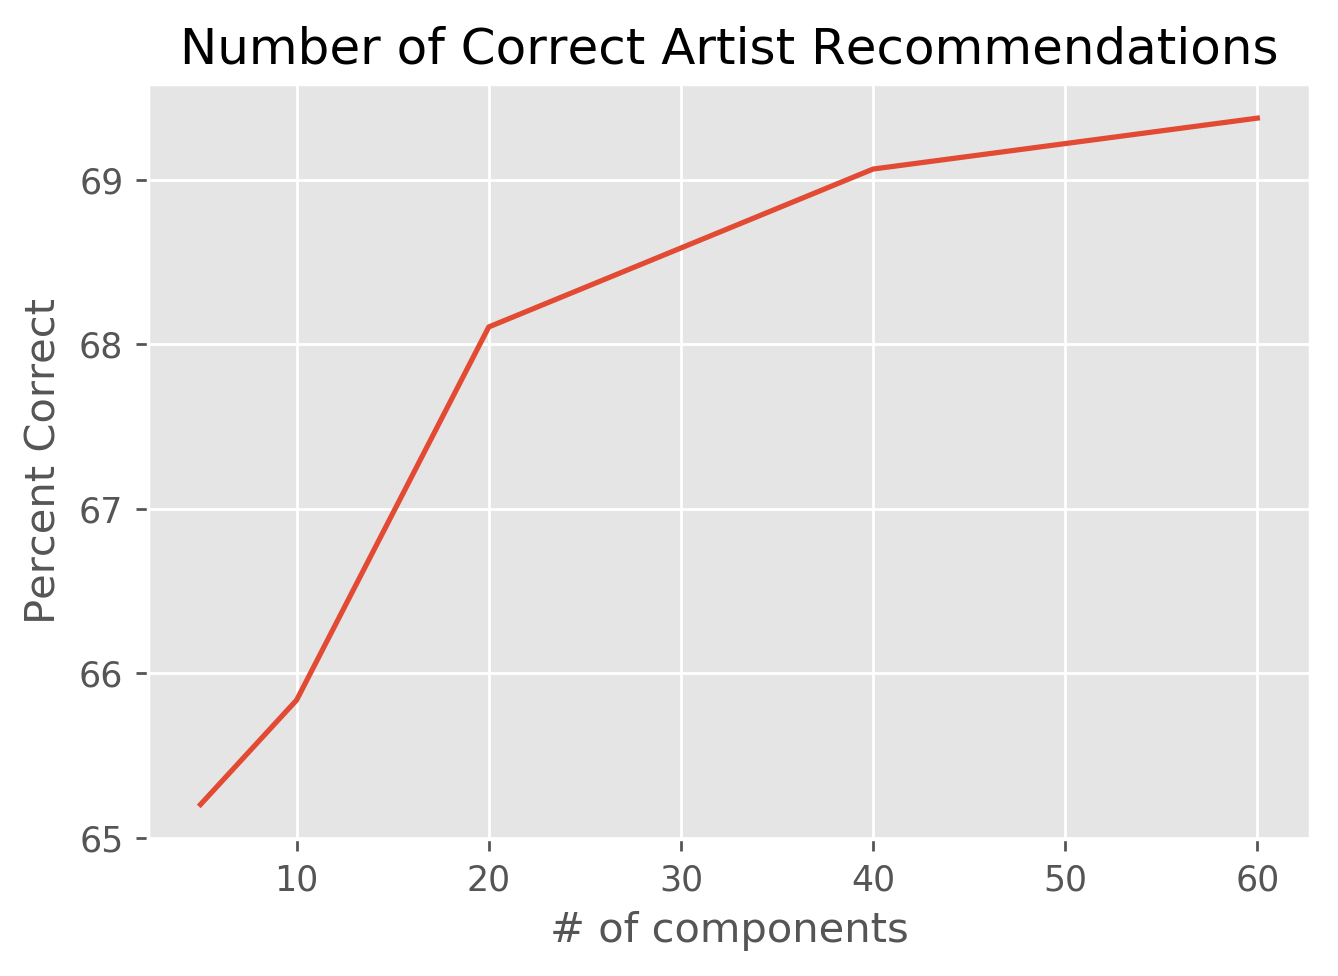

In [197]:
# lsa_tfidf DIMENSIONALITY REDUCTION ON TFIDF

n_comp = [5,10,20,40,60]
print('USING LSA TFIDF')

num_components =[]
perc_corr_per_component = []

for i in n_comp:
    lsa_tfidf = TruncatedSVD(n_components=i)

    lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)

    percent_corr = []

    for j in range(len(model_df)):
        rec_list = get_recommendations(model_df.verse_lem[j], lsa_tfidf, tfidf_vectorizer, lsa_tfidf_data)
        percent_corr.append(recommendations_correct(j,rec_list))
        
    perc_corr_per_component.append((sum(percent_corr)/len(percent_corr)))
    num_components.append(i)
    
    print(f'Percent recommendations with correct artist using {i} components: ',(sum(percent_corr)/len(percent_corr)))
    
plt.figure(dpi=250)
plt.xlabel('# of components')
plt.ylabel('Percent Correct')
plt.title('Number of Correct Artist Recommendations')
plt.plot(num_components, perc_corr_per_component)

USING LSA CV
Percent recommendations with correct artist using 5 components:  61.64860681114551
Percent recommendations with correct artist using 10 components:  61.88854489164087
Percent recommendations with correct artist using 20 components:  63.54489164086687
Percent recommendations with correct artist using 40 components:  66.81114551083591
Percent recommendations with correct artist using 60 components:  67.81733746130031


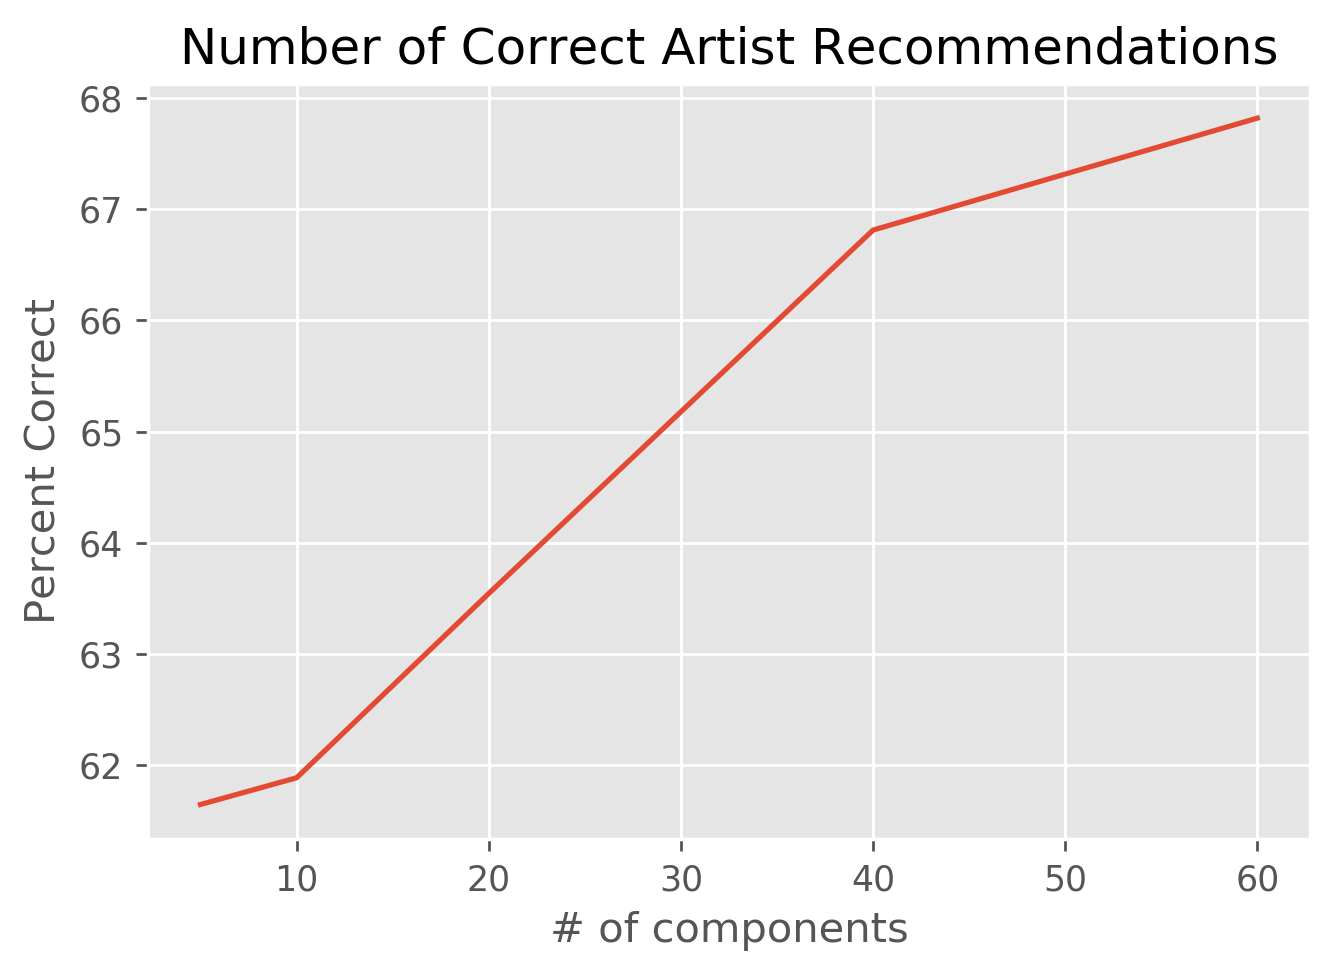

In [199]:
n_comp = [5,10,20,40,60]
print('USING LSA CV')

num_components =[]
perc_corr_per_component = []

for i in n_comp:
    lsa_cv = TruncatedSVD(n_components=i)

    lsa_cv_data = lsa_cv.fit_transform(cv_data)

    percent_corr = []

    for j in range(len(model_df)):
        rec_list = get_recommendations(model_df.verse_lem[j], lsa_cv, count_vectorizer, lsa_cv_data)
        percent_corr.append(recommendations_correct(j,rec_list))
        
    perc_corr_per_component.append((sum(percent_corr)/len(percent_corr)))
    num_components.append(i)
    
    print(f'Percent recommendations with correct artist using {i} components: ',(sum(percent_corr)/len(percent_corr)))
                            
plt.figure(dpi=250)
plt.xlabel('# of components')
plt.ylabel('Percent Correct')
plt.title('Number of Correct Artist Recommendations')
plt.plot(num_components, perc_corr_per_component)

USING NMF CV
Percent recommendations with correct artist using 5 components:  61.51702786377709
Percent recommendations with correct artist using 10 components:  60.71207430340557
Percent recommendations with correct artist using 20 components:  60.89009287925697
Percent recommendations with correct artist using 40 components:  63.591331269349844
Percent recommendations with correct artist using 60 components:  65.98297213622291


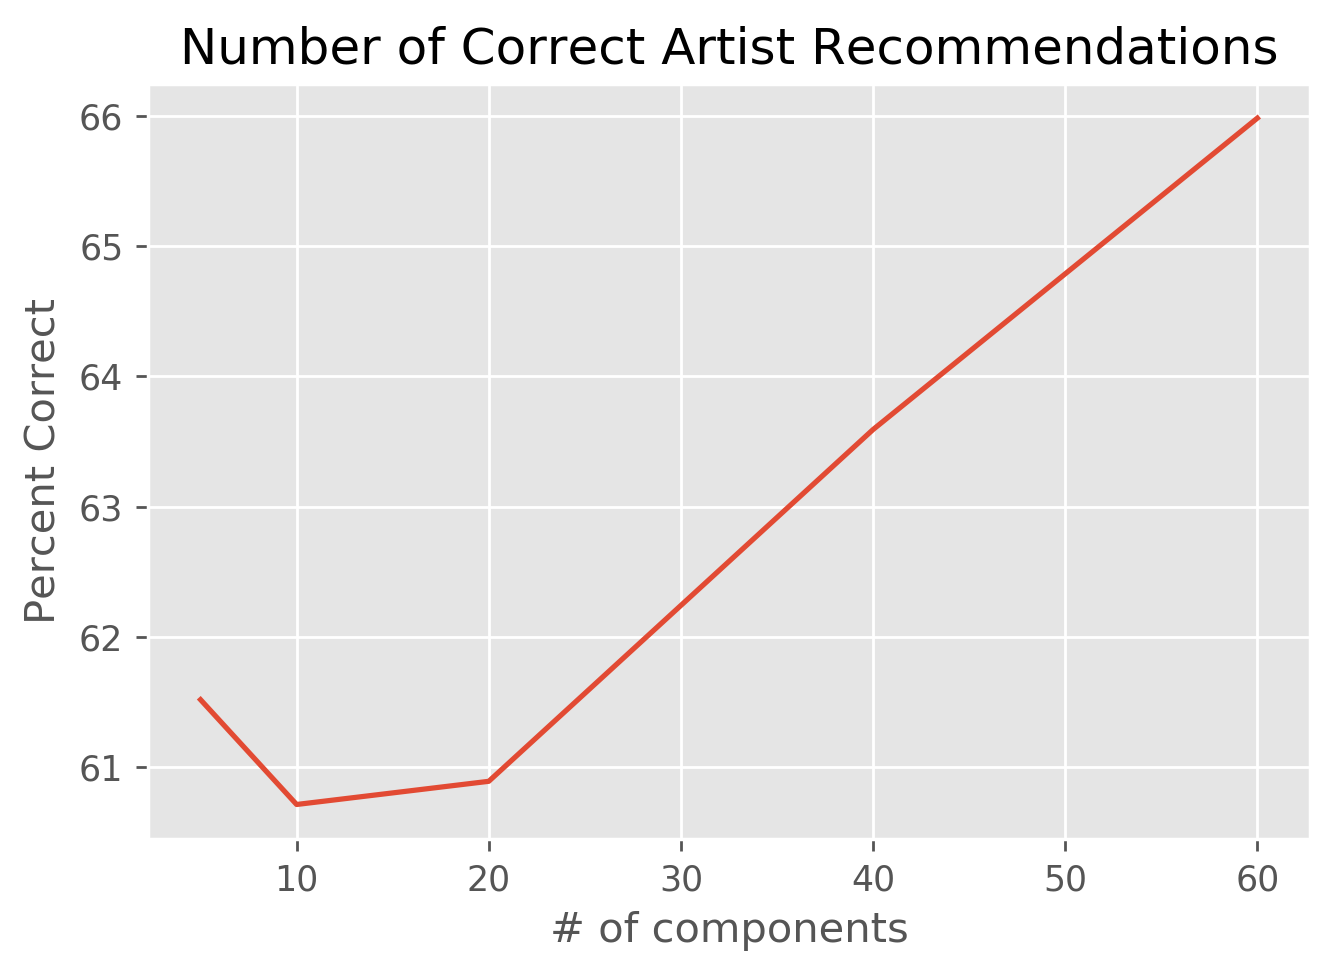

In [198]:
n_comp = [5,10,20,40,60]
print('USING NMF CV')

num_components =[]
perc_corr_per_component = []

for i in n_comp:
    nmf_cv = NMF(n_components=i)

    nmf_cv_data = nmf_cv.fit_transform(cv_data)

    percent_corr = []

    for j in range(len(model_df)):
        rec_list = get_recommendations(model_df.verse_lem[j], nmf_cv, count_vectorizer, nmf_cv_data)
        percent_corr.append(recommendations_correct(j,rec_list))
        
    perc_corr_per_component.append((sum(percent_corr)/len(percent_corr)))
    num_components.append(i)
    
    print(f'Percent recommendations with correct artist using {i} components: ',(sum(percent_corr)/len(percent_corr)))
    
plt.figure(dpi=250)
plt.xlabel('# of components')
plt.ylabel('Percent Correct')
plt.title('Number of Correct Artist Recommendations')
plt.plot(num_components, perc_corr_per_component)

USING LDA CV
Percent recommendations with correct artist using 2 components:  58.026315789473685
Percent recommendations with correct artist using 5 components:  60.18575851393189
Percent recommendations with correct artist using 8 components:  63.27399380804953
Percent recommendations with correct artist using 10 components:  63.40557275541796
Percent recommendations with correct artist using 12 components:  65.96749226006192
Percent recommendations with correct artist using 15 components:  67.49226006191951


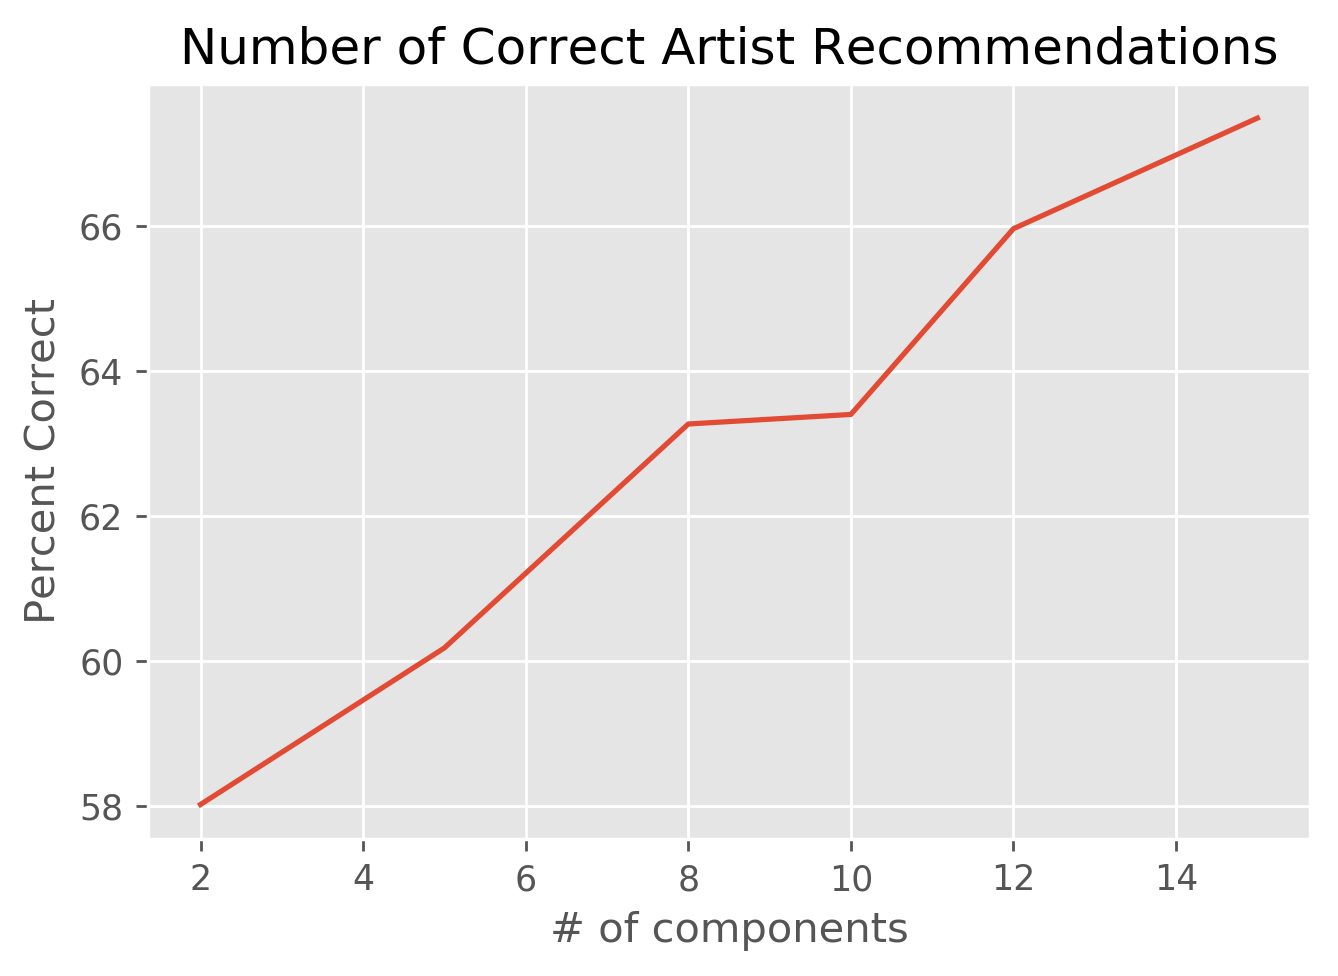

In [200]:
n_comp = [2,5,8,10,12,15]
print('USING LDA CV')

num_components =[]
perc_corr_per_component = []

for i in n_comp:
    lda_cv = LatentDirichletAllocation(n_components=i)

    lda_cv_data = lda_cv.fit_transform(cv_data)

    percent_corr = []

    for j in range(len(model_df)):
        rec_list = get_recommendations(model_df.verse_lem[j], lda_cv, count_vectorizer, lda_cv_data)
        percent_corr.append(recommendations_correct(j,rec_list))
        
    perc_corr_per_component.append((sum(percent_corr)/len(percent_corr)))
    num_components.append(i)
    
    print(f'Percent recommendations with correct artist using {i} components: ',(sum(percent_corr)/len(percent_corr)))
    
plt.figure(dpi=250)
plt.xlabel('# of components')
plt.ylabel('Percent Correct')
plt.title('Number of Correct Artist Recommendations')
plt.plot(num_components, perc_corr_per_component)

USING LDA TFIDF
Percent recommendations with correct artist using 2 components:  55.06965944272446
Percent recommendations with correct artist using 5 components:  62.88699690402477
Percent recommendations with correct artist using 8 components:  64.17956656346749
Percent recommendations with correct artist using 10 components:  64.47368421052632
Percent recommendations with correct artist using 12 components:  66.77244582043343
Percent recommendations with correct artist using 15 components:  68.96284829721363


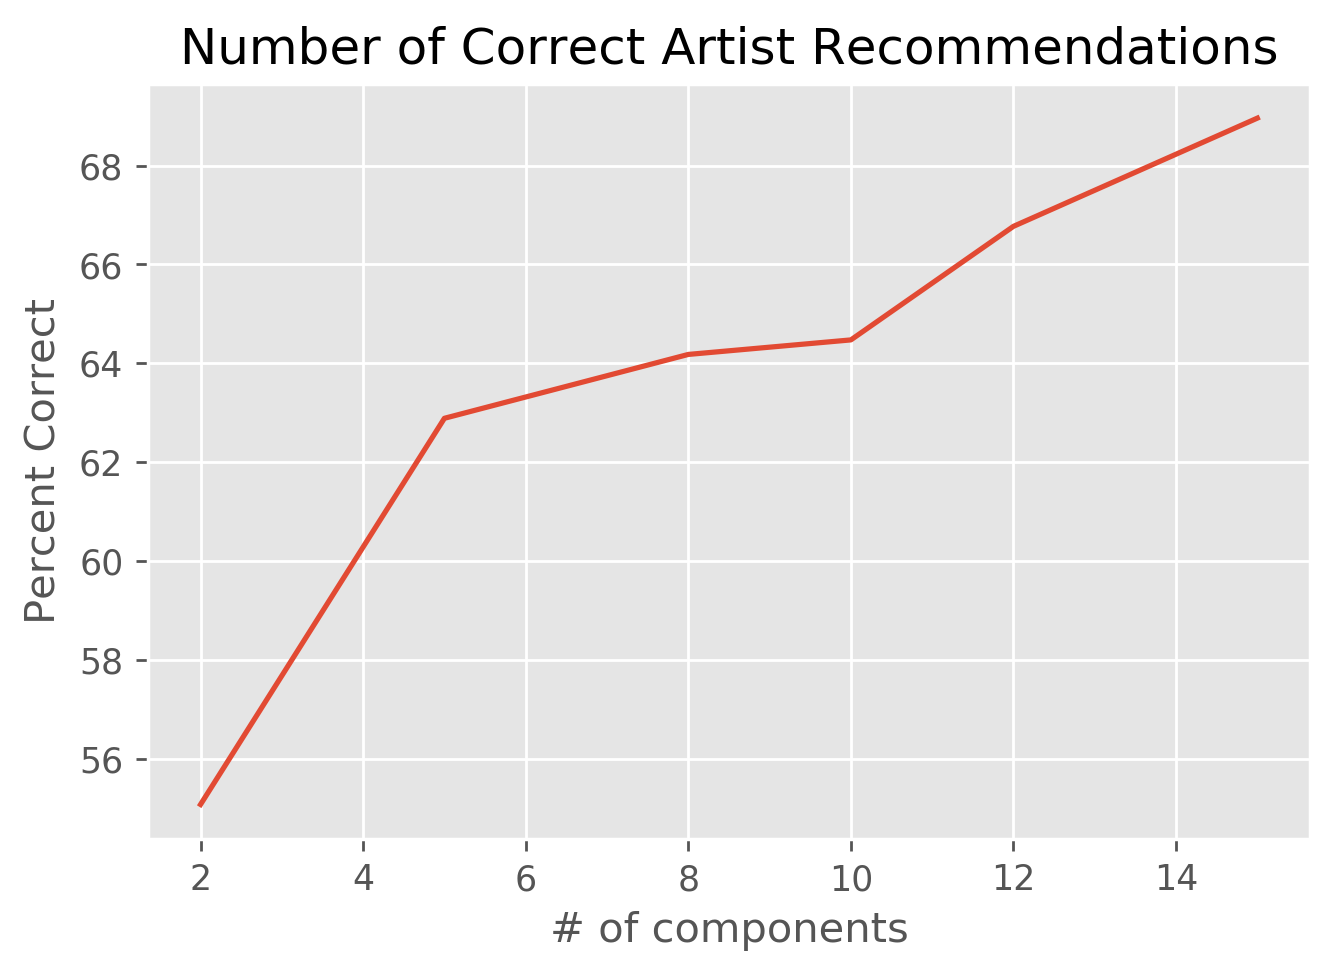

In [201]:
n_comp = [2,5,8,10,12,15]
print('USING LDA TFIDF')

num_components =[]
perc_corr_per_component = []

for i in n_comp:
    lda_tfidf = LatentDirichletAllocation(n_components=i)

    lda_tfidf_data = lda_tfidf.fit_transform(tfidf_data)

    percent_corr = []

    for j in range(len(model_df)):
        rec_list = get_recommendations(model_df.verse_lem[j], lda_tfidf, tfidf_vectorizer, lda_tfidf_data)
        percent_corr.append(recommendations_correct(j,rec_list))
        
    perc_corr_per_component.append((sum(percent_corr)/len(percent_corr)))
    num_components.append(i)
    
    print(f'Percent recommendations with correct artist using {i} components: ',(sum(percent_corr)/len(percent_corr)))
    
plt.figure(dpi=250)
plt.xlabel('# of components')
plt.ylabel('Percent Correct')
plt.title('Number of Correct Artist Recommendations')
plt.plot(num_components, perc_corr_per_component)

Childish Gambino: 824
Chance: 468
Proportion: 1.76 : 1
Percentage of Majority Class: 63.78


(array([0, 1]), <a list of 2 Text xticklabel objects>)

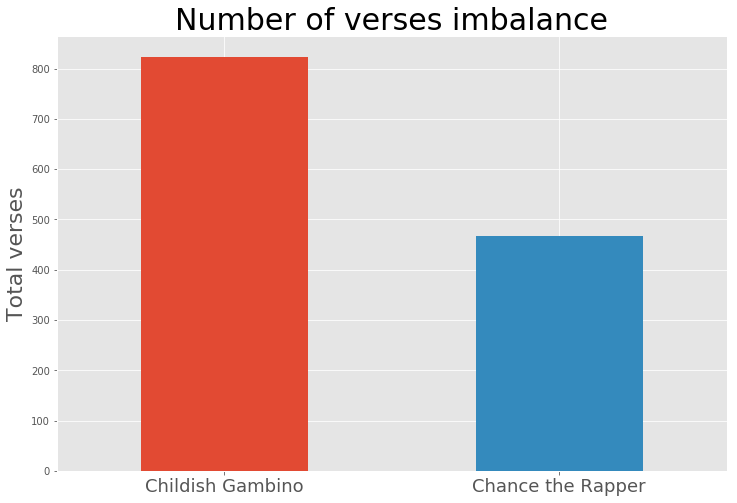

In [287]:
target_count = model_df['artist'].value_counts()
print(f'Childish Gambino: {target_count[0]}')
print(f'Chance: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

target_count.plot(kind='bar', title='Artist Count', rot=0);
plt.gcf().set_size_inches(12,8)
plt.ylabel('Total verses', fontsize=22)
plt.title("Number of verses imbalance", fontsize=30)
plt.xticks(fontsize=18)

In [254]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(model_df, test_size=0.2, random_state=42)

In [255]:
x_train = train_data.verse_lem
y_train = train_data.artist


x_test = test_data.verse_lem
y_test = test_data.artist

In [256]:
print(x_train[:5])

1067    The day be on its way , it could n't wait no m...
966     'Member sittin ' in class the first time liste...
803     We just wan na party , Party just for you , We...
339     Love do n't really happen , Love do n't really...
667                           Everybody put their hand up
Name: verse_lem, dtype: object


In [257]:
print(y_train[:5])

1067    Chance the Rapper
966     Chance the Rapper
803      Childish Gambino
339      Childish Gambino
667      Childish Gambino
Name: artist, dtype: object


In [267]:
#create pipeline
pipe = Pipeline([('tfid', TfidfVectorizer()), ('tfidt', TfidfTransformer()),('nb', MultinomialNB())])
#set param_grid
param_grid = {'tfid__stop_words':[my_stop_words], 'nb__alpha': [0.0001,0.001,0.005,0.1, 0.5, 1, 2]}
#grid search through the parameters 
grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True)
#fit it to my data 
grid.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfid', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...linear_tf=False, use_idf=True)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tfid__stop_words': [frozenset({'somewhere', 'twelve', 'his', 'one', 'at', 'is', 'where', 'ha', 'ourselves', 'em', 'shit', 'bottom', 'up', 'would', 'will', 'whereafter', 'ooh', 'if', 'whither', 'see', 'about', 'something', 'namely', 'wu', 'from', 'toward', 'however', 'thick', 'nowhere', ...'due', 'was', 'even', 'its', 'within', 'aw'})], 'nb__alpha': [0.0001, 0.001, 0.005, 0.1, 0.5, 1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_tra

In [268]:
grid.best_params_

{'nb__alpha': 0.1,
 'tfid__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'aw',
            'ay',
            'ayy',
            'ba',
            'back',
            'be',
            'became',
            'because',
            'become',
            'becomes',
            'becoming',
            'b

In [269]:
grid_score = cross_val_score(grid, x_train, y_train, cv=5).mean()
y_train_pred = grid.predict(x_train)
grid_score

0.8451198349045542

In [270]:
y_test_pred = grid.predict(x_test)
y_test_pred

array(['Childish Gambino', 'Childish Gambino', 'Childish Gambino',
       'Childish Gambino', 'Childish Gambino', 'Chance the Rapper',
       'Childish Gambino', 'Childish Gambino', 'Childish Gambino',
       'Childish Gambino', 'Chance the Rapper', 'Childish Gambino',
       'Childish Gambino', 'Childish Gambino', 'Childish Gambino',
       'Childish Gambino', 'Chance the Rapper', 'Chance the Rapper',
       'Childish Gambino', 'Childish Gambino', 'Childish Gambino',
       'Chance the Rapper', 'Childish Gambino', 'Childish Gambino',
       'Childish Gambino', 'Childish Gambino', 'Childish Gambino',
       'Childish Gambino', 'Chance the Rapper', 'Childish Gambino',
       'Chance the Rapper', 'Childish Gambino', 'Childish Gambino',
       'Childish Gambino', 'Childish Gambino', 'Childish Gambino',
       'Childish Gambino', 'Childish Gambino', 'Childish Gambino',
       'Childish Gambino', 'Childish Gambino', 'Childish Gambino',
       'Childish Gambino', 'Childish Gambino', 'Childis

In [271]:
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

0.9748305905130688
0.8687258687258688


In [288]:
models = [LogisticRegression(), KNeighborsClassifier(), MultinomialNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), DummyClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees', 'Dummy']

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    for train_index, test_index in kf.split(x_train):
        
        kX_train = x_train.iloc[train_index]
        kX_test = x_train.iloc[test_index]
        ky_train = y_train.iloc[train_index]
        ky_test = y_train.iloc[test_index]
        
        model = Pipeline([('tfid', TfidfVectorizer()), ('LDA', LatentDirichletAllocation()), (names[i], models[i])])
        #fit it to my data 
        model.fit(kX_train, ky_train)
        y_train_pred = model.predict(kX_train)

        accuracy.append(accuracy_score(ky_train, y_train_pred))
        precision.append(precision_score(ky_train, y_train_pred, pos_label = 'Childish Gambino'))
        recall.append(recall_score(ky_train, y_train_pred, pos_label = 'Childish Gambino'))
        f1.append(f1_score(ky_train, y_train_pred, pos_label = 'Childish Gambino'))

    model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()
    
    model_score = np.round(model_score, 4)
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    
    print('Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION')
    print(f'{names[i]} model_score: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
    print('')

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
LR model_score: 0.6618 accuracy: 0.6544 precision: 0.6507 recall: 0.9925 f1: 0.7858

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
KNN model_score: 0.6168 accuracy: 0.743 precision: 0.7699 recall: 0.8524 f1: 0.8087

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
NB model_score: 0.6589 accuracy: 0.6389 precision: 0.6389 recall: 1.0 f1: 0.7796

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
SVC model_score: 0.6575 accuracy: 0.6389 precision: 0.6389 recall: 1.0 f1: 0.7796

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
Decision Tree model_score: 0.6183 accuracy: 0.9995 precision: 0.9992 recall: 1.0 f1: 0.9996

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
Random Forest model_score: 0.624 accuracy: 0.9569 precision: 0.9757 recall: 0.9568 f1: 0.9661

Scores with No Oversampling - LDA DIMENSIONALITY REDUCTION
Gradient Boosted Trees model_score: 0.64 accuracy: 0.7899 precis

In [321]:
models = [('tree', DecisionTreeClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LDA', LatentDirichletAllocation()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LDA__n_components': [8,10,12,15],
                  'tree__max_depth': [1,2,3,4,5,6,7], 'tree__min_samples_leaf': [3,6,8,10,12,15]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.6708615682478218, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])


In [322]:
dt1 = grid.best_estimator_
dt1.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [323]:
model = dt1

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Childish Gambino'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Childish Gambino'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Childish Gambino'))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('DECISION TREE MVP')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

DECISION TREE MVP
modelscore: 0.6487 accuracy: 0.6631 precision: 0.6557 recall: 0.9954 f1: 0.7903



In [293]:
models = [('LogReg', LogisticRegression)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LDA', LatentDirichletAllocation()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LDA__n_components': [8,10,12,15], 'LogReg__C': np.logspace(-3,6, 12)}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

LogReg: best score: 0.6776379477250726, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


In [294]:
lm1 = grid.best_estimator_
lm1.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [295]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = lm1.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Childish Gambino'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Childish Gambino'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Childish Gambino'))

model_score = cross_val_score(lm1, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('Logistic Regress MVP')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

Logistic Regress MVP
modelscore: 0.6691 accuracy: 0.6873 precision: 0.6836 recall: 0.9553 f1: 0.7958



In [296]:
models = [('forest', RandomForestClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LDA', LatentDirichletAllocation()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LDA__n_components': [8,10,12,15],
                  'forest__n_estimators': [25,50, 100, 200], 'forest__max_depth': [1,2,3,4,5,7,10],
                  'forest__min_samples_leaf': [3,6,10]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.6776379477250726, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


In [297]:
rf1 = grid.best_estimator_
rf1.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [298]:
model = rf1

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Childish Gambino'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Childish Gambino'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Childish Gambino'))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('RANDOM FOREST MVP')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

RANDOM FOREST MVP
modelscore: 0.675 accuracy: 0.7299 precision: 0.7099 recall: 0.9785 f1: 0.8222



In [299]:
models = [('knn', KNeighborsClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LDA', LatentDirichletAllocation()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LDA__n_components': [8,10,12,15],
                  'knn__n_neighbors': range(1, 12)}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.6592449177153921, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...owski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform'))])


In [300]:
knn1 = grid.best_estimator_
knn1.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...owski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform'))])

In [301]:
model = knn1

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Childish Gambino'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Childish Gambino'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Childish Gambino'))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('K-NEAREST NEIGHBORS MVP')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

K-NEAREST NEIGHBORS MVP
modelscore: 0.6414 accuracy: 0.7096 precision: 0.7397 recall: 0.8434 f1: 0.7875



The mean of 10 fold cross validation accuracy score on LogReg model is 0.666


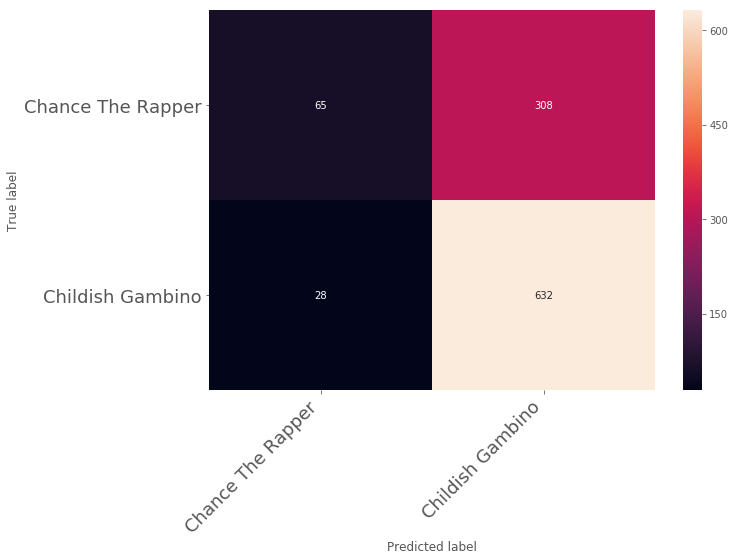

In [330]:
from sklearn.metrics import confusion_matrix

model = lm1

predict_y_train = model.predict(x_train)

LR_cross_val = cross_val_score(model, x_train, y_train, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on LogReg model is', str(round(np.mean(LR_cross_val), 3)))

LR = confusion_matrix(y_train, predict_y_train)
LR_CM = print_confusion_matrix(LR, ['Chance The Rapper', 'Childish Gambino'])

The mean of 10 fold cross validation accuracy score on Random Forest model is 0.642


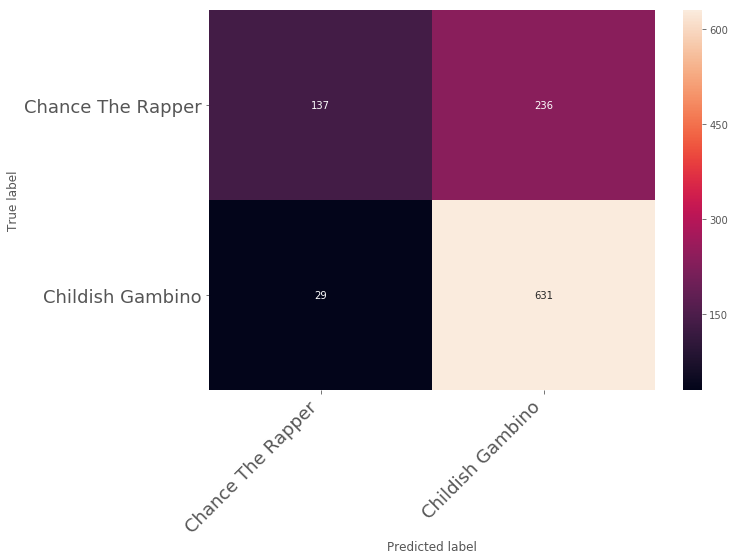

In [331]:
from sklearn.metrics import confusion_matrix

model = rf1

predict_y_train = model.predict(x_train)

RF_cross_val = cross_val_score(model, x_train, y_train, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_cross_val), 3)))

RF = confusion_matrix(y_train, predict_y_train)
RF_CM = print_confusion_matrix(RF, ['Chance The Rapper', 'Childish Gambino'])

The mean of 10 fold cross validation accuracy score on KNN model is 0.647


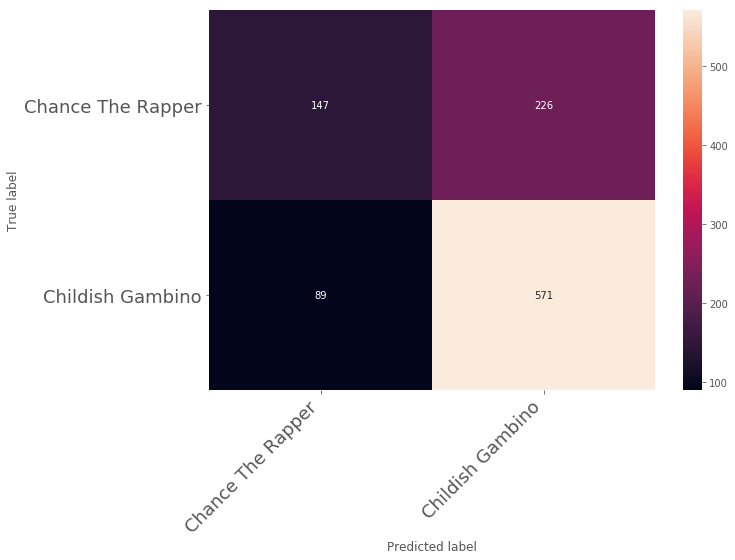

In [332]:
from sklearn.metrics import confusion_matrix

model = knn1

predict_y_train = model.predict(x_train)

KNN_cross_val = cross_val_score(model, x_train, y_train, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on KNN model is', str(round(np.mean(KNN_cross_val), 3)))

KNN = confusion_matrix(y_train, predict_y_train)
KNN_CM = print_confusion_matrix(KNN, ['Chance The Rapper', 'Childish Gambino'])

In [ ]:
model = knn1

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Childish Gambino'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Childish Gambino'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Childish Gambino'))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('K-NEAREST NEIGHBORS MVP')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

In [310]:
models = [('dc', DummyClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LDA', LatentDirichletAllocation()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LDA__n_components': [8,10,12,15]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

dc: best score: 0.558567279767667, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...00.0, verbose=0)), ('dc', DummyClassifier(constant=None, random_state=None, strategy='stratified'))])


In [311]:
dc = grid.best_estimator_
dc.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...00.0, verbose=0)), ('dc', DummyClassifier(constant=None, random_state=None, strategy='stratified'))])

In [318]:
models = [('knn', KNeighborsClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LDA', LatentDirichletAllocation()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LDA__n_components': [8,10,12,15]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.6195546950629235, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])


In [319]:
knn2 = grid.best_estimator_
knn2.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [336]:
models = [('RF', RandomForestClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LDA', LatentDirichletAllocation()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LDA__n_components': [8,10,12,15]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

RF: best score: 0.6563407550822846, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


In [337]:
rf2 = grid.best_estimator_
rf2.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [338]:
model = rf2

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Childish Gambino'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Childish Gambino'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Childish Gambino'))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('K-NEAREST NEIGHBORS MVP')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

K-NEAREST NEIGHBORS MVP
modelscore: 0.6197 accuracy: 0.9535 precision: 0.9808 recall: 0.945 f1: 0.9625



In [339]:
models = [('tree', DecisionTreeClassifier)]

grids = {}
for model_info in models:
    name, model = model_info
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LDA', LatentDirichletAllocation()), (name, model())])
    param_grid = {'tfidf__stop_words':[my_stop_words], 'LDA__n_components': [8,10,12,15]}
    grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True) 
    grid.fit(x_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.6524685382381413, best estimator: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])


In [340]:
dt2 = grid.best_estimator_
dt2.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [341]:
model = dt2

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
    
for train_index, test_index in kf.split(x_train):

    kX_train = x_train.iloc[train_index]
    kX_test = x_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    y_predict = model.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Childish Gambino'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Childish Gambino'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Childish Gambino'))

model_score = cross_val_score(model, kX_train, ky_train, cv=5).mean()    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
model_score = np.round(model_score, 4)

print('Decision Tree MVP')
print(f'modelscore: {model_score} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
print('')

Decision Tree MVP
modelscore: 0.6124 accuracy: 0.9797 precision: 0.9876 recall: 0.9807 f1: 0.984



In [342]:
models = [lm1, rf1, knn1, dc, knn2, dt1, rf2, dt2]
names = ['LogReg', 'Random Forest', 'KNN', 'Dummy', 'KNN2', 'Decision Tree', 'RF2', 'DT2']

print(f'TEST Scores')

for model, name in zip(models, names):

    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []

    y_predict = model.predict(x_test)

    accuracy.append(accuracy_score(y_test, y_predict))
    precision.append(precision_score(y_test, y_predict, pos_label = 'Childish Gambino'))
    recall.append(recall_score(y_test, y_predict, pos_label = 'Childish Gambino'))
    f1.append(f1_score(y_test, y_predict, pos_label = 'Childish Gambino'))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)


    print(f'{name} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')
    print('')

TEST Scores
LogReg accuracy: 0.6757 precision: 0.6639 recall: 0.9878 f1: 0.7941

Random Forest accuracy: 0.6911 precision: 0.6842 recall: 0.9512 f1: 0.7959

KNN accuracy: 0.6178 precision: 0.6633 recall: 0.8049 f1: 0.7273

Dummy accuracy: 0.5367 precision: 0.6325 recall: 0.6402 f1: 0.6364

KNN2 accuracy: 0.6409 precision: 0.6898 recall: 0.7866 f1: 0.735

Decision Tree accuracy: 0.6255 precision: 0.6314 recall: 0.9817 f1: 0.7685

RF2 accuracy: 0.668 precision: 0.7407 recall: 0.7317 f1: 0.7362

DT2 accuracy: 0.7143 precision: 0.7679 recall: 0.7866 f1: 0.7771



In [356]:
models = [lm1, rf2, knn2, dt2, dc]
names = ['LogReg', 'Random Forest', 'KNN', 'Decision Tree', 'Dummy']

roc_plotting_stuff = []
for model, name in zip(models, names):
    model.fit(x_train, y_train)
    preds = model.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, preds[:,1], pos_label = 'Childish Gambino')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))
    
print(preds)

[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]

Text(0.5,1,'Comparing ROC Curves')

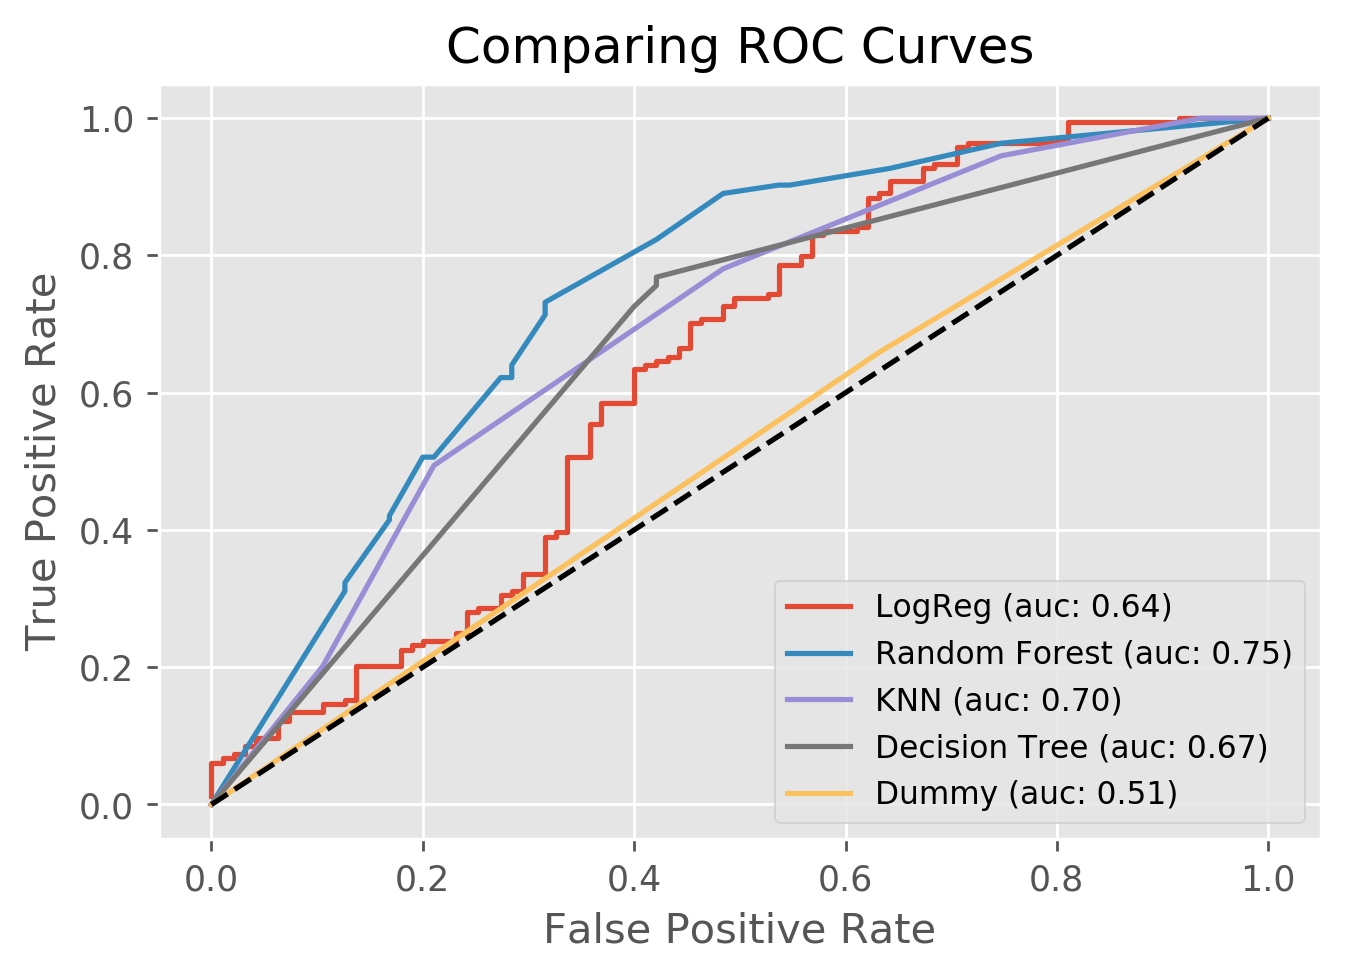

In [357]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves")

The mean of 10 fold cross validation accuracy score on RF1 model is 0.645


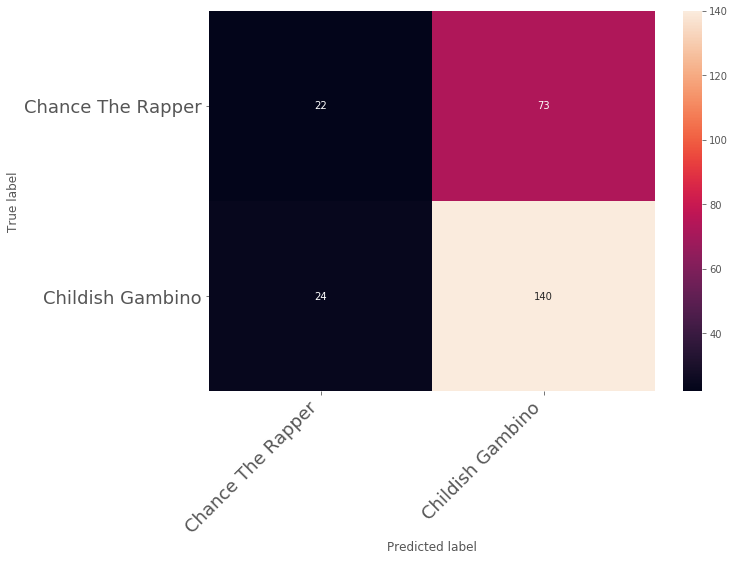

In [350]:
model = rf1

predict_y_test = model.predict(x_test)

LR_cross_val = cross_val_score(model, x_test, y_test, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on RF1 model is', str(round(np.mean(LR_cross_val), 3)))

LR = confusion_matrix(y_test, predict_y_test)
LR_CM = print_confusion_matrix(LR, ['Chance The Rapper', 'Childish Gambino'])

The mean of 10 fold cross validation accuracy score on Random Forest2 model is 0.567


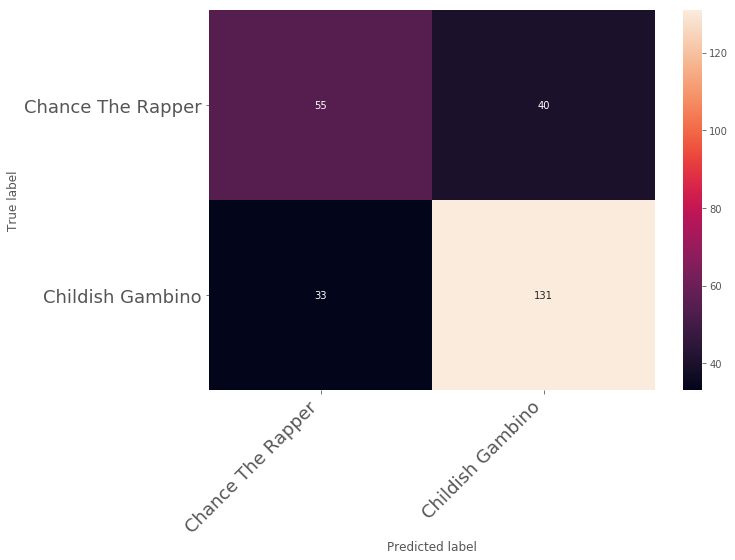

In [351]:
model = rf2

predict_y_test = model.predict(x_test)

LR_cross_val = cross_val_score(model, x_test, y_test, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on Random Forest2 model is', str(round(np.mean(LR_cross_val), 3)))

LR = confusion_matrix(y_test, predict_y_test)
LR_CM = print_confusion_matrix(LR, ['Chance The Rapper', 'Childish Gambino'])

The mean of 10 fold cross validation accuracy score on DecisionTree 2 model is 0.618


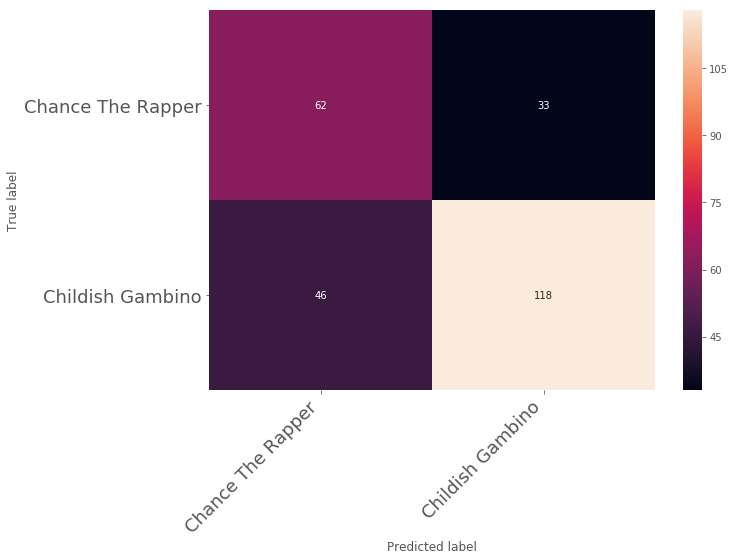

In [352]:
model = dt2

predict_y_test = model.predict(x_test)

LR_cross_val = cross_val_score(model, x_test, y_test, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on DecisionTree 2 model is', str(round(np.mean(LR_cross_val), 3)))

LR = confusion_matrix(y_test, predict_y_test)
LR_CM = print_confusion_matrix(LR, ['Chance The Rapper', 'Childish Gambino'])

The mean of 10 fold cross validation accuracy score on Dummy model is 0.541


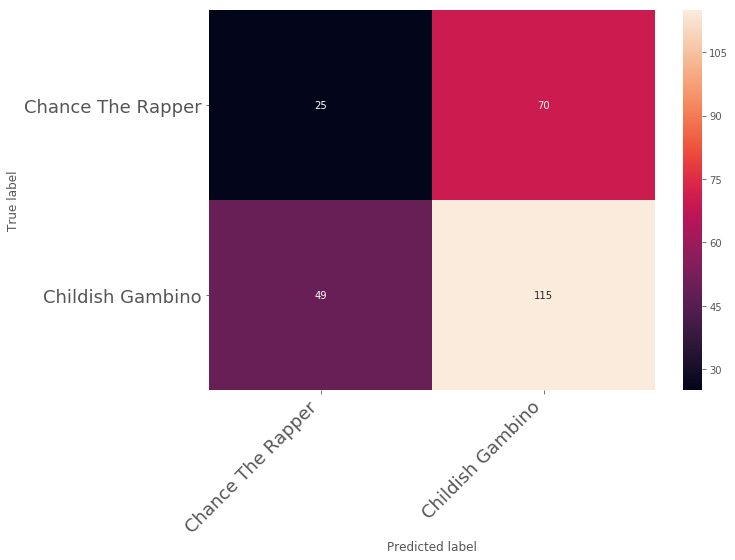

In [353]:
model = dc

predict_y_test = model.predict(x_test)

LR_cross_val = cross_val_score(model, x_test, y_test, scoring='accuracy', cv = 10)
print('The mean of 10 fold cross validation accuracy score on Dummy model is', str(round(np.mean(LR_cross_val), 3)))

LR = confusion_matrix(y_test, predict_y_test)
LR_CM = print_confusion_matrix(LR, ['Chance The Rapper', 'Childish Gambino'])

In [358]:
with open('MVP_RF.pkl', 'wb') as picklefile:
    pickle.dump(rf2, picklefile)
    
with open('MVP_LogReg.pkl', 'wb') as picklefile:
    pickle.dump(lm1, picklefile)
    
with open('MVP_KNN.pkl', 'wb') as picklefile:
    pickle.dump(knn2, picklefile)
    
with open('MVP_DecTree.pkl', 'wb') as picklefile:
    pickle.dump(dt2, picklefile)
    
with open('MVP_Dummy.pkl', 'wb') as picklefile:
    pickle.dump(dc, picklefile)